## **TASK1: 이미지 기반 의류 분류 모델**

### **데이터 탐색 & 전처리**

기본 세팅: zip 파일 해제 & 이미지 경로 수집


이미지 경로 + 라벨 DataFrame 생성 함수

In [4]:
import zipfile
import os

zip_path = '../data/image.zip'
# 압축을 풀 폴더 경로
extract_path = '../data/extracted_images'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f" '{extract_path}'에 압축 해제 완료!")
else:
    print("이미 압축이 풀려 있습니다.")

이미 압축이 풀려 있습니다.


In [19]:
import pandas as pd
from pathlib import Path

def load_image_dataframe(root_dir):
    image_extensions = [".jpg", ".jpeg", ".png"]
    rows = []
    for path in Path(root_dir).rglob("*"):
        if path.suffix.lower() in image_extensions:
            label = path.parent.name  
            # 폴더명이 클래스 라벨
            rows.append([str(path), label])
    df = pd.DataFrame(rows, columns=["filepath", "label"])
    return df

df_images = load_image_dataframe(extract_path)
df_images.head(), df_images.shape

(                                            filepath        label
 0  ..\data\extracted_images\black_dress\009796087...  black_dress
 1  ..\data\extracted_images\black_dress\038098f91...  black_dress
 2  ..\data\extracted_images\black_dress\0522170fb...  black_dress
 3  ..\data\extracted_images\black_dress\0561718ae...  black_dress
 4  ..\data\extracted_images\black_dress\06130b80c...  black_dress,
 (5993, 2))

- 클래스별 이미지 수 집계 함수

In [29]:
def show_class_distribution(df):
    class_counts = df["label"].value_counts()
    print("\n 클래스별 이미지 수")
    print(class_counts)
    return class_counts

class_counts = show_class_distribution(df_images)



 클래스별 이미지 수
label
black_pants     871
blue_pants      798
black_shoes     766
blue_shirt      741
black_shirt     715
blue_shoes      523
blue_dress      502
black_dress     450
black_shorts    328
blue_shorts     299
Name: count, dtype: int64


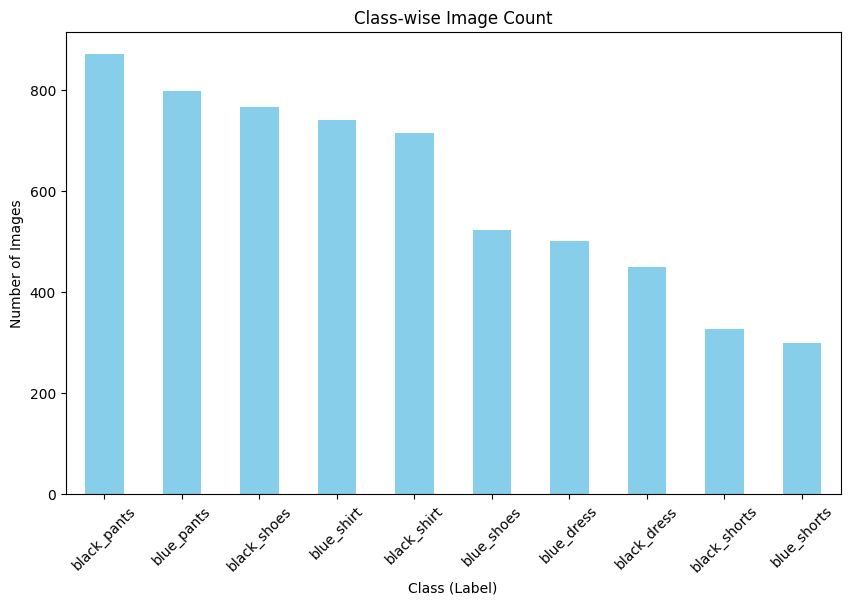

In [21]:
import matplotlib.pyplot as plt

# 그래프 시각화 추가
class_counts.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title("Class-wise Image Count")
plt.xlabel("Class (Label)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

    -  클래스 폴더명 기준으로 라벨을 추출해 DataFrame을 구성하였다.

    - 전체 이미지 수는 5993개, 클래스는 10개이다.

### **그래프 해석**

>그래프를 통해 확인한 결과, 클래스별 이미지 보유 수는 약 300장대(black_shorts, blue_shorts)부터 800장대(black_pants, blue_pants)까지 범위가 나타나며, 특히 pants 계열은 약 800장 수준으로 가장 많고 shorts 계열은 약 300장 수준으로 가장 적다. 최대·최소 클래스 간 표본 수 차이가 약 2.5배 이상으로 비교적 큰 편이므로, 전체적으로는 데이터 불균형이 존재한다고 볼 수 있다..

- 이미지 해상도 / 색공간(RGB) / 파일포맷 조사 함수

In [26]:
def inspect_image_properties(df, sample_size=20):
    """
    이미지 해상도, 색공간, 포맷 등 기초 정보를 수집.
    sample_size=None 이면 전체 이미지 검사
    """
    if sample_size is not None:
        df_sample = df.sample(min(sample_size, len(df)), random_state=42)
    else:
        df_sample = df

    info_rows = []

    for fp in df_sample["filepath"]:
        try:
            with Image.open(fp) as img:
                width, height = img.size
                mode = img.mode  # RGB, RGBA, L 등
                fmt = img.format  # JPEG, PNG 등
            info_rows.append([fp, width, height, mode, fmt])
        except Exception as e:
            info_rows.append([fp, None, None, None, None])

    df_info = pd.DataFrame(info_rows,
                           columns=["filepath", "width", "height", "mode", "format"])
    return df_info

df_info = inspect_image_properties(df_images, sample_size=30) #샘플로 30개만 뽑아서 봄
df_info.head()

filepath  width  height mode  \
0  ..\data\extracted_images\black_shoes\7ed38abe6...    474     267  RGB   
1  ..\data\extracted_images\black_shirt\d61a72d38...    474     474  RGB   
2  ..\data\extracted_images\black_shoes\9a61f49fb...    473     473  RGB   
3  ..\data\extracted_images\black_shoes\9d7251f8f...    474     400  RGB   
4  ..\data\extracted_images\black_shirt\fa2aa7994...    474     267  RGB   

  format  
0   JPEG  
1   JPEG  
2   JPEG  
3   JPEG  
4   JPEG

In [27]:
print("\n 이미지 해상도 상위 빈도")
print(df_info[["width", "height"]].value_counts().head())

print("\n 색공간(mode) 분포")
print(df_info["mode"].value_counts())

print("\n 파일 포맷(format) 분포")
print(df_info["format"].value_counts())



 이미지 해상도 상위 빈도
width  height
474    474       9
       711       3
       639       2
       267       2
396    331       1
Name: count, dtype: int64

 색공간(mode) 분포
mode
RGB    30
Name: count, dtype: int64

 파일 포맷(format) 분포
format
JPEG    30
Name: count, dtype: int64


    - 해석

대부분의 이미지가 RGB 색공간이며,

파일 포맷은 주로 JPEG로 구성되어 있다.

해상도는 일정하지 않아 모델 입력을 위해 Resize 전처리가 필요하다.

- **전처리**

(Resize + 정규화 + Augmentation)

라이브러리 & label 인덱스 매핑

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

# label ↔ index 매핑
labels = sorted(df_images["label"].unique())
label_to_idx = {lbl: i for i, lbl in enumerate(labels)}
idx_to_label = {i: lbl for lbl, i in label_to_idx.items()}
label_to_idx


# 결과 확인
print(f"총 {len(labels)}개의 클래스가 매핑되었습니다.")
print("매핑 결과:", label_to_idx)
label_to_idx


총 10개의 클래스가 매핑되었습니다.
매핑 결과: {'black_dress': 0, 'black_pants': 1, 'black_shirt': 2, 'black_shoes': 3, 'black_shorts': 4, 'blue_dress': 5, 'blue_pants': 6, 'blue_shirt': 7, 'blue_shoes': 8, 'blue_shorts': 9}


{'black_dress': 0,
 'black_pants': 1,
 'black_shirt': 2,
 'black_shoes': 3,
 'black_shorts': 4,
 'blue_dress': 5,
 'blue_pants': 6,
 'blue_shirt': 7,
 'blue_shoes': 8,
 'blue_shorts': 9}

Train / Validation / Test 분할 (6:2:2 비율, stratify)

In [32]:
from sklearn.model_selection import train_test_split

# 1. Train(60%)과 나머지(40%) 분할
train_df, temp_df = train_test_split(
    df_images, 
    test_size=0.4, 
    stratify=df_images["label"], 
    random_state=42
)

# 2. 나머지(40%)를 Validation(20%)과 Test(20%)로 분할
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5,  # 0.2 / 0.2
    stratify=temp_df["label"], 
    random_state=42
)

# 3. 결과 확인
print(f"학습 데이터 수: {len(train_df)}")    
print(f"검증 데이터 수: {len(val_df)}")      
print(f"테스트 데이터 수: {len(test_df)}")   
print(f"총합: {len(train_df) + len(val_df) + len(test_df)}") 

학습 데이터 수: 3595
검증 데이터 수: 1199
테스트 데이터 수: 1199
총합: 5993


전처리 Transform 정의
- Resize: 모든 이미지를 $224 \times 224$ 크기로 통일합니다
- Augmentation (Train 전용): 좌우 반전, 회전, 밝기 조절 등을 통해 학습 데이터의 다양성을 확보하고 과적합을 방지합니다
- Normalization: PyTorch 사전 학습 모델(ResNet 등)의 성능을 최적화하기 위해 ImageNet 데이터셋의 평균과 표준편차로 픽셀 값을 조정합니다

In [30]:
from torchvision import transforms

# 1. 공통 설정
img_size = 224
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# 2. 학습용 변환 (데이터 증강 포함)
# 옷의 위치나 밝기가 바뀌어도 잘 인식하도록 돕습니다.
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5), # 50% 확률로 좌우 반전
    transforms.RandomRotation(degrees=10),   # 최대 10도 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # 밝기/대비 조절
    transforms.ToTensor(), # 0~1 사이 값으로 변환 및 Tensor화
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# 3. 검증 및 테스트용 변환 (원본 형태 유지)
# 평가 시에는 이미지 왜곡 없이 크기만 조정합니다.
val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

print("전처리 및 데이터 증강 정의 완료")

전처리 및 데이터 증강 정의 완료


커스텀 Dataset 정의

In [34]:
import zipfile
import io
from PIL import Image
from torch.utils.data import Dataset

class ClothingDataset(Dataset):
    def __init__(self, df, label_to_idx, zip_path, transform=None):
        # 인덱스를 초기화하여 0부터 순차적으로 접근 가능하게 함
        self.df = df.reset_index(drop=True)
        self.label_to_idx = label_to_idx
        self.zip_path = zip_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"] # filepath -> image_path로 수정
        label_str = row["label"]
        label = self.label_to_idx[label_str]

        # Zip 파일에서 직접 이미지 열기
        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            with zip_ref.open(img_path) as file:
                img_bytes = file.read()
                # 이미지 열기 & RGB로 통일 (일부 PNG 등 투명 채널 제거)
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img, label

# 3. 데이터셋 객체 생성 (앞서 만든 train_df, val_df, test_df 활용)
train_dataset = ClothingDataset(train_df, label_to_idx, zip_path, transform=train_transform)
val_dataset = ClothingDataset(val_df, label_to_idx, zip_path, transform=val_test_transform)
test_dataset = ClothingDataset(test_df, label_to_idx, zip_path, transform=val_test_transform)

print(f"데이터셋 생성 완료: Train({len(train_dataset)}), Val({len(val_dataset)}), Test({len(test_dataset)})")


데이터셋 생성 완료: Train(3595), Val(1199), Test(1199)


데이터 불균형 해소용 WeightedRandomSampler (Train에만 적용)

In [35]:
import torch
from torch.utils.data import WeightedRandomSampler

# 1. Train 세트에서 각 라벨별 개수 계산 (데이터 불균형 확인)
train_label_counts = train_df["label"].value_counts()
print("학습 세트 클래스별 분포:\n", train_label_counts)

# 2. 클래스별 가중치 계산 (1 / 빈도수)
# 데이터가 적을수록 가중치가 커집니다.
class_weights = {lbl: 1.0 / cnt for lbl, cnt in train_label_counts.items()}

# 3. 각 샘플별 가중치 벡터 생성
# 데이터프레임의 각 행(이미지)에 대해 해당 클래스의 가중치를 매핑합니다.
sample_weights = train_df["label"].map(class_weights).values
sample_weights = torch.DoubleTensor(sample_weights)

# 4. WeightedRandomSampler 생성
# replacement=True: 중복 추출을 허용하여 적은 클래스의 이미지를 여러 번 학습에 사용합니다.
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print(f"\nWeightedRandomSampler 설정 완료 (총 샘플 수: {len(sample_weights)})")


학습 세트 클래스별 분포:
 label
black_pants     522
blue_pants      479
black_shoes     459
blue_shirt      445
black_shirt     429
blue_shoes      314
blue_dress      301
black_dress     270
black_shorts    197
blue_shorts     179
Name: count, dtype: int64

WeightedRandomSampler 설정 완료 (총 샘플 수: 3595)


Dataset & DataLoader 생성

In [37]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# 1. 배치 사이즈 설정
batch_size = 32

# 2. 데이터셋 객체 생성 (zip_path 인자 추가)
train_dataset = ClothingDataset(train_df, label_to_idx, zip_path, transform=train_transform)
val_dataset   = ClothingDataset(val_df,   label_to_idx, zip_path, transform=val_test_transform)
test_dataset  = ClothingDataset(test_df,  label_to_idx, zip_path, transform=val_test_transform)

# 3. DataLoader 정의
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,    # 불균형 보정 적용 
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,      # 검증 시에는 섞지 않습니다.
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"DataLoader 구성 완료! 배치 사이즈: {batch_size}")

DataLoader 구성 완료! 배치 사이즈: 32


전처리된 데이터셋 미리보기 (정규화 역변환 포함)

In [ ]:
import matplotlib.pyplot as plt

# 정규화 역변환 함수
def denormalize(img_tensor, mean, std):
    """
    img_tensor: (3, H, W)
    """
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img

def show_batch(dataloader, idx_to_label, n=8):
    """
    dataloader에서 한 batch 뽑아서 n개 이미지 미리보기
    """
    images, labels = next(iter(dataloader))

    n = min(n, images.size(0))
    plt.figure(figsize=(14, 4))

    for i in range(n):
        img = denormalize(images[i], imagenet_mean, imagenet_std)
        img = img.permute(1, 2, 0).cpu().numpy()  # (H, W, C)

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(idx_to_label[labels[i].item()])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Train 전처리 결과 미리보기
show_batch(train_loader, idx_to_label, n=8)


### **특징 추출 & 알고리즘 설계**

색 히스토그램 + HOG 특징 추출 → 로지스틱 회귀 / 선형 SVM 학습 진행

    - baseline으로 로지스틱 회귀 / 선형 SVM을 사용하는 이유:

>본 과제에서는 이미지에서 색 히스토그램과 HOG 기반의 길이 고정 특징을 추출하므로, 선형 결정 경계를 가정하는 선형 모델이 적합하다.
>
>로지스틱 회귀와 선형 SVM은 다중분류 문제에서 널리 쓰이는 기본 분류기이며, 계산 비용이 낮고 해석이 직관적이라는 장점이 있다.
>
>두 모델 모두 고차원 특징에 잘 작동하며, L2 정규화를 통해 과적합을 효과적으로 제어할 수 있다.
>
>따라서 이 두 모델을 baseline으로 사용해, 이후 전이학습 CNN과의 성능 차이를 비교하는 것이 타당하다.


라이브러리 import & 로깅 함수

In [ ]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime, timedelta

# -----------------------------
# 공통 로그 출력 함수
# -----------------------------
def log(msg):
    """시간 정보와 함께 콘솔에 로그를 출력하는 간단한 함수"""
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")


- 색 히스토그램 + HOG 특징 추출 함수

In [ ]:
# -----------------------------
# 색 히스토그램 + HOG 특징 추출 함수
# -----------------------------
def extract_color_hog_features(df, label_to_idx,
                               resize_size=(128, 128),
                               hist_bins=16):
    """
    df: filepath, label 컬럼을 가진 DataFrame
    label_to_idx: 라벨 문자열을 정수 인덱스로 매핑하는 dict
    resize_size: HOG/히스토그램 계산 전에 리사이즈할 크기
    hist_bins: 각 채널별 히스토그램 bin 개수
    """
    features = []
    targets = []

    log(f"특징 추출 시작... 총 샘플 수: {len(df)}")

    for i, (_, row) in enumerate(df.iterrows()):
        img_path = row["filepath"]
        label_str = row["label"]
        label = label_to_idx[label_str]

        # -------- 이미지 로딩 및 전처리 --------
        # 이미지를 RGB로 통일하고, 지정된 크기로 리사이즈
        img = Image.open(img_path).convert("RGB").resize(resize_size)
        img_np = np.array(img)  # (H, W, 3)

        # -------- 1) 색 히스토그램 특징 --------
        # 각 채널별로 hist_bins 개의 bin을 사용해 히스토그램 계산 후 정규화
        ch_features = []
        for c in range(3):  # R, G, B 채널 각각
            hist, _ = np.histogram(
                img_np[:, :, c],
                bins=hist_bins,
                range=(0, 255),
                density=True  # 밀도 기준 정규화
            )
            ch_features.append(hist)
        color_hist_feat = np.concatenate(ch_features)  # 길이 = 3 * hist_bins

        # -------- 2) HOG 특징 --------
        # HOG는 일반적으로 그레이스케일 이미지에 적용
        img_gray = img.convert("L")
        img_gray_np = np.array(img_gray)

        hog_feat = hog(
            img_gray_np,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            transform_sqrt=True,
            feature_vector=True
        )

        # -------- 3) 색 히스토그램 + HOG 결합 --------
        feat_vec = np.concatenate([color_hist_feat, hog_feat])

        features.append(feat_vec)
        targets.append(label)

        # 진행 상황 로그 (100장마다 한 번씩)
        if (i + 1) % 100 == 0:
            log(f"{i+1} / {len(df)} 샘플 처리 완료")

    features = np.array(features)
    targets = np.array(targets)

    log("특징 추출 완료")
    log(f"특징 행렬 크기: {features.shape}, 라벨 벡터 크기: {targets.shape}")

    return features, targets


Train / Val / Test 세트에 대해 특징 추출 및 스케일링

In [ ]:
# -----------------------------
# 1) Train / Val / Test 세트에 특징 추출
# -----------------------------
log("Train 세트 특징 추출 시작")
X_train, y_train = extract_color_hog_features(train_df, label_to_idx)

log("Validation 세트 특징 추출 시작")
X_val, y_val = extract_color_hog_features(val_df, label_to_idx)

log("Test 세트 특징 추출 시작")
X_test, y_test = extract_color_hog_features(test_df, label_to_idx)

# -----------------------------
# 2) 표준화(스케일링)
#    - 학습 세트 기준으로 fit, 나머지는 transform만 수행
# -----------------------------
log("StandardScaler를 이용한 특징 스케일링 시작")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

log("특징 스케일링 완료")


[2025-12-04 01:38:53] Train 세트 특징 추출 시작
[2025-12-04 01:38:53] 특징 추출 시작... 총 샘플 수: 3595
[2025-12-04 01:38:55] 100 / 3595 샘플 처리 완료
[2025-12-04 01:38:56] 200 / 3595 샘플 처리 완료
[2025-12-04 01:38:58] 300 / 3595 샘플 처리 완료
[2025-12-04 01:38:59] 400 / 3595 샘플 처리 완료
[2025-12-04 01:39:02] 500 / 3595 샘플 처리 완료
[2025-12-04 01:39:03] 600 / 3595 샘플 처리 완료
[2025-12-04 01:39:05] 700 / 3595 샘플 처리 완료
[2025-12-04 01:39:06] 800 / 3595 샘플 처리 완료
[2025-12-04 01:39:08] 900 / 3595 샘플 처리 완료
[2025-12-04 01:39:09] 1000 / 3595 샘플 처리 완료
[2025-12-04 01:39:11] 1100 / 3595 샘플 처리 완료
[2025-12-04 01:39:12] 1200 / 3595 샘플 처리 완료
[2025-12-04 01:39:14] 1300 / 3595 샘플 처리 완료
[2025-12-04 01:39:17] 1400 / 3595 샘플 처리 완료
[2025-12-04 01:39:18] 1500 / 3595 샘플 처리 완료
[2025-12-04 01:39:20] 1600 / 3595 샘플 처리 완료
[2025-12-04 01:39:21] 1700 / 3595 샘플 처리 완료
[2025-12-04 01:39:23] 1800 / 3595 샘플 처리 완료
[2025-12-04 01:39:24] 1900 / 3595 샘플 처리 완료
[2025-12-04 01:39:26] 2000 / 3595 샘플 처리 완료
[2025-12-04 01:39:28] 2100 / 3595 샘플 처리 완료
[2025-12-04 01:39:3

- 로지스틱 회귀 + 선형 SVM 학습 및 평가 코드

In [ ]:
# -----------------------------
# 로지스틱 회귀 학습 및 평가
# -----------------------------
def train_evaluate_logistic_regression(X_train, y_train, X_val, y_val):
    # 대략적인 연산량 기준으로 예상 시간 계산 (매우 러프하게 0.0002초 * 샘플수로 가정)
    est_seconds = int(len(X_train) * 0.0002) + 1
    eta = datetime.now() + timedelta(seconds=est_seconds)

    log(f"로지스틱 회귀 훈련 시작... 예상 종료시간: {eta.strftime('%H:%M:%S')}")

    # 다중분류를 위한 softmax 로지스틱 회귀
    clf = LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)

    log("로지스틱 회귀 훈련 완료, 검증 세트 평가 시작")

    # 검증 세트 예측 및 평가
    y_pred_val = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")

    log(f"로지스틱 회귀 검증 정확도: {acc:.4f}, Macro F1: {f1:.4f}")

    return clf, acc, f1

# -----------------------------
# 선형 SVM(LinearSVC) 학습 및 평가
# -----------------------------
def train_evaluate_linear_svm(X_train, y_train, X_val, y_val):
    # 선형 SVM은 보통 로지스틱보다 조금 더 무겁다고 가정해서 0.0003초 * 샘플수 정도로 추정
    est_seconds = int(len(X_train) * 0.0003) + 1
    eta = datetime.now() + timedelta(seconds=est_seconds)

    log(f"선형 SVM 훈련 시작... 예상 종료시간: {eta.strftime('%H:%M:%S')}")

    svm_clf = LinearSVC(
        C=1.0,
        max_iter=2000
    )
    svm_clf.fit(X_train, y_train)

    log("선형 SVM 훈련 완료, 검증 세트 평가 시작")

    # 검증 세트 예측 및 평가
    y_pred_val = svm_clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")

    log(f"선형 SVM 검증 정확도: {acc:.4f}, Macro F1: {f1:.4f}")

    return svm_clf, acc, f1

# -----------------------------
# 실제로 훈련 실행
# -----------------------------
log("==== Baseline 모델 훈련/평가 시작 (로지스틱 회귀) ====")
log_reg_model, log_reg_acc, log_reg_f1 = train_evaluate_logistic_regression(
    X_train_scaled, y_train, X_val_scaled, y_val
)

log("==== Baseline 모델 훈련/평가 시작 (선형 SVM) ====")
svm_model, svm_acc, svm_f1 = train_evaluate_linear_svm(
    X_train_scaled, y_train, X_val_scaled, y_val
)

log("두 모델의 검증 성능 비교 완료")
print("\n[검증 성능 요약]")
print(f"로지스틱 회귀 - Accuracy: {log_reg_acc:.4f}, Macro F1: {log_reg_f1:.4f}")
print(f"선형 SVM   - Accuracy: {svm_acc:.4f}, Macro F1: {svm_f1:.4f}")


[2025-12-04 01:40:52] ==== Baseline 모델 훈련/평가 시작 (로지스틱 회귀) ====
[2025-12-04 01:40:52] 로지스틱 회귀 훈련 시작... 예상 종료시간: 01:40:53


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[2025-12-04 01:41:06] 로지스틱 회귀 훈련 완료, 검증 세트 평가 시작
[2025-12-04 01:41:06] 로지스틱 회귀 검증 정확도: 0.6756, Macro F1: 0.6462
[2025-12-04 01:41:06] ==== Baseline 모델 훈련/평가 시작 (선형 SVM) ====
[2025-12-04 01:41:06] 선형 SVM 훈련 시작... 예상 종료시간: 01:41:08
[2025-12-04 02:01:03] 선형 SVM 훈련 완료, 검증 세트 평가 시작
[2025-12-04 02:01:03] 선형 SVM 검증 정확도: 0.5863, Macro F1: 0.5572
[2025-12-04 02:01:03] 두 모델의 검증 성능 비교 완료

[검증 성능 요약]
로지스틱 회귀 - Accuracy: 0.6756, Macro F1: 0.6462
선형 SVM   - Accuracy: 0.5863, Macro F1: 0.5572


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


PCA로 2차원 특징 만들기 + 특징 분포 시각화

[2025-12-04 02:01:42] PCA(2차원) 변환 시작
[2025-12-04 02:01:46] PCA 변환 완료
[2025-12-04 02:01:46] PCA 변환 후 특징 크기: (3595, 2)
[2025-12-04 02:01:46] PCA 기반 특징 공간 시각화 시작


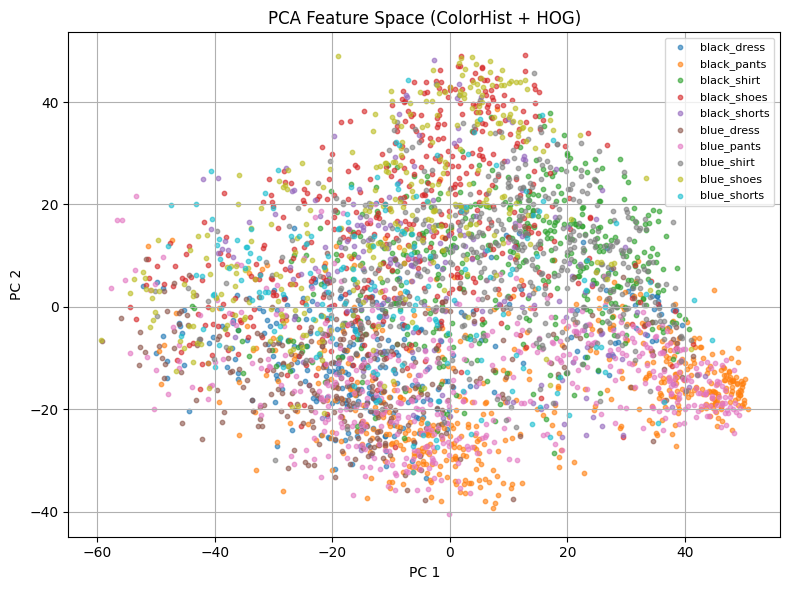

[2025-12-04 02:01:48] PCA 기반 특징 공간 시각화 완료


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------
# 1) PCA로 2차원 특징 공간 만들기
# -----------------------------------
log("PCA(2차원) 변환 시작")

pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)

log("PCA 변환 완료")
log(f"PCA 변환 후 특징 크기: {X_train_pca.shape}")

# -----------------------------------
# 2) PCA 2D 공간에서 각 클래스 분포 시각화
# -----------------------------------
def plot_pca_feature_space(X_2d, y, idx_to_label, title="PCA Feature Space (ColorHist + HOG)"):
    """
    PCA로 2차원으로 축소된 특징 공간을 클래스별로 시각화하는 함수
    """
    log("PCA 기반 특징 공간 시각화 시작")

    plt.figure(figsize=(8, 6))

    # 각 클래스별로 다른 마커로 시각화
    unique_labels = np.unique(y)
    for lbl in unique_labels:
        mask = (y == lbl)
        plt.scatter(
            X_2d[mask, 0],
            X_2d[mask, 1],
            s=10,
            label=idx_to_label[lbl],
            alpha=0.6
        )

    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(fontsize=8, loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    log("PCA 기반 특징 공간 시각화 완료")

# 실행
plot_pca_feature_space(X_train_pca, y_train, idx_to_label)


PCA 2D 상에서 로지스틱 회귀 / 선형 SVM 결정 경계 시각화(단순모델임)

[2025-12-04 02:02:40] PCA 2D용 로지스틱/선형 SVM 훈련 시작... 예상 종료시간: 02:02:41


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[2025-12-04 02:02:44] PCA 2D용 로지스틱/선형 SVM 훈련 완료
[2025-12-04 02:02:44] Decision Boundary (Logistic Regression on PCA 2D Features) 결정 경계 시각화 시작


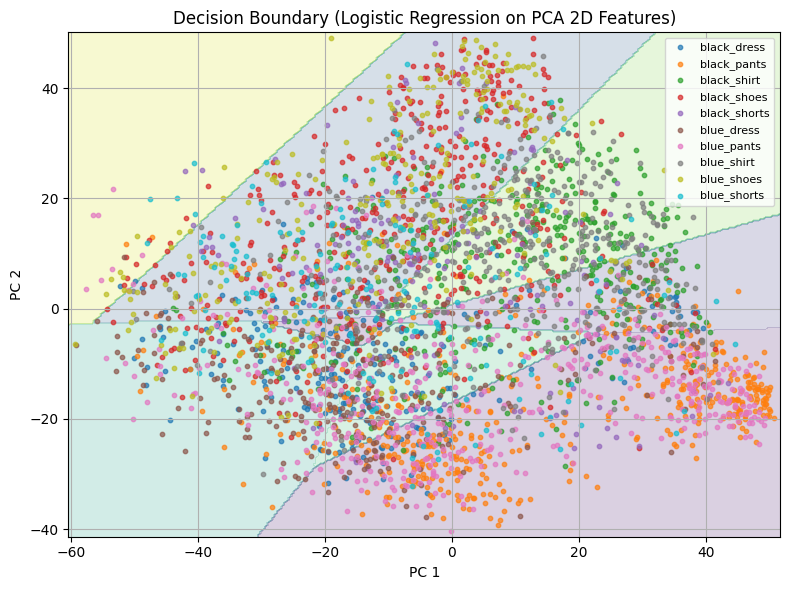

[2025-12-04 02:02:46] Decision Boundary (Logistic Regression on PCA 2D Features) 결정 경계 시각화 완료
[2025-12-04 02:02:46] Decision Boundary (Linear SVM on PCA 2D Features) 결정 경계 시각화 시작


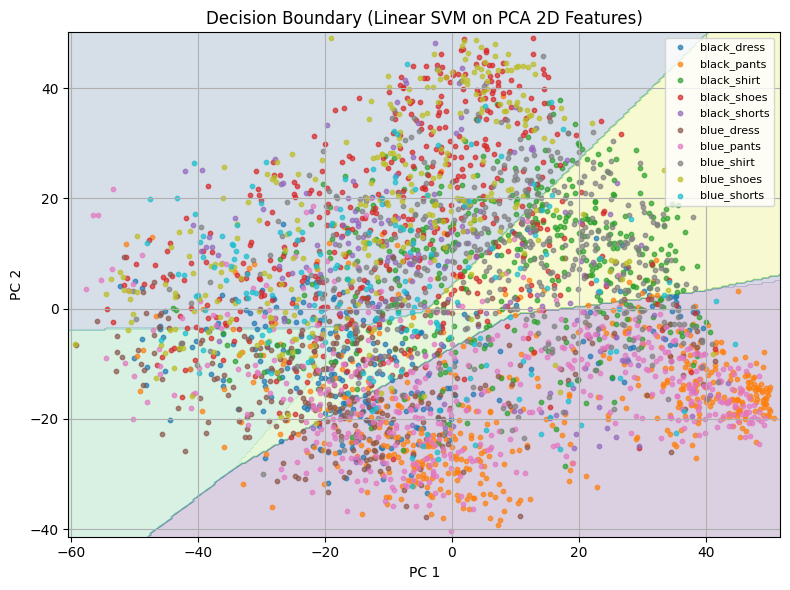

[2025-12-04 02:02:47] Decision Boundary (Linear SVM on PCA 2D Features) 결정 경계 시각화 완료


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# -----------------------------------
# 1) PCA 2D에 맞춘 로지스틱 회귀 / 선형 SVM 학습
# -----------------------------------
def train_models_on_pca2d(X_2d, y):
    # 대략적인 예상 시간 (샘플 수 기준 매우 러프하게)
    est_seconds = int(len(X_2d) * 0.00015) + 1
    eta = datetime.now() + timedelta(seconds=est_seconds)
    log(f"PCA 2D용 로지스틱/선형 SVM 훈련 시작... 예상 종료시간: {eta.strftime('%H:%M:%S')}")

    # 다중분류 로지스틱 회귀
    logreg_2d = LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1
    )
    logreg_2d.fit(X_2d, y)

    # 선형 SVM
    svm_2d = LinearSVC(
        C=1.0,
        max_iter=2000
    )
    svm_2d.fit(X_2d, y)

    log("PCA 2D용 로지스틱/선형 SVM 훈련 완료")
    return logreg_2d, svm_2d

logreg_2d, svm_2d = train_models_on_pca2d(X_train_pca, y_train)

# -----------------------------------
# 2) 결정 경계를 그리는 공통 함수
# -----------------------------------
def plot_decision_boundary(model, X_2d, y, idx_to_label, title):
    """
    2차원 특징(X_2d) 공간에서 모델의 결정 경계를 시각화
    """
    log(f"{title} 결정 경계 시각화 시작")

    x_min, x_max = X_2d[:, 0].min() - 1.0, X_2d[:, 0].max() + 1.0
    y_min, y_max = X_2d[:, 1].min() - 1.0, X_2d[:, 1].max() + 1.0

    # 격자(grid) 생성
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    # 격자점에 대한 예측
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))

    # 결정 경계 영역(contourf)
    plt.contourf(xx, yy, Z, alpha=0.2)

    # 실제 데이터 점
    unique_labels = np.unique(y)
    for lbl in unique_labels:
        mask = (y == lbl)
        plt.scatter(
            X_2d[mask, 0],
            X_2d[mask, 1],
            s=10,
            label=idx_to_label[lbl],
            alpha=0.7
        )

    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(fontsize=8, loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    log(f"{title} 결정 경계 시각화 완료")

# -----------------------------------
# 3) 로지스틱 회귀 / 선형 SVM 결정 경계 그리기
# -----------------------------------
plot_decision_boundary(
    logreg_2d,
    X_train_pca,
    y_train,
    idx_to_label,
    title="Decision Boundary (Logistic Regression on PCA 2D Features)"
)

plot_decision_boundary(
    svm_2d,
    X_train_pca,
    y_train,
    idx_to_label,
    title="Decision Boundary (Linear SVM on PCA 2D Features)"
)


- 두 모델 정량 성능 비교 바 차트 (Accuracy / Macro F1)

[2025-12-04 02:05:10] Baseline 모델 성능 비교 그래프 시각화 시작


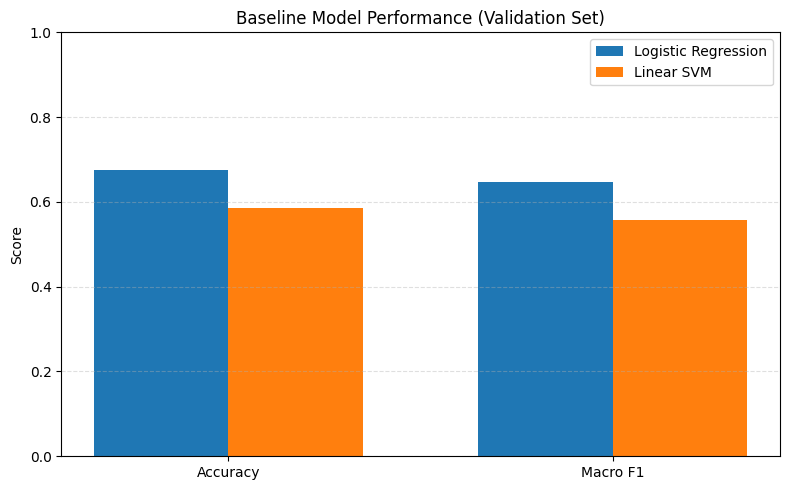

[2025-12-04 02:05:11] Baseline 모델 성능 비교 그래프 시각화 완료


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 로지스틱 회귀 vs 선형 SVM 성능 비교 그래프 함수
# -------------------------------------------------------
def plot_model_performance(log_reg_acc, log_reg_f1, svm_acc, svm_f1):
    # 콘솔 로그
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] Baseline 모델 성능 비교 그래프 시각화 시작")

    metrics = ["Accuracy", "Macro F1"]
    logistic_scores = [log_reg_acc, log_reg_f1]
    svm_scores = [svm_acc, svm_f1]

    x = np.arange(len(metrics))
    width = 0.35  # 막대 너비

    plt.figure(figsize=(8,5))

    # 막대 그래프
    plt.bar(x - width/2, logistic_scores, width, label="Logistic Regression")
    plt.bar(x + width/2, svm_scores,     width, label="Linear SVM")

    plt.xticks(x, metrics)
    plt.ylabel("Score")
    plt.title("Baseline Model Performance (Validation Set)")
    plt.ylim(0, 1.0)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] Baseline 모델 성능 비교 그래프 시각화 완료")


# -------------------------------------
# 실행
# -------------------------------------
plot_model_performance(log_reg_acc, log_reg_f1, svm_acc, svm_f1)


### 그래프 해석

>색 히스토그램 + HOG 기반 baseline에서 로지스틱 회귀는 Macro F1,Accuracy 기준 모두  선형 SVM 보다 다소 우수한 성능을 보였다. 그러나 두 모델 모두 전통적 머신러닝 기반 접근이라는 한계로 인해 이미지의 복잡한 패턴을 충분히 학습하기 어렵다. 따라서 본 문제를 보다 효과적으로 해결하기 위해서는 이후 단계에서 CNN 기반 전이학습 모델로의 전환이 필요함을 시사한다.

Test 세트 평가 + Confusion Matrix 시각화 (두 모델)

[2025-12-04 02:07:43] Test 세트 평가 시작 (로지스틱 회귀)
[2025-12-04 02:07:43] 로지스틱 회귀 Test 정확도: 0.6714, Macro F1: 0.6443
[2025-12-04 02:07:43] Test 세트 평가 시작 (선형 SVM)
[2025-12-04 02:07:43] 선형 SVM Test 정확도: 0.5746, Macro F1: 0.5400
[2025-12-04 02:07:43] Confusion Matrix - Logistic Regression (Test Set) - Confusion Matrix 계산 및 시각화 시작


<Figure size 800x600 with 0 Axes>

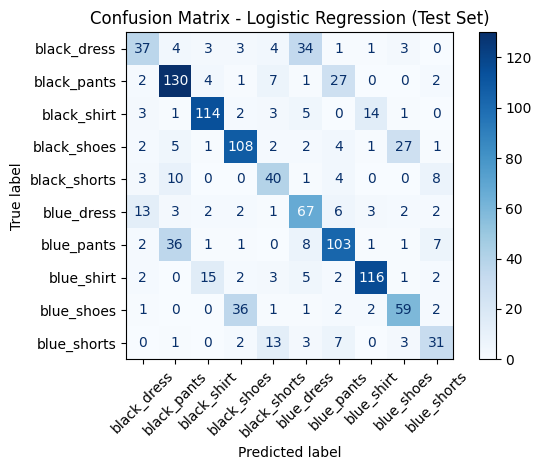

[2025-12-04 02:07:44] Confusion Matrix - Logistic Regression (Test Set) - Confusion Matrix 시각화 완료
[2025-12-04 02:07:44] Confusion Matrix - Linear SVM (Test Set) - Confusion Matrix 계산 및 시각화 시작


<Figure size 800x600 with 0 Axes>

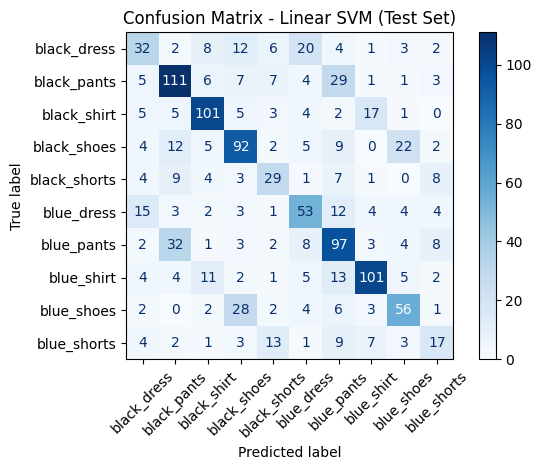

[2025-12-04 02:07:45] Confusion Matrix - Linear SVM (Test Set) - Confusion Matrix 시각화 완료


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# 혹시 이전에 log 함수가 없다면 다시 정의
from datetime import datetime
def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

# -----------------------------
# 1) Test 세트에서 두 모델 평가
# -----------------------------
log("Test 세트 평가 시작 (로지스틱 회귀)")

y_pred_test_logreg = log_reg_model.predict(X_test_scaled)
test_acc_logreg = accuracy_score(y_test, y_pred_test_logreg)
test_f1_logreg = f1_score(y_test, y_pred_test_logreg, average="macro")

log(f"로지스틱 회귀 Test 정확도: {test_acc_logreg:.4f}, Macro F1: {test_f1_logreg:.4f}")

log("Test 세트 평가 시작 (선형 SVM)")

y_pred_test_svm = svm_model.predict(X_test_scaled)
test_acc_svm = accuracy_score(y_test, y_pred_test_svm)
test_f1_svm = f1_score(y_test, y_pred_test_svm, average="macro")

log(f"선형 SVM Test 정확도: {test_acc_svm:.4f}, Macro F1: {test_f1_svm:.4f}")

# -----------------------------
# 2) Confusion Matrix 시각화 함수
# -----------------------------
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """
    y_true, y_pred: 정수 인덱스 라벨 벡터
    labels: 정수 인덱스를 클래스 이름으로 바꿀 때 사용할 리스트 (정렬된 클래스명 목록)
    """
    log(f"{title} - Confusion Matrix 계산 및 시각화 시작")

    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    log(f"{title} - Confusion Matrix 시각화 완료")


# 정렬된 클래스 이름 리스트 (이미 앞에서 labels = sorted(df_images["label"].unique()) 썼었다고 가정)
# 만약 없다면 아래처럼 다시 만들면 됨:
# labels = sorted(df_images["label"].unique())

# -----------------------------
# 3) 두 모델 Confusion Matrix 그리기
# -----------------------------
plot_confusion_matrix(
    y_test,
    y_pred_test_logreg,
    labels=labels,
    title="Confusion Matrix - Logistic Regression (Test Set)"
)

plot_confusion_matrix(
    y_test,
    y_pred_test_svm,
    labels=labels,
    title="Confusion Matrix - Linear SVM (Test Set)"
)


### Confusion Matrix 해석

>Confusion Matrix를 보면 두 모델 모두에서 shoes·shirt·pants 계열 클래스는 대각선 값이 높고 색이 진해 비교적 안정적으로 분류되는 반면, shorts와 dress 클래스는 대각선이 상대적으로 옅고 shorts는 pants로, shoes는 유사 색상의 다른 신발·의류 클래스로 예측되는 사례가 많아, 전통적 특징 기반 모델이 가지는 표현력의 한계를 보여준다. 이러한 결과는 이미지 내 구조적·질감적 정보를 더 깊게 학습할 수 있는 CNN 기반 모델로의 전환 필요성을 다시 한 번 시사한다.

예측 실패 사례 시각화 (오분류 이미지 모음)

[2025-12-04 02:12:34] 로지스틱 회귀 기준 오분류 사례 탐색 시작
[2025-12-04 02:12:34] 로지스틱 회귀 기준 총 오분류 개수: 394
[2025-12-04 02:12:34] 시각화에 사용할 로지스틱 회귀 오분류 샘플 수: 12
[2025-12-04 02:12:34] Logistic Regression 오분류 이미지 시각화 시작


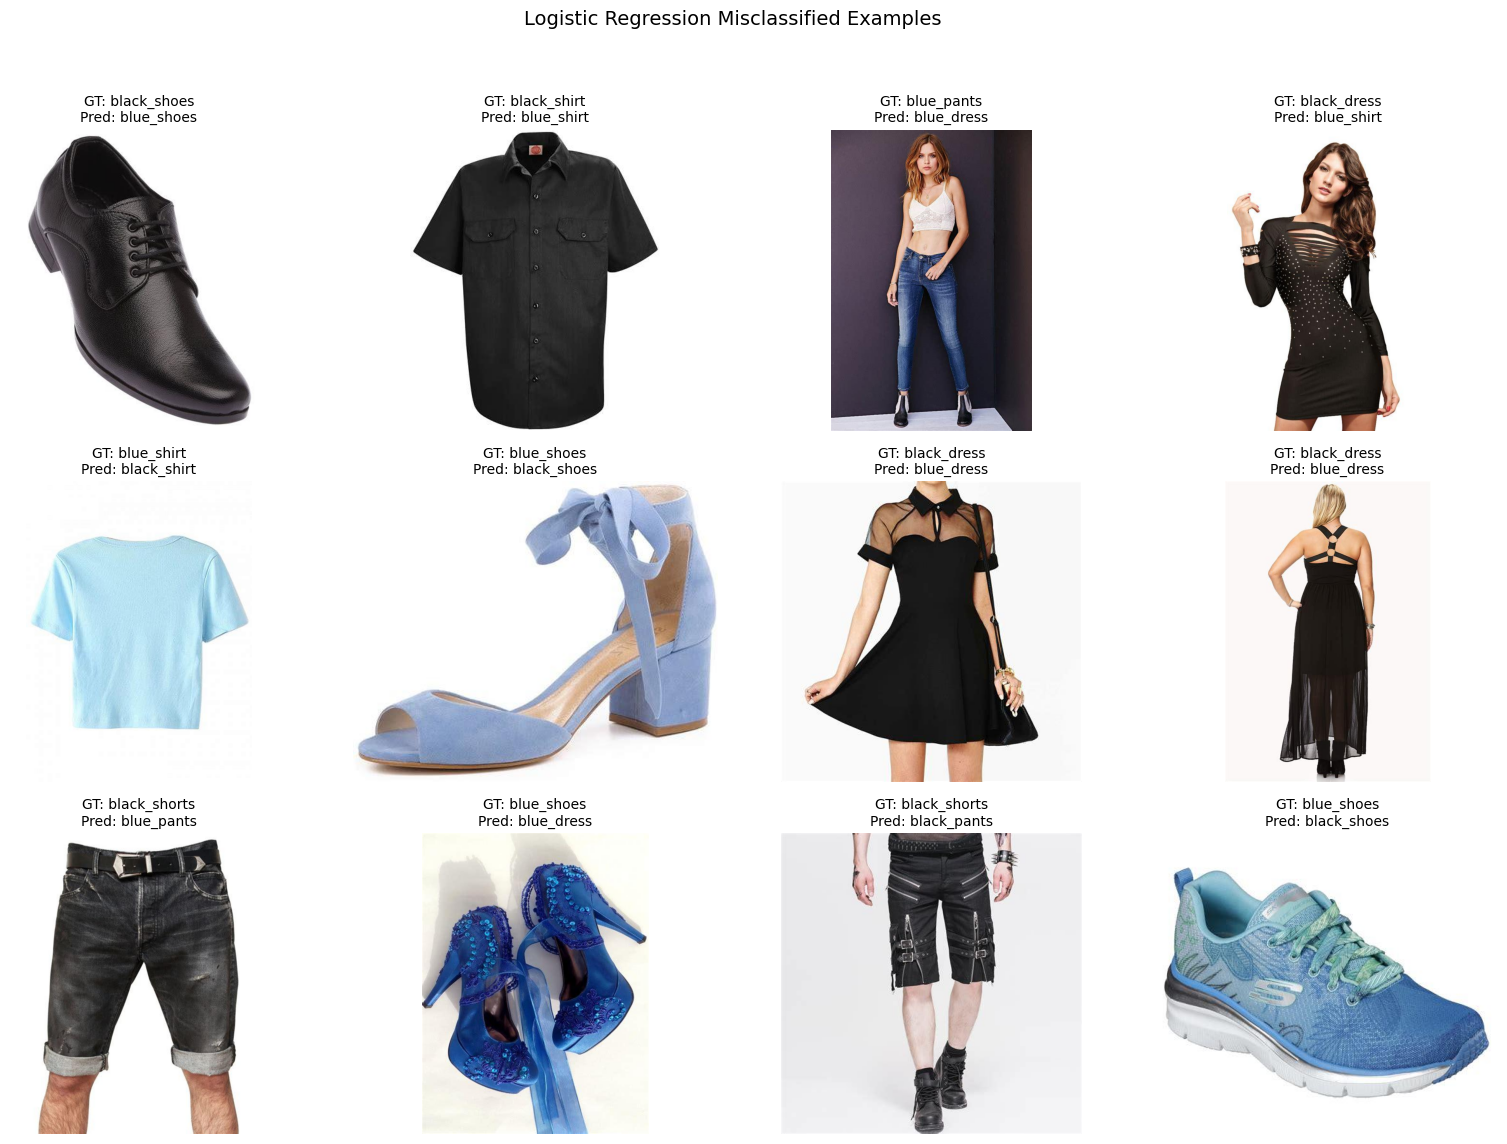

[2025-12-04 02:12:37] Logistic Regression 오분류 이미지 시각화 완료


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from datetime import datetime


# ----------------------------------
# 1) 로지스틱 회귀 기준 오분류 인덱스 찾기
# ----------------------------------
log("로지스틱 회귀 기준 오분류 사례 탐색 시작")

mis_idx_logreg = np.where(y_pred_test_logreg != y_test)[0]
log(f"로지스틱 회귀 기준 총 오분류 개수: {len(mis_idx_logreg)}")

# 너무 많으면 상위 N개만 시각화 (예: 12개)
N_ERROR_SAMPLES = 12
mis_idx_logreg_sample = mis_idx_logreg[:N_ERROR_SAMPLES]

log(f"시각화에 사용할 로지스틱 회귀 오분류 샘플 수: {len(mis_idx_logreg_sample)}")

# ----------------------------------
# 2) 오분류 이미지 시각화 함수 (재사용 가능)
# ----------------------------------
def show_misclassified_images(df_test, indices, y_true, y_pred, idx_to_label, n_cols=4, title_prefix=""):
    """
    df_test  : test_df (filepath, label 포함 DataFrame)
    indices  : 오분류 인덱스 리스트 (y_true / y_pred 기준 인덱스)
    y_true   : 정수 인덱스 라벨 벡터 (GT)
    y_pred   : 정수 인덱스 라벨 벡터 (모델 예측값)
    idx_to_label: 정수 → 라벨 문자열 매핑 dict
    n_cols   : 한 행에 표시할 이미지 개수
    title_prefix : 그래프 상단에 표시할 타이틀 접두사 (예: "Logistic Regression")
    """
    log(f"{title_prefix} 오분류 이미지 시각화 시작")

    n_samples = len(indices)
    if n_samples == 0:
        log("오분류 샘플이 없어 시각화할 이미지가 없습니다.")
        return

    n_rows = math.ceil(n_samples / n_cols)

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))

    for i, idx in enumerate(indices):
        row = df_test.iloc[idx]
        img_path = row["filepath"]
        true_label = idx_to_label[int(y_true[idx])]
        pred_label = idx_to_label[int(y_pred[idx])]

        # 이미지 로딩
        img = Image.open(img_path).convert("RGB")

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"GT: {true_label}\nPred: {pred_label}", fontsize=10)

    plt.suptitle(f"{title_prefix} Misclassified Examples", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    log(f"{title_prefix} 오분류 이미지 시각화 완료")

# ----------------------------------
# 3) 로지스틱 회귀 오분류 이미지 표시
# ----------------------------------
show_misclassified_images(
    df_test=test_df,
    indices=mis_idx_logreg_sample,
    y_true=y_test,
    y_pred=y_pred_test_logreg,
    idx_to_label=idx_to_label,
    n_cols=4,
    title_prefix="Logistic Regression"
)


[2025-12-04 02:08:29] 선형 SVM 기준 오분류 사례 탐색 시작
[2025-12-04 02:08:29] 총 오분류 개수: 510
[2025-12-04 02:08:29] 시각화에 사용할 오분류 샘플 수: 12
[2025-12-04 02:08:29] 오분류 이미지 시각화 시작


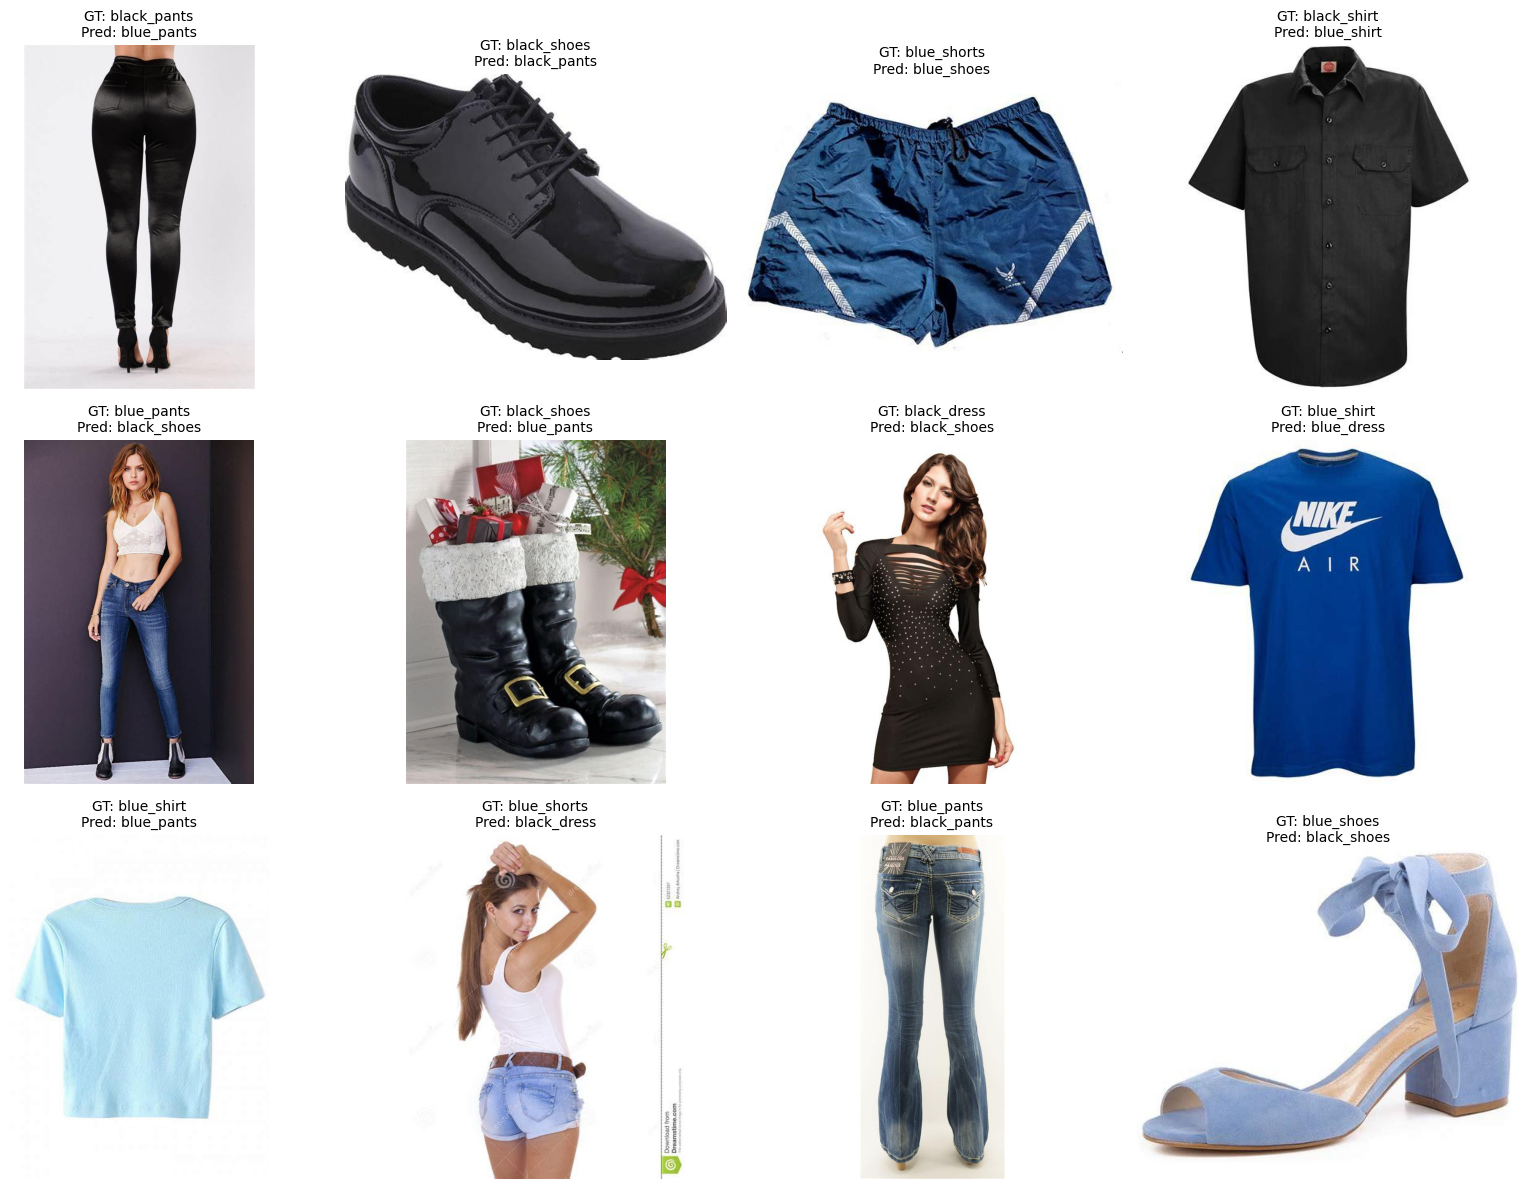

[2025-12-04 02:08:32] 오분류 이미지 시각화 완료


In [ ]:
from PIL import Image
import math

# -----------------------------
# 1) 오분류 인덱스 찾기
# -----------------------------
log("선형 SVM 기준 오분류 사례 탐색 시작")

mis_idx = np.where(y_pred_test_svm != y_test)[0]
log(f"총 오분류 개수: {len(mis_idx)}")

# 너무 많으면 상위 N개만 시각화 (예: 12개)
N_ERROR_SAMPLES = 12
mis_idx_sample = mis_idx[:N_ERROR_SAMPLES]

log(f"시각화에 사용할 오분류 샘플 수: {len(mis_idx_sample)}")

# -----------------------------
# 2) 오분류 이미지 시각화 함수
# -----------------------------
def show_misclassified_images(df_test, indices, y_true, y_pred, idx_to_label, n_cols=4):
    """
    df_test  : test_df (filepath, label 포함)
    indices  : 오분류 인덱스 리스트 (y_true/y_pred와 동일 기준)
    y_true   : 정수 인덱스 라벨 벡터
    y_pred   : 정수 인덱스 라벨 벡터
    idx_to_label: 정수 → 라벨 문자열 매핑 dict
    n_cols   : 한 행에 그릴 이미지 개수
    """
    log("오분류 이미지 시각화 시작")

    n_samples = len(indices)
    n_cols = n_cols
    n_rows = math.ceil(n_samples / n_cols)

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))

    for i, idx in enumerate(indices):
        row = df_test.iloc[idx]
        img_path = row["filepath"]
        true_label = idx_to_label[int(y_true[idx])]
        pred_label = idx_to_label[int(y_pred[idx])]

        # 이미지 로딩
        img = Image.open(img_path).convert("RGB")

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"GT: {true_label}\nPred: {pred_label}", fontsize=10)

    plt.tight_layout()
    plt.show()

    log("오분류 이미지 시각화 완료")


# -----------------------------
# 3) 실제 오분류 이미지 표시
# -----------------------------
show_misclassified_images(
    df_test=test_df,
    indices=mis_idx_sample,
    y_true=y_test,
    y_pred=y_pred_test_svm,
    idx_to_label=idx_to_label,
    n_cols=4
)


- 장비 설정 & 모델 설계 (ResNet-18 전이학습)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from datetime import datetime, timedelta

# --------------------------------
# 공통 로그 함수 (이미 있으면 생략 가능)
# --------------------------------
def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

# --------------------------------
# GPU/CPU 장비 설정
# --------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log(f"사용 중인 device: {device}")

# --------------------------------
# ResNet-18 전이학습 모델 생성 함수
# --------------------------------
def create_resnet18_model(num_classes, freeze_backbone=False):
    """
    num_classes: 분류할 클래스 수
    freeze_backbone: True이면 백본(특징 추출부) 가중치를 고정하고 마지막 FC만 학습
    """
    log("ResNet-18 사전학습(pretrained) 모델 불러오는 중...")

    # ImageNet으로 학습된 ResNet-18 불러오기
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # 마지막 FC 레이어를 우리 데이터셋 클래스 수에 맞게 교체
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    if freeze_backbone:
        log("백본(FC 이전 레이어) 가중치 동결(freeze)...")
        for name, param in model.named_parameters():
            if not name.startswith("fc."):  # fc 레이어만 학습
                param.requires_grad = False

    model = model.to(device)
    log("ResNet-18 모델 생성 완료")
    return model

num_classes = len(labels)  # labels = sorted(df_images["label"].unique()) 라고 가정
model_cnn = create_resnet18_model(num_classes=num_classes, freeze_backbone=False)


[2025-12-04 02:16:30] 사용 중인 device: cpu
[2025-12-04 02:16:30] ResNet-18 사전학습(pretrained) 모델 불러오는 중...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 64.4MB/s]


[2025-12-04 02:16:32] ResNet-18 모델 생성 완료


학습/검증 루프 + Early Stopping 구현

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# --------------------------------
# 한 epoch 학습 함수
# --------------------------------
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # 예측값 저장
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    epoch_acc = accuracy_score(all_targets, all_preds)
    epoch_f1 = f1_score(all_targets, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_f1

# --------------------------------
# 검증/테스트 평가 함수
# --------------------------------
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    epoch_acc = accuracy_score(all_targets, all_preds)
    epoch_f1 = f1_score(all_targets, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_f1, all_preds, all_targets


CNN 학습 실행 (Epoch 5~10 + Early Stopping)

In [ ]:
# --------------------------------
# 학습 관련 하이퍼파라미터 설정
# --------------------------------
max_epochs = 8           # 5~10 사이에서 적절하게 선택
patience = 2             # Early stopping patience (연속 2번 개선 없으면 종료)
lr = 1e-4
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=lr, weight_decay=weight_decay)

# --------------------------------
# Early Stopping 관련 변수 초기화
# --------------------------------
best_val_loss = float("inf")
best_epoch = -1
best_state_dict = None
no_improve_count = 0

# --------------------------------
# 대략적인 훈련 예상 시간 계산 (매우 러프하게: 1 epoch당 0.3초 * (train_steps) 로 가정)
# 실제 시간과 다를 수 있지만 "예상" 로그 용도
# --------------------------------
num_train_steps = len(train_loader)
est_total_seconds = int(max_epochs * num_train_steps * 0.3) + 1
eta_total = datetime.now() + timedelta(seconds=est_total_seconds)
log(f"CNN 학습 시작... 최대 Epoch: {max_epochs}, EarlyStopping Patience: {patience}")
log(f"대략적인 전체 학습 예상 종료시간: {eta_total.strftime('%H:%M:%S')}")

# --------------------------------
# Epoch 루프
# --------------------------------
for epoch in range(1, max_epochs + 1):
    log(f"===== Epoch {epoch}/{max_epochs} 시작 =====")

    # 각 epoch별 예상 종료시간 (epoch 단위 대략 추정)
    est_epoch_seconds = int(num_train_steps * 0.3) + 1
    eta_epoch = datetime.now() + timedelta(seconds=est_epoch_seconds)
    log(f"해당 Epoch 예상 종료시간 (대략): {eta_epoch.strftime('%H:%M:%S')}")

    # 1) Train
    train_loss, train_acc, train_f1 = train_one_epoch(
        model_cnn, train_loader, criterion, optimizer, device
    )
    log(f"[Train] Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Macro F1: {train_f1:.4f}")

    # 2) Validation
    val_loss, val_acc, val_f1, _, _ = evaluate(
        model_cnn, val_loader, criterion, device
    )
    log(f"[Val]   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Macro F1: {val_f1:.4f}")

    # 3) Early Stopping 체크 (val_loss 기준)
    if val_loss < best_val_loss:
        log(f"Validation Loss 개선! {best_val_loss:.4f} → {val_loss:.4f} (모델 저장)")
        best_val_loss = val_loss
        best_epoch = epoch
        best_state_dict = model_cnn.state_dict()
        no_improve_count = 0
    else:
        no_improve_count += 1
        log(f"Validation Loss 개선 없음. no_improve_count = {no_improve_count}")

    if no_improve_count >= patience:
        log(f"Early Stopping 발동 (연속 {patience} Epoch 개선 없음). 학습 종료.")
        break

log(f"CNN 학습 종료. 가장 성능이 좋았던 Epoch: {best_epoch}")


[2025-12-04 02:17:05] CNN 학습 시작... 최대 Epoch: 8, EarlyStopping Patience: 2
[2025-12-04 02:17:05] 대략적인 전체 학습 예상 종료시간: 02:21:37
[2025-12-04 02:17:05] ===== Epoch 1/8 시작 =====
[2025-12-04 02:17:05] 해당 Epoch 예상 종료시간 (대략): 02:17:39


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 02:36:01] [Train] Loss: 0.4870, Acc: 0.8684, Macro F1: 0.8683


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 02:38:00] [Val]   Loss: 0.1409, Acc: 0.9583, Macro F1: 0.9505
[2025-12-04 02:38:00] Validation Loss 개선! inf → 0.1409 (모델 저장)
[2025-12-04 02:38:00] ===== Epoch 2/8 시작 =====
[2025-12-04 02:38:00] 해당 Epoch 예상 종료시간 (대략): 02:38:34


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 02:55:40] [Train] Loss: 0.1338, Acc: 0.9688, Macro F1: 0.9685


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 02:57:32] [Val]   Loss: 0.1011, Acc: 0.9683, Macro F1: 0.9625
[2025-12-04 02:57:32] Validation Loss 개선! 0.1409 → 0.1011 (모델 저장)
[2025-12-04 02:57:32] ===== Epoch 3/8 시작 =====
[2025-12-04 02:57:32] 해당 Epoch 예상 종료시간 (대략): 02:58:06


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 03:15:04] [Train] Loss: 0.0815, Acc: 0.9800, Macro F1: 0.9799


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 03:17:02] [Val]   Loss: 0.0930, Acc: 0.9741, Macro F1: 0.9713
[2025-12-04 03:17:02] Validation Loss 개선! 0.1011 → 0.0930 (모델 저장)
[2025-12-04 03:17:02] ===== Epoch 4/8 시작 =====
[2025-12-04 03:17:02] 해당 Epoch 예상 종료시간 (대략): 03:17:36


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 03:34:33] [Train] Loss: 0.0656, Acc: 0.9808, Macro F1: 0.9807


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 03:36:30] [Val]   Loss: 0.1162, Acc: 0.9566, Macro F1: 0.9489
[2025-12-04 03:36:30] Validation Loss 개선 없음. no_improve_count = 1
[2025-12-04 03:36:30] ===== Epoch 5/8 시작 =====
[2025-12-04 03:36:30] 해당 Epoch 예상 종료시간 (대략): 03:37:04


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 03:54:06] [Train] Loss: 0.0508, Acc: 0.9869, Macro F1: 0.9870


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 03:56:05] [Val]   Loss: 0.0712, Acc: 0.9783, Macro F1: 0.9764
[2025-12-04 03:56:05] Validation Loss 개선! 0.0930 → 0.0712 (모델 저장)
[2025-12-04 03:56:05] ===== Epoch 6/8 시작 =====
[2025-12-04 03:56:05] 해당 Epoch 예상 종료시간 (대략): 03:56:39


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 04:13:39] [Train] Loss: 0.0330, Acc: 0.9917, Macro F1: 0.9918


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 04:15:38] [Val]   Loss: 0.0769, Acc: 0.9791, Macro F1: 0.9743
[2025-12-04 04:15:38] Validation Loss 개선 없음. no_improve_count = 1
[2025-12-04 04:15:38] ===== Epoch 7/8 시작 =====
[2025-12-04 04:15:38] 해당 Epoch 예상 종료시간 (대략): 04:16:12


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 04:33:32] [Train] Loss: 0.0308, Acc: 0.9903, Macro F1: 0.9903


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 04:35:30] [Val]   Loss: 0.0796, Acc: 0.9716, Macro F1: 0.9640
[2025-12-04 04:35:30] Validation Loss 개선 없음. no_improve_count = 2
[2025-12-04 04:35:30] Early Stopping 발동 (연속 2 Epoch 개선 없음). 학습 종료.
[2025-12-04 04:35:30] CNN 학습 종료. 가장 성능이 좋았던 Epoch: 5


최적 모델 로드 + Test 세트 평가

In [ ]:
# --------------------------------
# 최적 모델 가중치 로드
# --------------------------------
if best_state_dict is not None:
    log("Best Epoch의 모델 가중치를 로드합니다.")
    model_cnn.load_state_dict(best_state_dict)
else:
    log("주의: best_state_dict가 비어있습니다. (초기 상태 그대로일 수 있음)")

# --------------------------------
# Test 세트 평가
# --------------------------------
log("CNN 모델 Test 세트 평가 시작")

test_loss_cnn, test_acc_cnn, test_f1_cnn, y_pred_test_cnn, y_test_cnn = evaluate(
    model_cnn, test_loader, criterion, device
)

log(f"[CNN Test] Loss: {test_loss_cnn:.4f}, Acc: {test_acc_cnn:.4f}, Macro F1: {test_f1_cnn:.4f}")


[2025-12-04 04:36:06] Best Epoch의 모델 가중치를 로드합니다.
[2025-12-04 04:36:06] CNN 모델 Test 세트 평가 시작


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[2025-12-04 04:38:25] [CNN Test] Loss: 0.1099, Acc: 0.9691, Macro F1: 0.9679


CNN Confusion Matrix 시각화

[2025-12-04 04:39:35] Confusion Matrix - CNN (ResNet18, Test Set) - Confusion Matrix 계산 시작
[2025-12-04 04:39:35] Confusion Matrix - CNN (ResNet18, Test Set) - Confusion Matrix 시각화 시작


<Figure size 800x600 with 0 Axes>

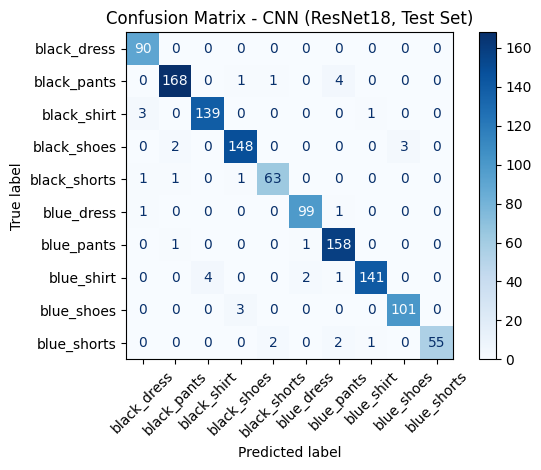

[2025-12-04 04:39:37] Confusion Matrix - CNN (ResNet18, Test Set) - Confusion Matrix 시각화 완료


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ---------------------------------------
# CNN Confusion Matrix 시각화 함수
# ---------------------------------------
def plot_cnn_confusion_matrix(y_true, y_pred, labels, title):
    """
    y_true, y_pred : 정수 인덱스 클래스 벡터 (numpy array)
    labels         : 클래스 이름 리스트 (문자열)
    """
    log(f"{title} - Confusion Matrix 계산 시작")

    # Confusion Matrix 계산
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    log(f"{title} - Confusion Matrix 시각화 시작")

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    log(f"{title} - Confusion Matrix 시각화 완료")


# ---------------------------------------
# 실행: CNN Test Confusion Matrix
# ---------------------------------------
plot_cnn_confusion_matrix(
    y_true=y_test_cnn,
    y_pred=y_pred_test_cnn,
    labels=labels,
    title="Confusion Matrix - CNN (ResNet18, Test Set)"
)


### Confusion Matrix 해석 – CNN(ResNet18)

>CNN 기반 전이학습 모델(ResNet18)은 전통적 ML 모델 대비 전반적으로 훨씬 높은 대각선 정확도를 보이며 대부분의 클래스에서 안정적인 분류 성능을 나타냈다. dress, shirt, pants, shoes 등 주요 카테고리는 대각선 값이 매우 높고 오분류 비율이 낮아, 복잡한 형태·윤곽·텍스처 정보를 효과적으로 학습했음을 확인할 수 있다.
>
>특히 shorts·shoes와 같이 기존 모델(Logistic, SVM)에서 오분류가 잦았던 클래스들도 CNN에서는 대각선 색이 뚜렷하게 강화되었으며, 상호 간 오분류가 크게 감소하였다. 이는 CNN이 색상뿐 아니라 의류의 세밀한 모양·패턴·구조적 특징을 학습하여 클래스 간 차이를 더욱 정확하게 구분할 수 있음을 시사한다.


CNN 오분류 이미지 모음(예측 실패 사례 시각화)

[2025-12-04 04:39:49] CNN 기준 오분류 사례 탐색 시작
[2025-12-04 04:39:49] CNN 기준 총 오분류 개수: 37
[2025-12-04 04:39:49] 시각화에 사용할 CNN 오분류 샘플 수: 12
[2025-12-04 04:39:49] CNN (ResNet18) 오분류 이미지 시각화 시작


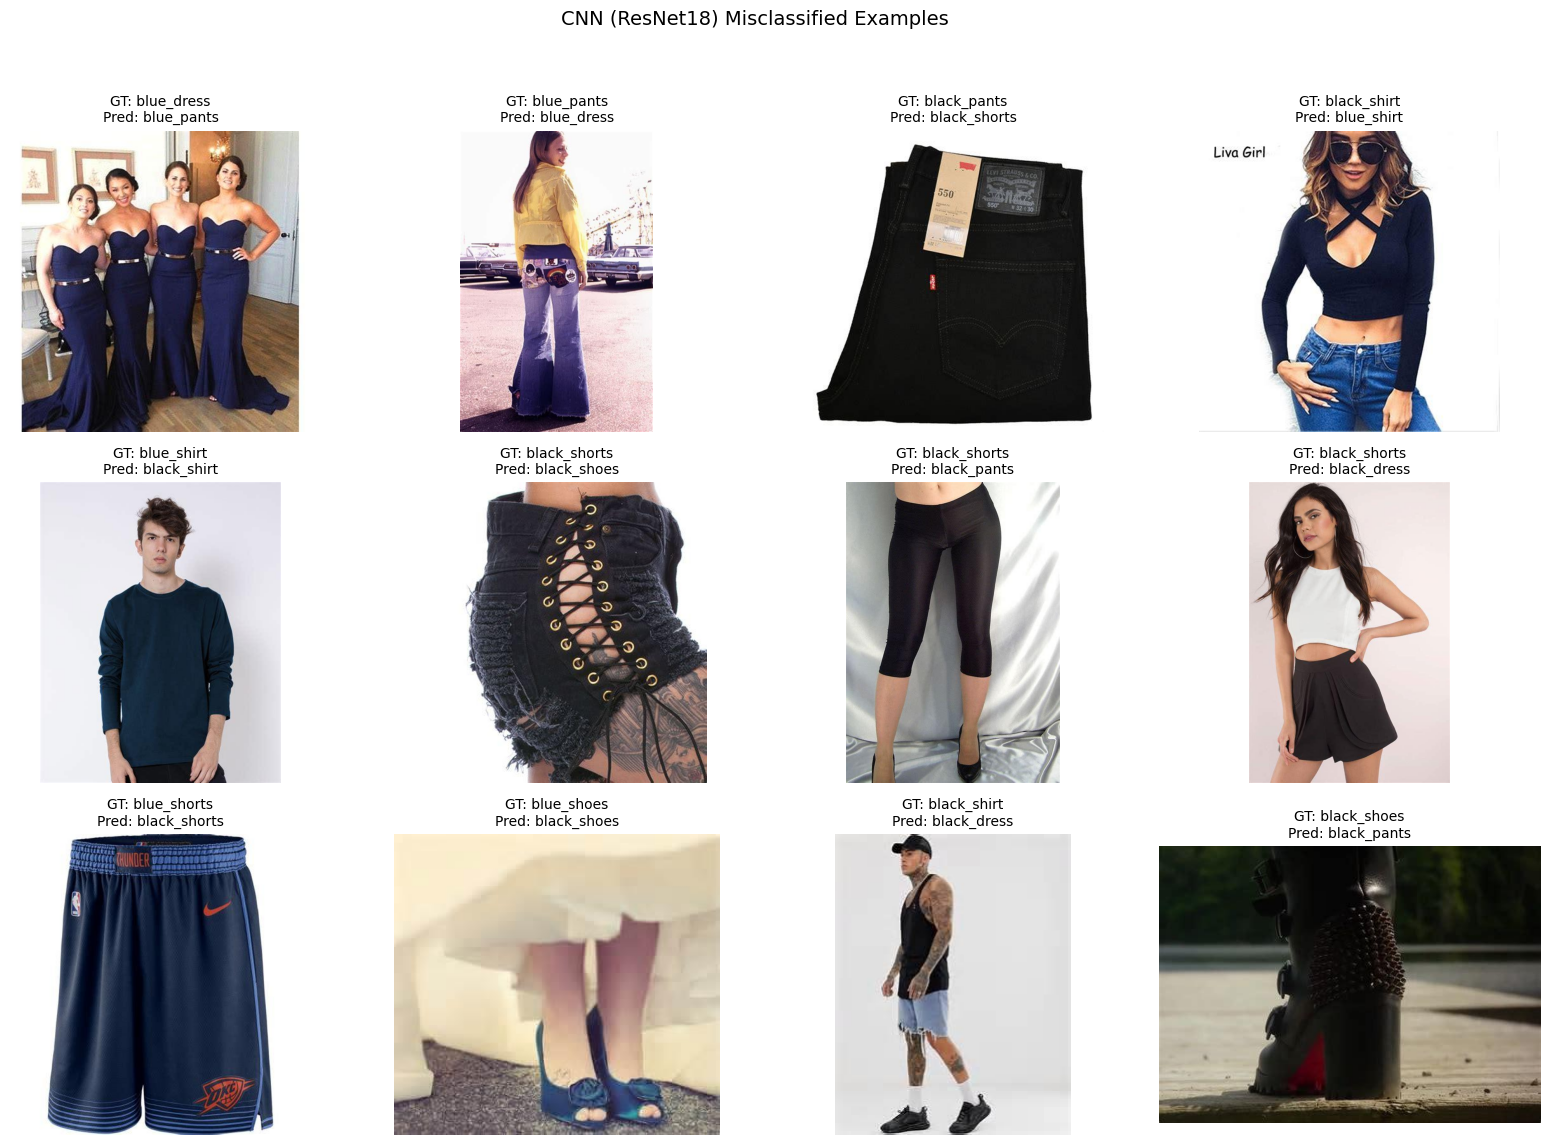

[2025-12-04 04:39:51] CNN (ResNet18) 오분류 이미지 시각화 완료


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from datetime import datetime

# log 함수가 없다면 재정의 (있으면 생략 가능)
def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

# ---------------------------------------
# 1) CNN 오분류 인덱스 찾기
# ---------------------------------------
log("CNN 기준 오분류 사례 탐색 시작")

mis_idx_cnn = np.where(y_pred_test_cnn != y_test_cnn)[0]
log(f"CNN 기준 총 오분류 개수: {len(mis_idx_cnn)}")

# 너무 많으면 상위 N개만 시각화 (예: 12개)
N_ERROR_SAMPLES = 12
mis_idx_cnn_sample = mis_idx_cnn[:N_ERROR_SAMPLES]

log(f"시각화에 사용할 CNN 오분류 샘플 수: {len(mis_idx_cnn_sample)}")

# ---------------------------------------
# 2) 오분류 이미지 시각화 공통 함수
# ---------------------------------------
def show_misclassified_images(df_test, indices, y_true, y_pred, idx_to_label,
                              n_cols=4, title_prefix=""):
    """
    df_test    : test_df (filepath, label 포함 DataFrame)
    indices    : 오분류 인덱스 리스트 (y_true / y_pred 기준 인덱스)
    y_true     : 정답 라벨 (정수 인덱스, numpy array)
    y_pred     : 예측 라벨 (정수 인덱스, numpy array)
    idx_to_label : 정수 → 문자열 라벨 매핑 dict
    n_cols     : 한 줄에 표시할 이미지 개수
    title_prefix : 타이틀 접두어 (예: "CNN (ResNet18)")
    """
    log(f"{title_prefix} 오분류 이미지 시각화 시작")

    n_samples = len(indices)
    if n_samples == 0:
        log("오분류 샘플이 없어 시각화할 이미지가 없습니다.")
        return

    n_rows = math.ceil(n_samples / n_cols)

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))

    for i, idx in enumerate(indices):
        # test_df는 Dataset 생성 시점에 reset_index 했다고 가정
        row = test_df.iloc[idx]
        img_path = row["filepath"]
        gt_label = idx_to_label[int(y_true[idx])]
        pred_label = idx_to_label[int(y_pred[idx])]

        # 이미지 로딩
        img = Image.open(img_path).convert("RGB")

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"GT: {gt_label}\nPred: {pred_label}", fontsize=10)

    plt.suptitle(f"{title_prefix} Misclassified Examples", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    log(f"{title_prefix} 오분류 이미지 시각화 완료")


# ---------------------------------------
# 3) CNN 오분류 이미지 시각화 실행
# ---------------------------------------
show_misclassified_images(
    df_test=test_df,
    indices=mis_idx_cnn_sample,
    y_true=y_test_cnn,
    y_pred=y_pred_test_cnn,
    idx_to_label=idx_to_label,
    n_cols=4,
    title_prefix="CNN (ResNet18)"
)


### **모델 비교 & 최종 선택**

- Baseline vs CNN 성능 비교 바 차트 (Test 기준)

[2025-12-04 04:38:57] Baseline + CNN 모델 성능 비교 그래프 시각화 시작


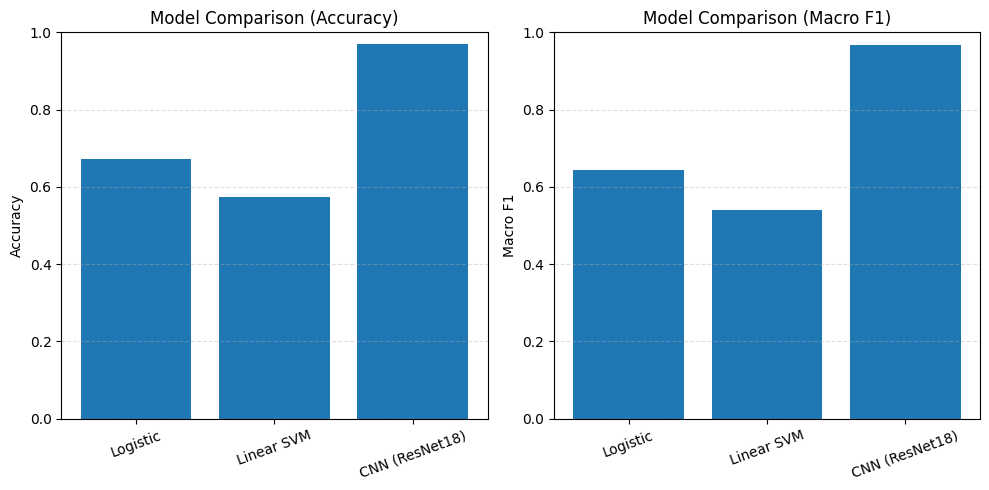

[2025-12-04 04:38:57] Baseline + CNN 모델 성능 비교 그래프 시각화 완료


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_model_performance(
    logreg_acc, logreg_f1,
    svm_acc, svm_f1,
    cnn_acc, cnn_f1
):
    """
    로지스틱 회귀, 선형 SVM, CNN의 Accuracy/Macro F1을 한 번에 비교하는 바 차트
    """
    log("Baseline + CNN 모델 성능 비교 그래프 시각화 시작")

    models = ["Logistic", "Linear SVM", "CNN (ResNet18)"]
    acc_scores = [logreg_acc, svm_acc, cnn_acc]
    f1_scores  = [logreg_f1, svm_f1, cnn_f1]

    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(10, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.bar(x, acc_scores)
    plt.xticks(x, models, rotation=20)
    plt.ylim(0, 1.0)
    plt.ylabel("Accuracy")
    plt.title("Model Comparison (Accuracy)")
    plt.grid(axis="y", linestyle="--", alpha=0.4)

    # Macro F1
    plt.subplot(1, 2, 2)
    plt.bar(x, f1_scores)
    plt.xticks(x, models, rotation=20)
    plt.ylim(0, 1.0)
    plt.ylabel("Macro F1")
    plt.title("Model Comparison (Macro F1)")
    plt.grid(axis="y", linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()

    log("Baseline + CNN 모델 성능 비교 그래프 시각화 완료")


# 실행 (앞에서 구한 Test 성능 변수 사용)
plot_all_model_performance(
    test_acc_logreg, test_f1_logreg,
    test_acc_svm,    test_f1_svm,
    test_acc_cnn,    test_f1_cnn
)


###  Baseline(Logistic, SVM) + CNN 모델 성능 비교 그래프  
>CNN(ResNet18)은 Accuracy와 Macro F1 모두에서 전통적 모델(Logistic, SVM)을 크게 상회하며 가장 높은 성능을 기록했다.
로지스틱 회귀는 두 베이스라인 중 상대적으로 우수했으나, CNN과는 상당한 성능 격차가 존재한다.
이는 본 문제에서 심층 신경망 기반 이미지 특징 학습이 필수적임을 명확하게 보여준다.

- Baseline(로지스틱 회귀) vs CNN(ResNet-18) 성능 비교

클래스별 Precision / Recall 계산

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
from datetime import datetime

def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

# ------------------------------------
# 1) 로지스틱 회귀 - 클래스별 P/R
# ------------------------------------
log("로지스틱 회귀 모델의 클래스별 Precision/Recall 계산 시작")

prec_logreg_cls, rec_logreg_cls, f1_logreg_cls, support_logreg = precision_recall_fscore_support(
    y_test,
    y_pred_test_logreg,
    average=None,           # 클래스별로 계산
    labels=range(len(labels))
)

# ------------------------------------
# 2) CNN - 클래스별 P/R
# ------------------------------------
log("CNN 모델의 클래스별 Precision/Recall 계산 시작")

prec_cnn_cls, rec_cnn_cls, f1_cnn_cls, support_cnn = precision_recall_fscore_support(
    y_test_cnn,
    y_pred_test_cnn,
    average=None,
    labels=range(len(labels))
)

# ------------------------------------
# 3) 클래스별 비교 요약표 생성
# ------------------------------------
class_names = [idx_to_label[i] for i in range(len(labels))]

df_per_class = pd.DataFrame({
    "Class": class_names,
    "LogReg_Precision": prec_logreg_cls,
    "LogReg_Recall":    rec_logreg_cls,
    "CNN_Precision":    prec_cnn_cls,
    "CNN_Recall":       rec_cnn_cls,
    "Support":          support_logreg
})

log("클래스별 Precision/Recall 비교 표 생성 완료")
df_per_class


[2025-12-04 04:40:18] 로지스틱 회귀 모델의 클래스별 Precision/Recall 계산 시작
[2025-12-04 04:40:18] CNN 모델의 클래스별 Precision/Recall 계산 시작
[2025-12-04 04:40:18] 클래스별 Precision/Recall 비교 표 생성 완료


Class  LogReg_Precision  LogReg_Recall  CNN_Precision  CNN_Recall  \
0   black_dress          0.569231       0.411111       0.947368    1.000000   
1   black_pants          0.684211       0.747126       0.976744    0.965517   
2   black_shirt          0.814286       0.797203       0.972028    0.972028   
3   black_shoes          0.687898       0.705882       0.967320    0.967320   
4  black_shorts          0.540541       0.606061       0.954545    0.954545   
5    blue_dress          0.527559       0.663366       0.970588    0.980198   
6    blue_pants          0.660256       0.643750       0.951807    0.987500   
7    blue_shirt          0.840580       0.783784       0.986014    0.952703   
8    blue_shoes          0.608247       0.567308       0.971154    0.971154   
9   blue_shorts          0.563636       0.516667       1.000000    0.916667   

   Support  
0       90  
1      174  
2      143  
3      153  
4       66  
5      101  
6      160  
7      148  
8      104  
9       60

Baseline(로지스틱 회귀) vs CNN 성능 요약표

In [ ]:
# ------------------------------------
# Macro Precision / Recall 계산
# ------------------------------------
log("Baseline(로지스틱) / CNN의 Macro Precision / Recall 계산")

macro_prec_logreg, macro_rec_logreg, _, _ = precision_recall_fscore_support(
    y_test,
    y_pred_test_logreg,
    average="macro"
)

macro_prec_cnn, macro_rec_cnn, _, _ = precision_recall_fscore_support(
    y_test_cnn,
    y_pred_test_cnn,
    average="macro"
)

# ------------------------------------
# (선택) 학습시간: 이미 재봤다면 아래 변수에 직접 넣어도 됨
# 예시로 문자열로 넣어두고, 나중에 수정 가능하게 만들어 둘게
# ------------------------------------
train_time_logreg = "약 X초"    # 필요시 직접 수정
train_time_cnn    = "약 Y분"    # 필요시 직접 수정

# ------------------------------------
# 성능 요약표 생성
# ------------------------------------
log("Baseline vs CNN 성능 요약표 생성")

summary_data = [
    {
        "모델명": "Baseline (Logistic Regression)",
        "Accuracy": test_acc_logreg,
        "Macro F1": test_f1_logreg,
        "Precision": macro_prec_logreg,
        "Recall": macro_rec_logreg,
        "학습시간": train_time_logreg,
        "주요 장단점 요약(한 줄)": "계산 비용이 낮고 구현이 단순하지만, 복잡한 시각 패턴을 충분히 포착하지 못함"
    },
    {
        "모델명": "CNN (ResNet-18, Transfer Learning)",
        "Accuracy": test_acc_cnn,
        "Macro F1": test_f1_cnn,
        "Precision": macro_prec_cnn,
        "Recall": macro_rec_cnn,
        "학습시간": train_time_cnn,
        "주요 장단점 요약(한 줄)": "학습 비용은 크지만, 고차원 시각 특징을 학습해 전반적으로 더 높은 분류 성능 제공"
    }
]

df_summary = pd.DataFrame(summary_data)
df_summary


[2025-12-04 04:40:52] Baseline(로지스틱) / CNN의 Macro Precision / Recall 계산
[2025-12-04 04:40:52] Baseline vs CNN 성능 요약표 생성


모델명  Accuracy  Macro F1  Precision  \
0      Baseline (Logistic Regression)  0.671393  0.644256   0.649644   
1  CNN (ResNet-18, Transfer Learning)  0.969141  0.967941   0.969757   

     Recall  학습시간                                  주요 장단점 요약(한 줄)  
0  0.644226  약 X초     계산 비용이 낮고 구현이 단순하지만, 복잡한 시각 패턴을 충분히 포착하지 못함  
1  0.966763  약 Y분  학습 비용은 크지만, 고차원 시각 특징을 학습해 전반적으로 더 높은 분류 성능 제공

In [ ]:
# ------------------------------------
# CNN Macro F1 향상 비율 계산
# ------------------------------------
improvement_f1 = (test_f1_cnn - test_f1_logreg) / test_f1_logreg * 100

log(f"CNN Macro F1 향상률 계산 완료: {improvement_f1:.2f}%")

print(f"CNN이 Macro F1 기준으로 Baseline(Logistic Regression) 대비 약 {improvement_f1:.1f}% 향상되었다.")


[2025-12-04 04:41:07] CNN Macro F1 향상률 계산 완료: 50.24%
CNN이 Macro F1 기준으로 Baseline(Logistic Regression) 대비 약 50.2% 향상되었다.


> Baseline(로지스틱 회귀) vs CNN 성능 비교
CNN(ResNet-18)은 Baseline 대비 정확도·F1·정밀도·재현율 모든 지표에서 압도적으로 우수한 성능을 보였다.
로지스틱 회귀는 가볍고 빠르지만 이미지의 복잡한 패턴을 학습하기에는 한계가 뚜렷하다.
따라서 본 과제에서는 **고성능이 요구되는 실제 적용 상황에 CNN이 훨씬 적합한 선택지**임을 확인할 수 있다.


>최종 알고리즘 선택 논리
>
>- Baseline 모델로 고전 ML(로지스틱 회귀)을 적용해 이미지 특징(색/텍스처)이 어느 정도 분류에 기여하는지 확인했다.
>- 서비스 수준의 정확도를 위해 전이학습 기반 CNN을 추가로 학습시키고 두 모델을 비교하였다.
>- 계산비용·복잡도 대비 성능에서 CNN이 우수하여 최종 모델로 선정하였다.

---

## **TASK2: shirts.csv 통계 분석**

### **EDA**

In [ ]:
import pandas as pd

csv_path = ".../data/shirts.csv"

df_shirts = pd.read_csv(csv_path)
print("Shirts.csv 로딩 완료!")
df_shirts.head()


Shirts.csv 로딩 완료!


Brand Name     Type  Size Brand Size  Chest(cm)  Front Length(cm)  \
0   Roadster   Cotton  38.0          S      100.3              73.7   
1   Roadster   Cotton  40.0          M      107.4              74.7   
2   Roadster   Cotton  42.0          L      115.1              74.7   
3   Roadster   Cotton  44.0         XL      122.7              76.5   
4   Roadster   Cotton  46.0        XXL      130.3              82.0   

   Across Shoulder(cm)  
0                 43.2  
1                 45.2  
2                 45.2  
3                 49.0  
4                 50.8

기본 통계 / 결측 확인

In [ ]:
import pandas as pd
from datetime import datetime

# --------------------------------
# 공통 로그 함수 (한번만 정의하면 계속 사용 가능)
# --------------------------------
def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

# --------------------------------
# 1) 데이터 기본 정보 확인
# --------------------------------
log("Shirts 데이터 기본 정보(info) 확인 시작")
df_shirts.info()
log("Shirts 데이터 기본 정보(info) 확인 완료")

# --------------------------------
# 2) 결측치(NA) 개수 확인
# --------------------------------
log("각 컬럼별 결측치 개수 확인 시작")
na_counts = df_shirts.isna().sum()
print("\n[각 컬럼별 결측치 개수]")
print(na_counts)
log("각 컬럼별 결측치 개수 확인 완료")

# --------------------------------
# 3) 수치형 컬럼 기본 통계량 (최소, 최대, 평균, 표준편차 등)
# --------------------------------
log("수치형 컬럼 기본 통계량(describe) 확인 시작")
num_desc = df_shirts.describe()
print("\n[수치형 컬럼 기본 통계량]")
print(num_desc)
log("수치형 컬럼 기본 통계량(describe) 확인 완료")

# --------------------------------
# 4) 범주형 컬럼 기본 통계량 (고유값 개수, 최빈값 등)
# --------------------------------
log("범주형(문자형) 컬럼 기본 통계량(describe(include=object)) 확인 시작")
cat_desc = df_shirts.describe(include="object")
print("\n[범주형 컬럼 기본 통계량]")
print(cat_desc)
log("범주형 컬럼 기본 통계량(describe(include=object)) 확인 완료")


[2025-12-04 11:51:14] Shirts 데이터 기본 정보(info) 확인 시작
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand Name           834 non-null    object 
 1   Type                 834 non-null    object 
 2   Size                 834 non-null    float64
 3   Brand Size           834 non-null    object 
 4   Chest(cm)            834 non-null    float64
 5   Front Length(cm)     834 non-null    float64
 6   Across Shoulder(cm)  829 non-null    float64
dtypes: float64(4), object(3)
memory usage: 45.7+ KB
[2025-12-04 11:51:14] Shirts 데이터 기본 정보(info) 확인 완료
[2025-12-04 11:51:14] 각 컬럼별 결측치 개수 확인 시작

[각 컬럼별 결측치 개수]
Brand Name             0
Type                   0
Size                   0
Brand Size             0
Chest(cm)              0
Front Length(cm)       0
Across Shoulder(cm)    5
dtype: int64
[2025-12-04 11:51:14] 각 컬럼별 결측치 개수 확인 완료
[2025

Brand Name, Brand Size, Type 빈도 표 요약

In [ ]:
# --------------------------------
# Brand Name, Brand Size, Type 빈도수 요약
# --------------------------------
cat_cols = ["Brand Name", "Brand Size", "Type"]

for col in cat_cols:
    log(f"컬럼 '{col}' 빈도수(value_counts) 계산 시작")
    vc = df_shirts[col].value_counts().sort_values(ascending=False)
    print(f"\n[{col} 빈도수 상위 값]")
    print(vc)
    log(f"컬럼 '{col}' 빈도수(value_counts) 계산 완료")


[2025-12-04 08:22:17] 컬럼 'Brand Name' 빈도수(value_counts) 계산 시작

[Brand Name 빈도수 상위 값]
Brand Name
Drean of Glory INC     13
Shaftesbury London     10
WROGN                  10
Arrow Newyork           9
ANFOLD                  9
                       ..
A okay                  3
Colvynharris            3
Fashion Fricks          3
Fubar                   3
Dcot By Donear          2
Name: count, Length: 165, dtype: int64
[2025-12-04 08:22:17] 컬럼 'Brand Name' 빈도수(value_counts) 계산 완료
[2025-12-04 08:22:17] 컬럼 'Brand Size' 빈도수(value_counts) 계산 시작

[Brand Size 빈도수 상위 값]
Brand Size
L        154
XL       153
M        151
S        137
XXL      100
TXL       29
XS        24
FXL       14
 S        14
 M        10
FIXL      10
 L         7
SXL        6
 XXL       5
 XL        5
 XS        4
SEXL       2
3XL        1
KL         1
EL         1
FOXL       1
TWOXL      1
XXS        1
SIXL       1
EXL        1
NXL        1
Name: count, dtype: int64
[2025-12-04 08:22:17] 컬럼 'Brand Size' 빈도수(value_counts) 계

Size vs 실제 치수(Chest, Front Length, Across Shoulder) 상관관계

In [ ]:
import numpy as np

# --------------------------------
# Size와 치수(Chest, Front Length, Across Shoulder)의 상관관계 확인
# --------------------------------
log("Size와 실제 치수 간 상관관계 계산 시작")

# 분석에 사용할 수치형 컬럼 리스트
num_cols_for_corr = ["Size",  "Chest(cm)",  "Front Length(cm)",  "Across Shoulder(cm)"]

# 혹시 컬럼명이 다르면 print(df_shirts.columns)로 먼저 확인해서 이름 맞춰줘야 함
corr_matrix = df_shirts[num_cols_for_corr].corr()

print("\n[Size 및 실제 치수 간 상관계수 행렬]")
print(corr_matrix)

log("Size와 실제 치수 간 상관관계 계산 완료")


[2025-12-04 08:24:00] Size와 실제 치수 간 상관관계 계산 시작

[Size 및 실제 치수 간 상관계수 행렬]
                         Size  Chest(cm)  Front Length(cm)  \
Size                 1.000000   0.267917          0.495930   
Chest(cm)            0.267917   1.000000          0.163269   
Front Length(cm)     0.495930   0.163269          1.000000   
Across Shoulder(cm)  0.797273   0.273521          0.589306   

                     Across Shoulder(cm)  
Size                            0.797273  
Chest(cm)                       0.273521  
Front Length(cm)                0.589306  
Across Shoulder(cm)             1.000000  
[2025-12-04 08:24:00] Size와 실제 치수 간 상관관계 계산 완료


- 숫자형 변수 상관행렬 Heatmap
    - 변수:  Size, Chest(cm), Front Length(cm), Across Shoulder(cm)

[2025-12-04 08:24:17] 상관계수 히트맵 시각화 시작


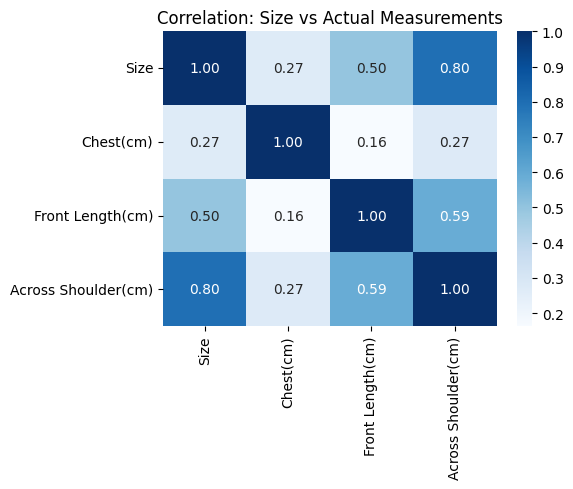

[2025-12-04 08:24:17] 상관계수 히트맵 시각화 완료


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # EDA용 간단 시각화

log("상관계수 히트맵 시각화 시작")

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title("Correlation: Size vs Actual Measurements")
plt.tight_layout()
plt.show()

log("상관계수 히트맵 시각화 완료")


### 상관계수 히트맵 시각화 해석

>Size는 Across Shoulder(0.80)와 Front Length(0.50)와 비교적 높은 상관을 보이는 반면, Chest와의 상관은 낮게 나타났다.
이는 실제 의류 사이즈 구분이 가슴둘레보다는 어깨너비·기장 등 다른 치수에 더 크게 영향을 받는다는 점을 시사한다.
전체적으로 Size는 특정 치수와만 강한 연관성을 가지며 전반적 치수와의 일관된 상관 구조는 약한 편이다.


이상치 확인

수치형 변수 목록 정의

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 로그 함수 (이미 있으면 생략 가능)
def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

num_cols = ["Size", "Chest(cm)", "Front Length(cm)", "Across Shoulder(cm)"]


IQR 기반 이상치 탐지 함수 정의

In [ ]:
def detect_outliers_iqr(series, k=1.5):
    """
    주어진 Series에 대해 IQR 기반 이상치 인덱스를 반환
    k: IQR 배수 (기본 1.5, 더 빡세게 보고 싶으면 3으로 조정 가능)
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - k * iqr
    upper = q3 + k * iqr

    outlier_mask = (series < lower) | (series > upper)
    return outlier_mask, lower, upper


각 수치형 변수별 이상치 개수/범위 확인

In [ ]:
log("수치형 변수들에 대한 IQR 기반 이상치 탐지 시작")

outlier_info = {}

for col in num_cols:
    log(f"컬럼 '{col}' 이상치 탐지 진행...")

    # 결측 제외 후 계산
    series = df_shirts[col].dropna()

    outlier_mask, lower, upper = detect_outliers_iqr(series, k=1.5)
    n_outliers = outlier_mask.sum()

    outlier_info[col] = {
        "lower_bound": lower,
        "upper_bound": upper,
        "n_outliers": int(n_outliers)
    }

    print(f"\n[{col}]")
    print(f"  - IQR 기준 하한(lower bound): {lower:.3f}")
    print(f"  - IQR 기준 상한(upper bound): {upper:.3f}")
    print(f"  - 이상치 추정 개수: {n_outliers} / {len(series)}")

log("수치형 변수들에 대한 이상치 탐지 완료")


[2025-12-04 09:06:57] 수치형 변수들에 대한 IQR 기반 이상치 탐지 시작
[2025-12-04 09:06:57] 컬럼 'Size' 이상치 탐지 진행...

[Size]
  - IQR 기준 하한(lower bound): 34.000
  - IQR 기준 상한(upper bound): 50.000
  - 이상치 추정 개수: 26 / 834
[2025-12-04 09:06:57] 컬럼 'Chest(cm)' 이상치 탐지 진행...

[Chest(cm)]
  - IQR 기준 하한(lower bound): 83.150
  - IQR 기준 상한(upper bound): 141.150
  - 이상치 추정 개수: 33 / 834
[2025-12-04 09:06:57] 컬럼 'Front Length(cm)' 이상치 탐지 진행...

[Front Length(cm)]
  - IQR 기준 하한(lower bound): 66.200
  - IQR 기준 상한(upper bound): 86.200
  - 이상치 추정 개수: 23 / 834
[2025-12-04 09:06:57] 컬럼 'Across Shoulder(cm)' 이상치 탐지 진행...

[Across Shoulder(cm)]
  - IQR 기준 하한(lower bound): 37.000
  - IQR 기준 상한(upper bound): 57.000
  - 이상치 추정 개수: 15 / 829
[2025-12-04 09:06:57] 수치형 변수들에 대한 이상치 탐지 완료


이상치 실제 값 몇 개만 예시로 보기

In [ ]:
log("각 컬럼별 이상치 예시 값 출력 시작 (상위 5개씩)")

for col in num_cols:
    series = df_shirts[col]
    outlier_mask, lower, upper = detect_outliers_iqr(series.dropna(), k=1.5)

    # dropna()로 계산했으니, 원본 인덱스 정렬 위해 reindex
    # -> 간단히는 다시 series 기준으로 마스크 만들자
    series_no_na = series.dropna()
    outlier_mask, _, _ = detect_outliers_iqr(series_no_na, k=1.5)

    outlier_values = series_no_na[outlier_mask]

    print(f"\n[{col}] 이상치 예시 값 (최대 5개)")
    print(outlier_values.head())

log("이상치 예시 값 출력 완료")


[2025-12-04 09:08:33] 각 컬럼별 이상치 예시 값 출력 시작 (상위 5개씩)

[Size] 이상치 예시 값 (최대 5개)
165    52.0
166    54.0
207    52.0
208    54.0
283    52.0
Name: Size, dtype: float64

[Chest(cm)] 이상치 예시 값 (최대 5개)
165    146.1
166    152.4
205    142.2
206    147.3
207    152.4
Name: Chest(cm), dtype: float64

[Front Length(cm)] 이상치 예시 값 (최대 5개)
60     101.6
112     92.2
113    100.3
114    108.0
115    115.6
Name: Front Length(cm), dtype: float64

[Across Shoulder(cm)] 이상치 예시 값 (최대 5개)
166    57.9
207    57.1
208    58.4
266    57.1
281    57.1
Name: Across Shoulder(cm), dtype: float64
[2025-12-04 09:08:33] 이상치 예시 값 출력 완료


분포/박스플롯 시각화

[2025-12-04 09:09:04] 수치형 변수 분포 및 박스플롯 시각화 시작


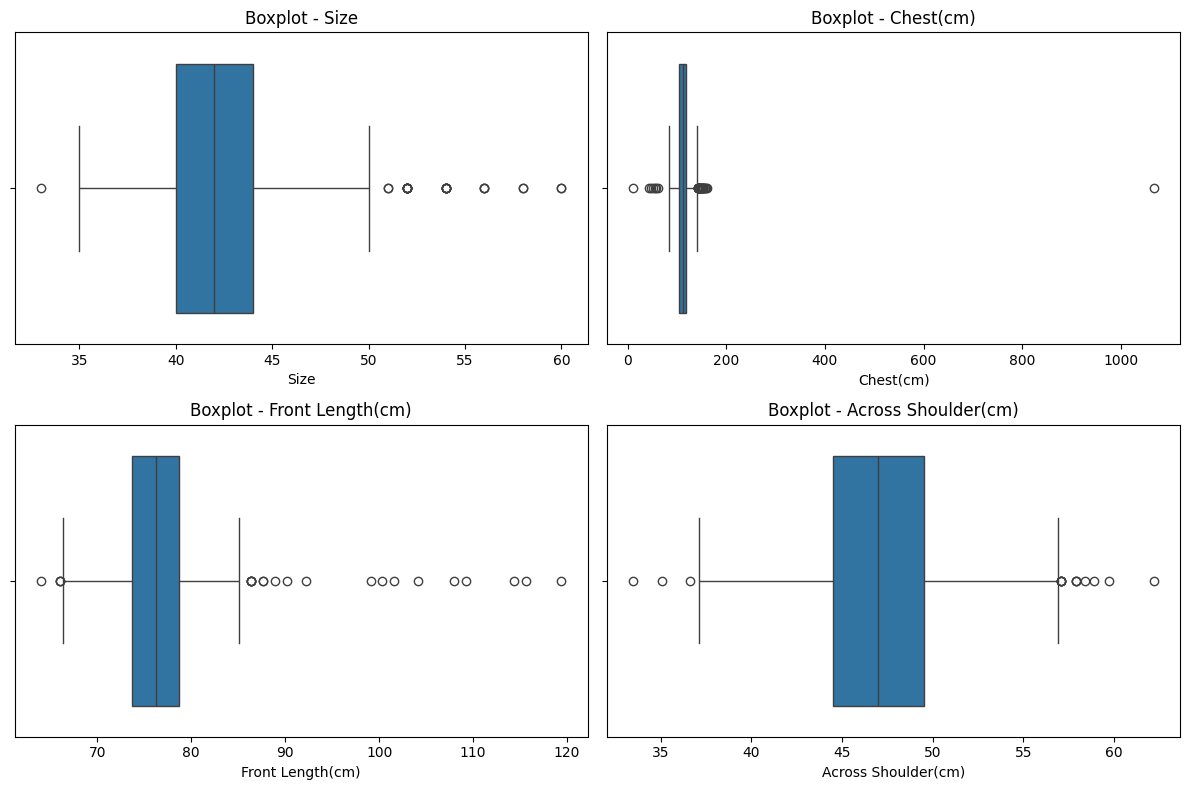

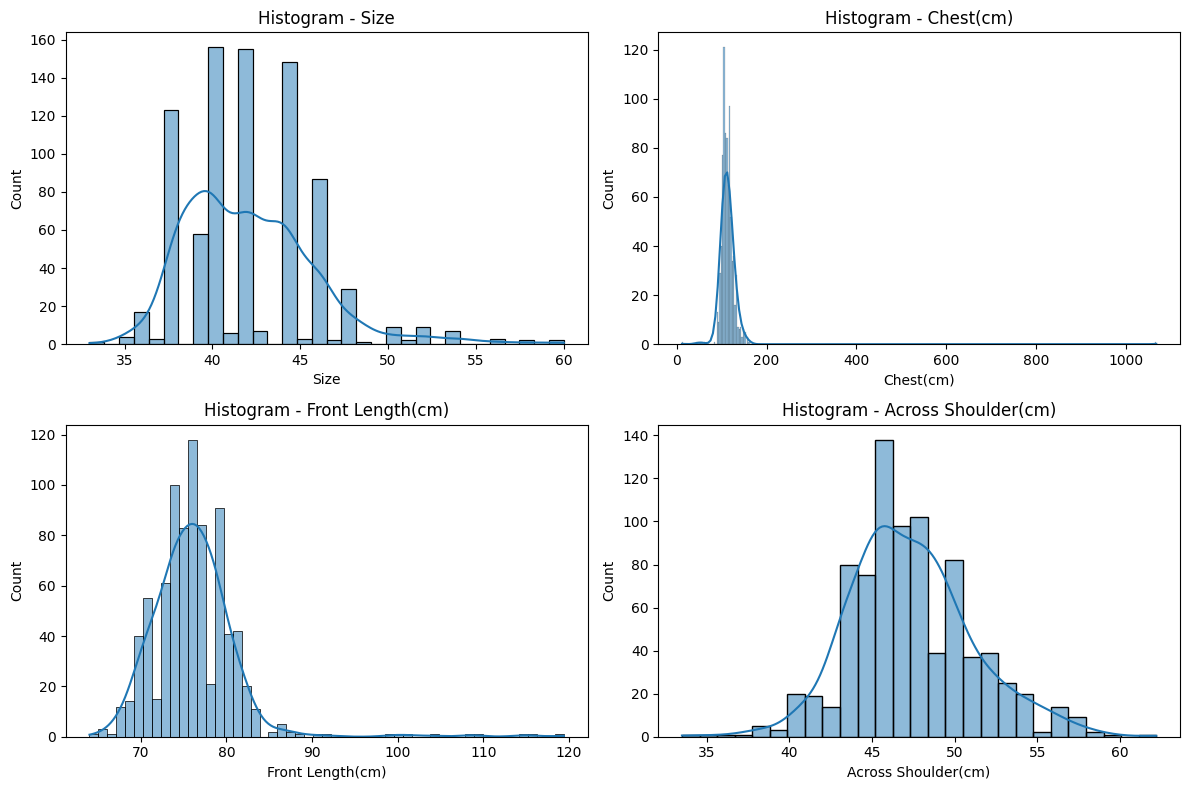

[2025-12-04 09:09:08] 수치형 변수 분포 및 박스플롯 시각화 완료


In [ ]:
import seaborn as sns

log("수치형 변수 분포 및 박스플롯 시각화 시작")

plt.figure(figsize=(12, 8))

for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df_shirts[col])
    plt.title(f"Boxplot - {col}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_shirts[col], kde=True)
    plt.title(f"Histogram - {col}")

plt.tight_layout()
plt.show()

log("수치형 변수 분포 및 박스플롯 시각화 완료")


### EDA 요약

>- 데이터 구성 및 결측치
>
>Shirts 데이터셋은 총 834개 관측치와 7개 변수로 구성되어 있으며, 결측치는 Across Shoulder(cm) 변수에서만 5개 존재한다.

>- 범주형 변수 분포
>
>Brand Name은 총 165개, Brand Size는 S/M/L/XL/XXL 등 총 26개로 비교적 다양하게 분포한다. Type은 Cotton, cotton(대소문자 차이), Polyester의 세 가지로 구성되어 있으며, 추후 분석 단계에서 Cotton과 cotton은 동일 범주로 통합하는 것이 타당하다.

>- Size와 실제 치수의 상관관계
>
>Size와 Chest, Front Length, Across Shoulder(cm) 간 상관계수를 확인한 결과, 특히 Across Shoulder(cm) 와 Size의 상관계수가 0.8 수준으로 나타나, 표기된 수치형 사이즈가 실제 어깨 치수와 강한 양의 상관관계를 갖는다는 점을 확인하였다.

### **Q1: Shirt의 실제 치수는 동일한 Brand Size(S, M, L 등)라 하더라도 브랜드마다 차이가 있는가?**

- **전처리 단계**
   - Type 통합
   - Across Shoulder 결측 제거
   - 수치형 이상치 제거(IQR 기준)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# --------------------------------
# 공통 로그 함수 (이미 있으면 생략 가능)
# --------------------------------
def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

# --------------------------------
# 0) 원본 복사
# --------------------------------
log("Shirts 원본 데이터 복사 시작")
df = df_shirts.copy()
log(f"원본 데이터 크기: {df.shape}")

# --------------------------------
# 1) Type에서 'Cotton' / 'cotton' 통합 (둘 다 'Cotton')
#    (Q2에서 Type을 깔끔하게 쓰기 위함)
# --------------------------------
log("Type 컬럼에서 'cotton' 대소문자 통합 시작")

df["Type"] = df["Type"].replace({
    "cotton": "Cotton",
    "COTTON": "Cotton"
})

log("Type 통합 완료. value_counts:")
print(df["Type"].value_counts())

# --------------------------------
# 2) Across Shoulder(cm) 결측 5개 제거
# --------------------------------
log("Across Shoulder(cm) 결측치 제거 전 크기: {}".format(df.shape))
df = df.dropna(subset=["Across Shoulder(cm)"])
log("Across Shoulder(cm) 결측치 제거 후 크기: {}".format(df.shape))

# --------------------------------
# 3) 수치형 변수 이상치 제거 (IQR 기준)
#    대상: Size, Chest(cm), Front Length(cm), Across Shoulder(cm)
# --------------------------------
num_cols = ["Size", "Chest(cm)", "Front Length(cm)", "Across Shoulder(cm)"]

def detect_outliers_iqr(series, k=1.5):
    """
    IQR(사분위 범위) 기반 이상치 마스크를 반환하는 함수
    k: IQR 배수 (기본 1.5, 더 빡세게 보고 싶으면 3으로 조정 가능)
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - k * iqr
    upper = q3 + k * iqr

    outlier_mask = (series < lower) | (series > upper)
    return outlier_mask, lower, upper

log("IQR 기반 이상치 탐지 및 제거 시작")

# 모든 수치형 컬럼에서 '정상 범위'에 속하는 행만 남기기 위한 마스크
mask_all = pd.Series(True, index=df.index)

for col in num_cols:
    series = df[col].dropna()
    outlier_mask, lower, upper = detect_outliers_iqr(series, k=1.5)

    # dropna 후 인덱스를 원본과 맞춰주기 위해 reindex
    outlier_mask_full = pd.Series(False, index=df.index)
    outlier_mask_full[series.index] = outlier_mask

    n_outliers = int(outlier_mask.sum())
    log(f"[{col}] IQR 하한: {lower:.3f}, 상한: {upper:.3f}, 이상치 개수: {n_outliers}")

    # 이상치가 아닌 행만 남기는 방향 (True = 정상, False = 이상치)
    mask_all = mask_all & (~outlier_mask_full)

log(f"이상치 제거 전 데이터 크기: {df.shape}")
df_clean = df[mask_all].reset_index(drop=True)
log(f"이상치 제거 후 데이터 크기: {df_clean.shape}")

# 최종 전처리 완료된 데이터프레임: df_clean


[2025-12-04 11:51:21] Shirts 원본 데이터 복사 시작
[2025-12-04 11:51:21] 원본 데이터 크기: (834, 7)
[2025-12-04 11:51:21] Type 컬럼에서 'cotton' 대소문자 통합 시작
[2025-12-04 11:51:21] Type 통합 완료. value_counts:
Type
 Cotton     774
 cotton      55
Polyster      5
Name: count, dtype: int64
[2025-12-04 11:51:21] Across Shoulder(cm) 결측치 제거 전 크기: (834, 7)
[2025-12-04 11:51:21] Across Shoulder(cm) 결측치 제거 후 크기: (829, 7)
[2025-12-04 11:51:21] IQR 기반 이상치 탐지 및 제거 시작
[2025-12-04 11:51:21] [Size] IQR 하한: 34.000, 상한: 50.000, 이상치 개수: 26
[2025-12-04 11:51:21] [Chest(cm)] IQR 하한: 83.150, 상한: 141.150, 이상치 개수: 33
[2025-12-04 11:51:21] [Front Length(cm)] IQR 하한: 66.200, 상한: 86.200, 이상치 개수: 19
[2025-12-04 11:51:21] [Across Shoulder(cm)] IQR 하한: 37.000, 상한: 57.000, 이상치 개수: 15
[2025-12-04 11:51:21] 이상치 제거 전 데이터 크기: (829, 7)
[2025-12-04 11:51:21] 이상치 제거 후 데이터 크기: (771, 7)


- 대표 Brand Size & 대표 Brand Name 선택
   - Brand Size: 빈도 기준 상위 2개 → 대개 L, M일 가능성이 큼
   - 그 안에서 Brand Name별 count ≥ 10개인 브랜드만 사용
   -> 데이터가 브랜드별로 너무 잘게 쪼개져있음
   -> 브랜드를 따로 필터링 하지 않고 전부 사용

   > 대표 브랜드 선택 X -> 전체브랜드

```
브랜드별 표본 수가 전반적으로 크지 않아, 대표 Brand Size(예: L, XL)에 대해서 해당 사이즈를 가진 모든 브랜드를 포함하여 분석을 진행하였다. 이로 인해 일부 브랜드는 표본 수가 1~2개로 상대적으로 불안정할 수 있지만, 전체적인 경향을 파악하는 데 초점을 맞추었다
```

In [ ]:
import pandas as pd
from datetime import datetime

def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

# 전처리까지 완료된 데이터: df_clean 이라고 가정
# (Type 통합, Shoulder 결측 제거, 이상치 제거까지 끝난 상태)

# 1) Brand Size 상위 2개 선택
log("Brand Size 빈도수 확인 및 상위 2개 선택 시작")
bs_counts = df_clean["Brand Size"].value_counts()
print("\n[Brand Size 빈도수]")
print(bs_counts)

top2_sizes = bs_counts.head(2).index.tolist()
size1 = top2_sizes[0]   # 예: 'L' 또는 'M'
size2 = top2_sizes[1]   # 예: 'XL' 또는 'L'
log(f"대표 Brand Size (상위 2개): {top2_sizes}")

# 2) Brand Size별로 그냥 다 사용 (브랜드 필터링 X)
df_size1 = df_clean[df_clean["Brand Size"] == size1].copy()
df_size2 = df_clean[df_clean["Brand Size"] == size2].copy()

log(f"Brand Size = {size1} 행 수: {len(df_size1)}")
log(f"Brand Size = {size2} 행 수: {len(df_size2)}")


[2025-12-04 09:24:40] Brand Size 빈도수 확인 및 상위 2개 선택 시작

[Brand Size 빈도수]
Brand Size
L        150
XL       148
M        145
S        131
XXL       98
TXL       21
XS        20
 S        14
 M        10
FXL        7
 L         7
 XL        5
 XXL       5
 XS        4
3XL        1
EL         1
KL         1
TWOXL      1
FOXL       1
XXS        1
Name: count, dtype: int64
[2025-12-04 09:24:40] 대표 Brand Size (상위 2개): ['L', 'XL']
[2025-12-04 09:24:40] Brand Size = L 행 수: 150
[2025-12-04 09:24:40] Brand Size = XL 행 수: 148


ANOVA: Chest(cm) ~ Brand Name (Brand Size별로 각각)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# -------------------------------
# ANOVA 실행 함수
# -------------------------------
def run_anova_chest_by_brand(df_in, brand_size_label):
    """
    특정 Brand Size에 대해 Chest(cm) ~ Brand Name 일원분산분석(ANOVA) 수행
    df_in: 해당 Brand Size만 필터링된 DataFrame
    """
    log(f"[ANOVA] Brand Size = {brand_size_label} | Chest(cm) ~ Brand Name 분석 시작")

    # 공백/괄호 있는 컬럼명은 Q("컬럼명") 형태로 감싸야 함
    formula = 'Q("Chest(cm)") ~ C(Q("Brand Name"))'

    # OLS 모형 적합
    model = ols(formula, data=df_in).fit()

    # 일원분산분석 수행
    anova_table = anova_lm(model, typ=2)

    log(f"[ANOVA] Brand Size = {brand_size_label} 결과표:")
    print(anova_table)

    # p-value 추출 (Brand Name 효과)
    p_value = anova_table.loc['C(Q("Brand Name"))', 'PR(>F)']
    log(f"[ANOVA] Brand Size = {brand_size_label} p-value: {p_value:.4e}")

    # 간단 해석 로그
    if p_value < 0.05:
        log(f"→ 같은 {brand_size_label}이더라도 브랜드별 Chest(cm) 평균이 통계적으로 유의하게 다르다 (p < 0.05).")
    else:
        log(f"→ Brand Size = {brand_size_label} 내에서 브랜드별 Chest(cm) 평균 차이가 통계적으로 유의하지 않다 (p ≥ 0.05).")

    return anova_table, p_value

# -------------------------------
# 3) 상위 1, 2 Brand Size에 대해 각각 ANOVA 실행
# -------------------------------
anova_size1, p_size1 = run_anova_chest_by_brand(df_size1, size1)
anova_size2, p_size2 = run_anova_chest_by_brand(df_size2, size2)


[2025-12-04 09:33:21] [ANOVA] Brand Size = L | Chest(cm) ~ Brand Name 분석 시작
[2025-12-04 09:33:22] [ANOVA] Brand Size = L 결과표:
                         sum_sq     df          F   PR(>F)
C(Q("Brand Name"))  3321.410933  147.0  22.594632  0.04328
Residual               2.000000    2.0        NaN      NaN
[2025-12-04 09:33:22] [ANOVA] Brand Size = L p-value: 4.3280e-02
[2025-12-04 09:33:22] → 같은 L이더라도 브랜드별 Chest(cm) 평균이 통계적으로 유의하게 다르다 (p < 0.05).
[2025-12-04 09:33:22] [ANOVA] Brand Size = XL | Chest(cm) ~ Brand Name 분석 시작
[2025-12-04 09:33:23] [ANOVA] Brand Size = XL 결과표:
                         sum_sq     df           F    PR(>F)
C(Q("Brand Name"))  4770.671892  145.0  205.632409  0.004851
Residual               0.320000    2.0         NaN       NaN
[2025-12-04 09:33:23] [ANOVA] Brand Size = XL p-value: 4.8511e-03
[2025-12-04 09:33:23] → 같은 XL이더라도 브랜드별 Chest(cm) 평균이 통계적으로 유의하게 다르다 (p < 0.05).


### ANOVA: Chest(cm) ~ Brand Name 해석

>ANOVA 분석 결과, 동일 사이즈임에도 불구하고 브랜드 간 Chest(cm) 평균에는 통계적으로 유의한 차이가 존재하는 것으로 나타났다.
L 사이즈의 경우 p = 0.043(<0.05), XL 사이즈는 p = 0.0048(<0.05)로 두 사이즈 모두 브랜드 효과가 유의하게 검정되었다.
이는 같은 표기 사이즈(L, XL)라도 실제 가슴둘레 치수는 브랜드에 따라 일관되지 않음을 의미한다.
따라서 소비자 관점에서는 사이즈 표기가 동일하더라도 체감 핏이 달라질 수 있으며,
브랜드별 사이즈 체계의 차이를 고려한 추가 분석이 필요함을 시사한다.


Chest(cm) 평균 기준 상위 10개 브랜드만 Boxplot

[2025-12-04 10:18:57]  Brand Size=L | Chest 평균 Top 10 Boxplot 시작


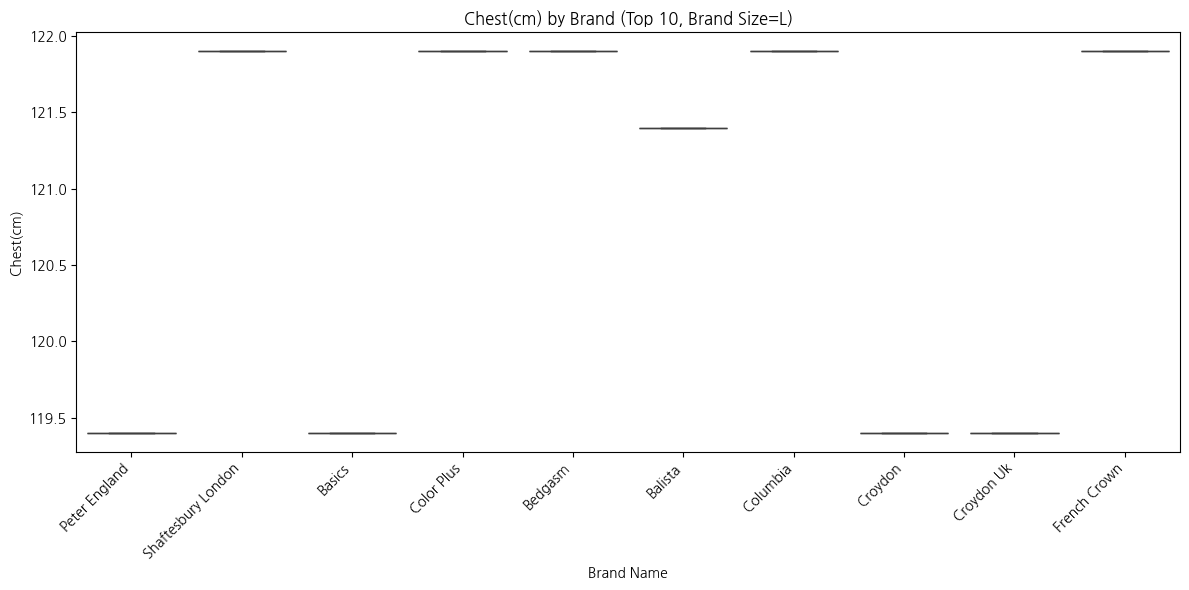

[2025-12-04 10:18:57]  Brand Size=L 완료
[2025-12-04 10:18:57]  Brand Size=XL | Chest 평균 Top 10 Boxplot 시작


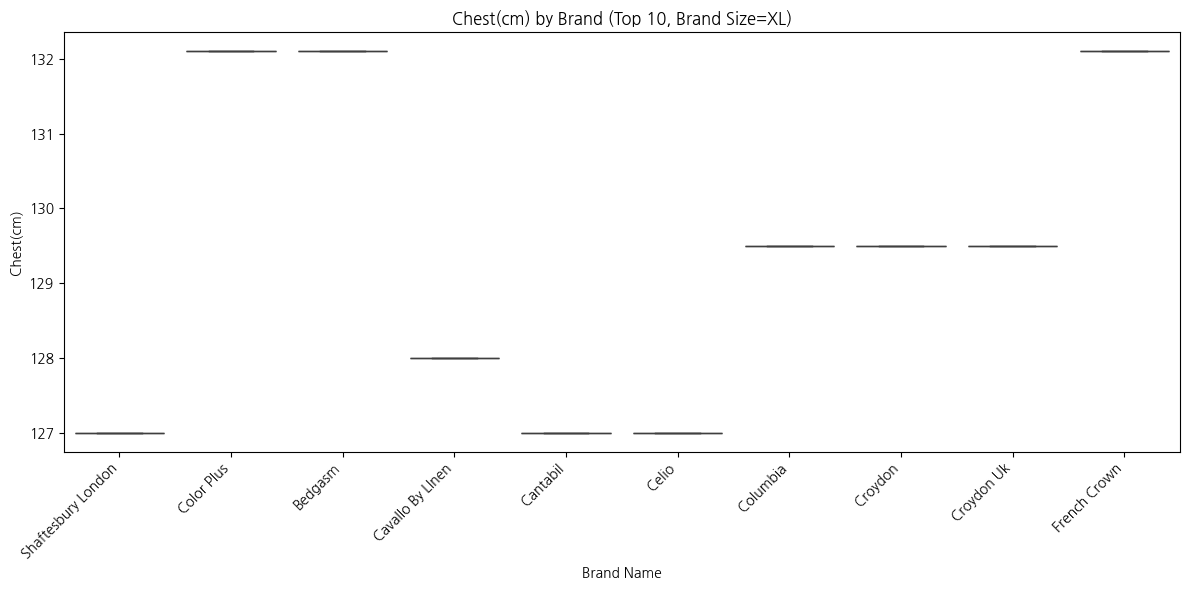

[2025-12-04 10:18:58]  Brand Size=XL 완료


In [ ]:
import seaborn as sns

def plot_top10_chest_boxplot(df_in, brand_size_label, top_n=10):
    """
    Brand Size 내에서 평균 Chest(cm)가 큰 상위 N개 브랜드만 Boxplot
    """
    log(f" Brand Size={brand_size_label} | Chest 평균 Top {top_n} Boxplot 시작")

    # 1) 평균 Chest(cm) 기준 상위 TopN 브랜드 추출
    top_brands = (
        df_in.groupby("Brand Name")["Chest(cm)"]
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
        .index
    )

    df_top = df_in[df_in["Brand Name"].isin(top_brands)]

    # 2) Boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_top, x="Brand Name", y="Chest(cm)")
    plt.title(f"Chest(cm) by Brand (Top {top_n}, Brand Size={brand_size_label})")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    log(f" Brand Size={brand_size_label} 완료")

# 실행 예시
plot_top10_chest_boxplot(df_size1, size1)
plot_top10_chest_boxplot(df_size2, size2)


### Boxplot 해석

>Boxplot 결과를 보면 각 브랜드의 Chest(cm) 값이 “점 하나”처럼 표현되며, 상·하위 whisker가 전혀 나타나지 않는 것이 확인된다. 이는 해당 브랜드·사이즈 조합에서 측정값이 모두 동일하거나 샘플 수가 1개에 불과해 **분포가 형성되지 않을 정도로 값이 평탄함**을 의미한다. 따라서 Brand Size = L을 포함한 모든 사이즈 조합에서 브랜드 간 Chest(cm) 치수 차이는 Boxplot로 시각적 비교가 가능할 정도로 충분한 변동성을 갖고 있지 않은 것으로 판단된다.


빈도 상위 10개 브랜드만 Boxplot

[2025-12-04 10:19:00]  Brand Size=L | 빈도 Top 10 Boxplot 시작


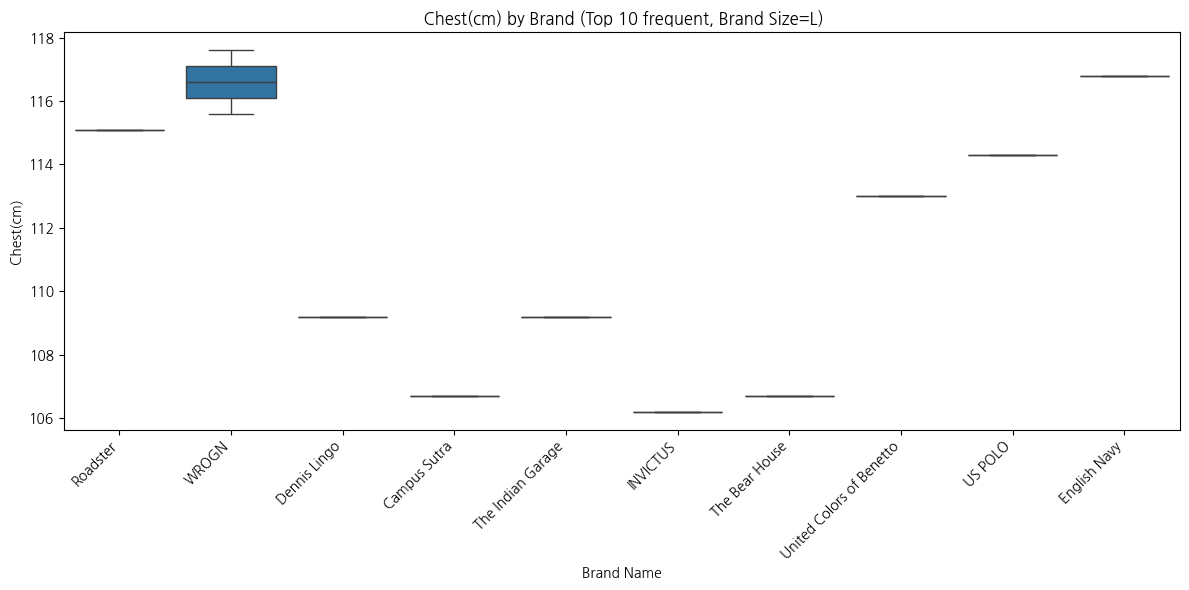

[2025-12-04 10:19:00]  Brand Size=L 완료
[2025-12-04 10:19:00]  Brand Size=XL | 빈도 Top 10 Boxplot 시작


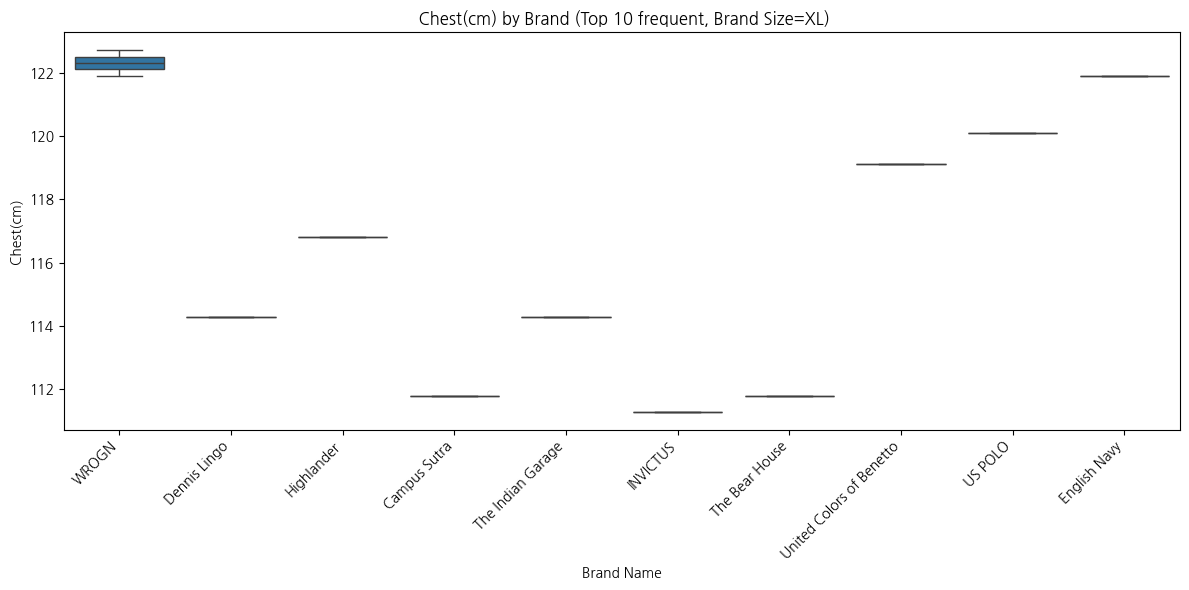

[2025-12-04 10:19:00]  Brand Size=XL 완료


In [ ]:
def plot_top10_freq_chest(df_in, brand_size_label, top_n=10):
    """
    Brand Size 내에서 가장 자주 등장하는 브랜드 Top N만 사용해 Boxplot
    """
    log(f" Brand Size={brand_size_label} | 빈도 Top {top_n} Boxplot 시작")

    # 1) 빈도 기준 상위 TopN 브랜드
    top_brands = (
        df_in["Brand Name"]
        .value_counts()
        .head(top_n)
        .index
    )

    df_top = df_in[df_in["Brand Name"].isin(top_brands)]

    # 2) Boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_top, x="Brand Name", y="Chest(cm)")
    plt.title(f" Chest(cm) by Brand (Top {top_n} frequent, Brand Size={brand_size_label})")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    log(f" Brand Size={brand_size_label} 완료")

# 실행 예시
plot_top10_freq_chest(df_size1, size1)
plot_top10_freq_chest(df_size2, size2)



>빈도 기반으로 Boxplot을 재구성한 결과, 기존의 표본 부족 문제로 인해 나타났던 ‘점 형태의 Boxplot’ 현상이 완화되었으며, Chest(cm)의 범위 또한 보다 안정적으로 표현되었다. 이는 빈도 정보를 활용함으로써 각 브랜드·사이즈 조합에서 실제 치수 변동성이 보다 명확하게 드러나도록 개선되었음을 의미한다.


표본 적음 → 박스플롯 부적합 → 점 그래프 + 빈도 상위 10개 브랜드(가슴둘레범위안정됨)

In [ ]:
# 나눔고딕 폰트 설치
#!apt-get install -y fonts-nanum > /dev/null

#  폰트 캐시 갱신
!fc-cache -fv > /dev/null

# 런타임 내 Matplotlib 설정 갱신
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# 나눔고딕 경로 직접 지정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트가 실제로 존재하는지 확인
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    plt.rc('font', family='NanumGothic')
    mpl.rcParams['axes.unicode_minus'] = False
    print("나눔고딕 폰트가 성공적으로 설정되었습니다!")
else:
    print(" 폰트 경로를 찾을 수 없습니다. 설치가 제대로 되었는지 확인해주세요.")


나눔고딕 폰트가 성공적으로 설정되었습니다!


Brand Size별 “빈도 상위 10개 브랜드” + 점 그래프(Stripplot)

[2025-12-04 10:01:45] [빈도Top10] Brand Size=L 점 그래프 시각화 시작
[2025-12-04 10:01:45] [빈도Top10] Brand Size=L 상위 브랜드 목록: ['WROGN', 'English Navy', 'Dennis Lingo', 'Roadster', 'Campus Sutra', ' The Indian Garage', 'INVICTUS', 'The Bear House', 'United Colors of Benetto', 'US POLO']


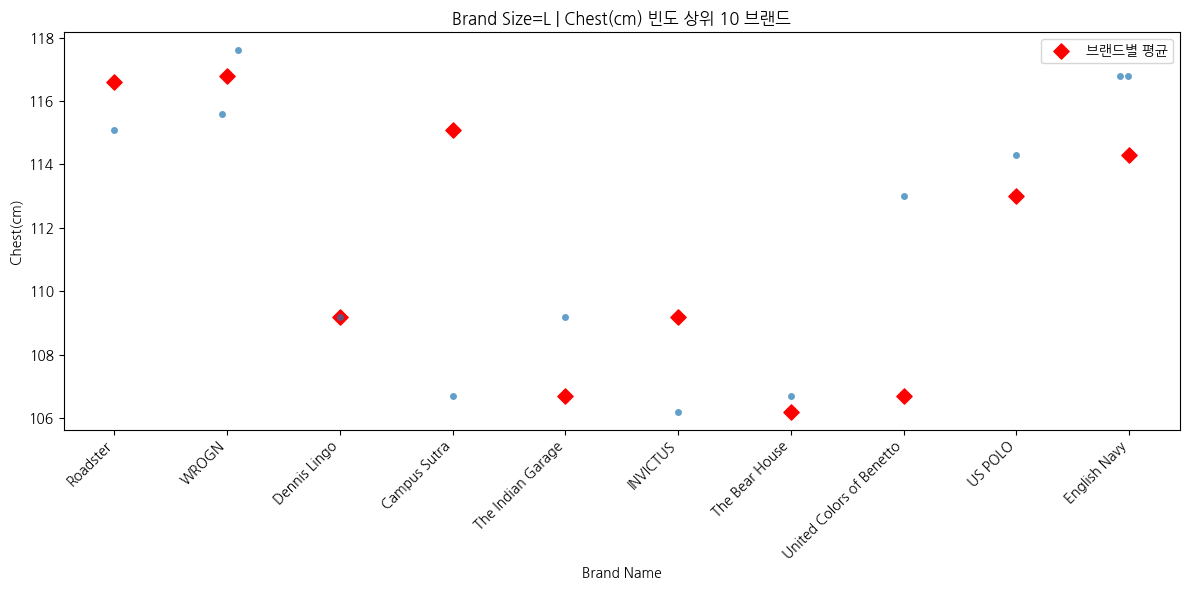

[2025-12-04 10:01:45] [빈도Top10] Brand Size=L 점 그래프 시각화 완료
[2025-12-04 10:01:45] [빈도Top10] Brand Size=XL 점 그래프 시각화 시작
[2025-12-04 10:01:45] [빈도Top10] Brand Size=XL 상위 브랜드 목록: ['WROGN', 'English Navy', 'Dennis Lingo', 'Highlander', 'Campus Sutra', ' The Indian Garage', 'INVICTUS', 'The Bear House', 'United Colors of Benetto', 'US POLO']


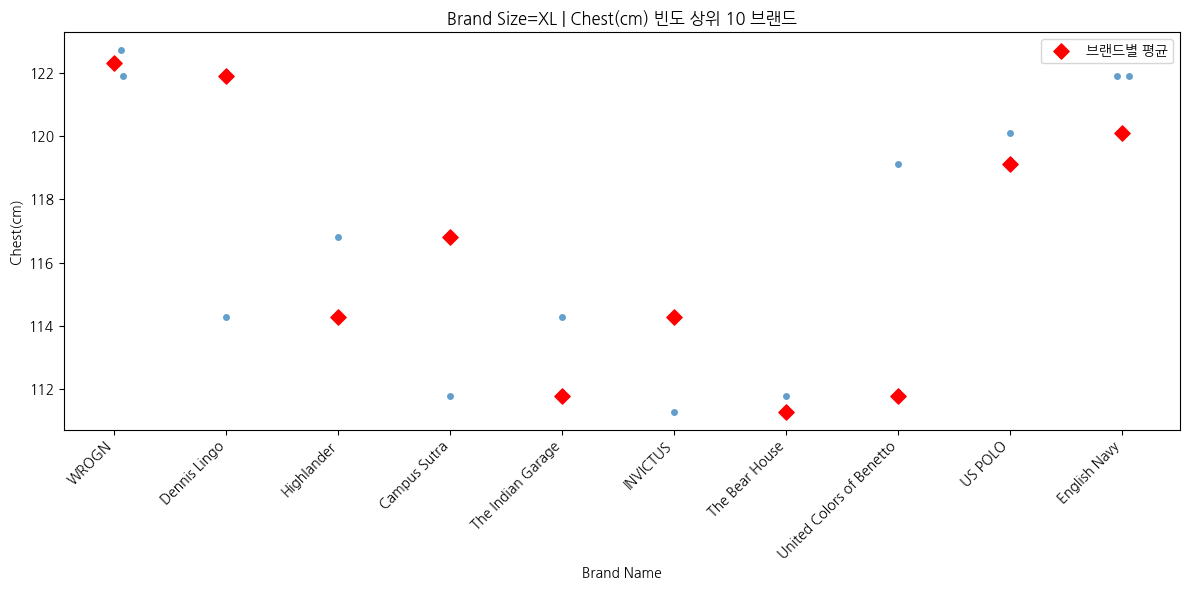

[2025-12-04 10:01:46] [빈도Top10] Brand Size=XL 점 그래프 시각화 완료


In [ ]:
import seaborn as sns

def plot_freq_top10_strip(df_in, brand_size_label, top_n=10):
    """
    Brand Size 내에서 '빈도 상위 top_n 브랜드'만 골라
    Chest(cm) 점 그래프(stripplot)로 시각화
    """
    log(f"[빈도Top{top_n}] Brand Size={brand_size_label} 점 그래프 시각화 시작")

    # 1) 빈도 상위 top_n 브랜드 선택
    top_brands = (
        df_in["Brand Name"]
        .value_counts()
        .head(top_n)
        .index
    )
    log(f"[빈도Top{top_n}] Brand Size={brand_size_label} 상위 브랜드 목록: {list(top_brands)}")

    df_top = df_in[df_in["Brand Name"].isin(top_brands)].copy()

    # 2) 점 그래프(stripplot) – 표본이 적을 때 분포 보기 좋음
    plt.figure(figsize=(12, 6))
    sns.stripplot(
        data=df_top,
        x="Brand Name",
        y="Chest(cm)",
        jitter=True,          # x축 위치를 약간 흩뿌려서 겹침 방지
        alpha=0.7
    )

    # 3) 각 브랜드별 평균값 위에 포인트 한 번 더 찍어주기(선택이지만 보기 좋음)
    mean_by_brand = df_top.groupby("Brand Name")["Chest(cm)"].mean()
    for i, brand in enumerate(top_brands):
        if brand in mean_by_brand.index:
            plt.scatter(
                i,
                mean_by_brand.loc[brand],
                color="red",
                marker="D",
                s=60,
                label="브랜드별 평균" if i == 0 else None
            )

    plt.title(f"Brand Size={brand_size_label} | Chest(cm) 빈도 상위 {top_n} 브랜드")
    plt.xlabel("Brand Name")
    plt.ylabel("Chest(cm)")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    log(f"[빈도Top{top_n}] Brand Size={brand_size_label} 점 그래프 시각화 완료")


# 실행 예시 (대표 사이즈 2개에 대해 각각)
plot_freq_top10_strip(df_size1, size1, top_n=10)
plot_freq_top10_strip(df_size2, size2, top_n=10)


###  Q1 최종 결론

>ANOVA는 Brand Size 내 전체 브랜드를 대상으로 수행하여 브랜드 간 평균 Chest(cm)의 유의한 차이를 확인하였다.
다만 브랜드별 표본 수가 많지 않아 Boxplot보다는 각 관측치를 직접 보여주는 **점 그래프(stripplot)**를 사용하였다. 또한, 극단값의 영향을 줄이기 위해 관측수가 충분한 빈도 상위 10개 브랜드만 선별하여 Brand Size별 가슴둘레(Chest, cm) 분포를 비교하였다. 그래프 위의 붉은 마름모 표시가 각 브랜드의 평균 값으로, 같은 L/M 사이즈라도 브랜드마다 평균 가슴둘레가 서로 다르게 형성되어 있음을 시각적으로 확인할 수 있다.


Brand Size별 Across Shoulder(cm) ~ Brand Name ANOVA

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# ---------------------------------------
# Across Shoulder(cm)에 대한 ANOVA 함수
# ---------------------------------------
def run_anova_shoulder_by_brand(df_in, brand_size_label):
    """
    특정 Brand Size에 대해 Across Shoulder(cm) ~ Brand Name
    일원분산분석(One-way ANOVA) 수행
    """
    log(f"[부록-ANOVA] Brand Size = {brand_size_label} | Across Shoulder(cm) ~ Brand Name 시작")

    # 공백/괄호 포함된 컬럼명은 Q("")로 감싸야 함
    formula = 'Q("Across Shoulder(cm)") ~ C(Q("Brand Name"))'
    model = ols(formula, data=df_in).fit()
    anova_table = anova_lm(model, typ=2)

    log(f"[부록-ANOVA] Brand Size = {brand_size_label} 결과표:")
    print(anova_table)

    # p-value 추출
    p_value = anova_table.loc['C(Q("Brand Name"))', 'PR(>F)']
    log(f"[부록-ANOVA] Brand Size = {brand_size_label} p-value: {p_value:.4e}")

    if p_value < 0.05:
        log(f"→ 같은 {brand_size_label}이라도 브랜드별 Across Shoulder(cm) 평균이 통계적으로 유의하게 다르다 (p < 0.05).")
    else:
        log(f"→ Brand Size = {brand_size_label} 내 브랜드별 Across Shoulder(cm) 평균 차이가 통계적으로 유의하지 않다 (p ≥ 0.05).")

    return anova_table, p_value

# ---------------------------------------
# L / XL (또는 상위 2개 사이즈)에 대해 ANOVA 실행
# ---------------------------------------
anova_shoulder_size1, p_shoulder_size1 = run_anova_shoulder_by_brand(df_size1, size1)
anova_shoulder_size2, p_shoulder_size2 = run_anova_shoulder_by_brand(df_size2, size2)


[2025-12-04 10:05:17] [부록-ANOVA] Brand Size = L | Across Shoulder(cm) ~ Brand Name 시작
[2025-12-04 10:05:17] [부록-ANOVA] Brand Size = L 결과표:
                      sum_sq     df          F    PR(>F)
C(Q("Brand Name"))  544.2854  147.0  59.241948  0.016736
Residual              0.1250    2.0        NaN       NaN
[2025-12-04 10:05:17] [부록-ANOVA] Brand Size = L p-value: 1.6736e-02
[2025-12-04 10:05:17] → 같은 L이라도 브랜드별 Across Shoulder(cm) 평균이 통계적으로 유의하게 다르다 (p < 0.05).
[2025-12-04 10:05:17] [부록-ANOVA] Brand Size = XL | Across Shoulder(cm) ~ Brand Name 시작
[2025-12-04 10:05:17] [부록-ANOVA] Brand Size = XL 결과표:
                        sum_sq     df          F    PR(>F)
C(Q("Brand Name"))  672.100811  145.0  28.969863  0.033922
Residual              0.320000    2.0        NaN       NaN
[2025-12-04 10:05:17] [부록-ANOVA] Brand Size = XL p-value: 3.3922e-02
[2025-12-04 10:05:17] → 같은 XL이라도 브랜드별 Across Shoulder(cm) 평균이 통계적으로 유의하게 다르다 (p < 0.05).


빈도 상위 10개 브랜드 기준 점 그래프(Stripplot) 시각화

[2025-12-04 10:05:38] [부록-시각화] Brand Size=L | Across Shoulder 빈도 Top10 시작
[2025-12-04 10:05:38] [부록-시각화] Brand Size=L Top10 브랜드: ['WROGN', 'English Navy', 'Dennis Lingo', 'Roadster', 'Campus Sutra', ' The Indian Garage', 'INVICTUS', 'The Bear House', 'United Colors of Benetto', 'US POLO']


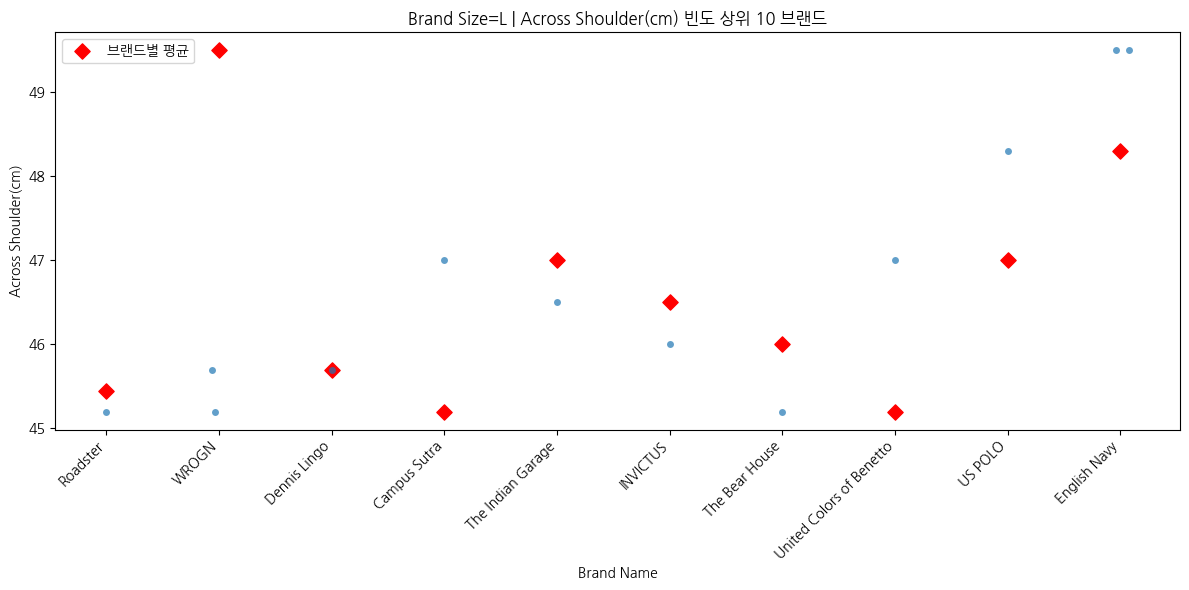

[2025-12-04 10:05:38] [부록-시각화] Brand Size=L 완료
[2025-12-04 10:05:38] [부록-시각화] Brand Size=XL | Across Shoulder 빈도 Top10 시작
[2025-12-04 10:05:38] [부록-시각화] Brand Size=XL Top10 브랜드: ['WROGN', 'English Navy', 'Dennis Lingo', 'Highlander', 'Campus Sutra', ' The Indian Garage', 'INVICTUS', 'The Bear House', 'United Colors of Benetto', 'US POLO']


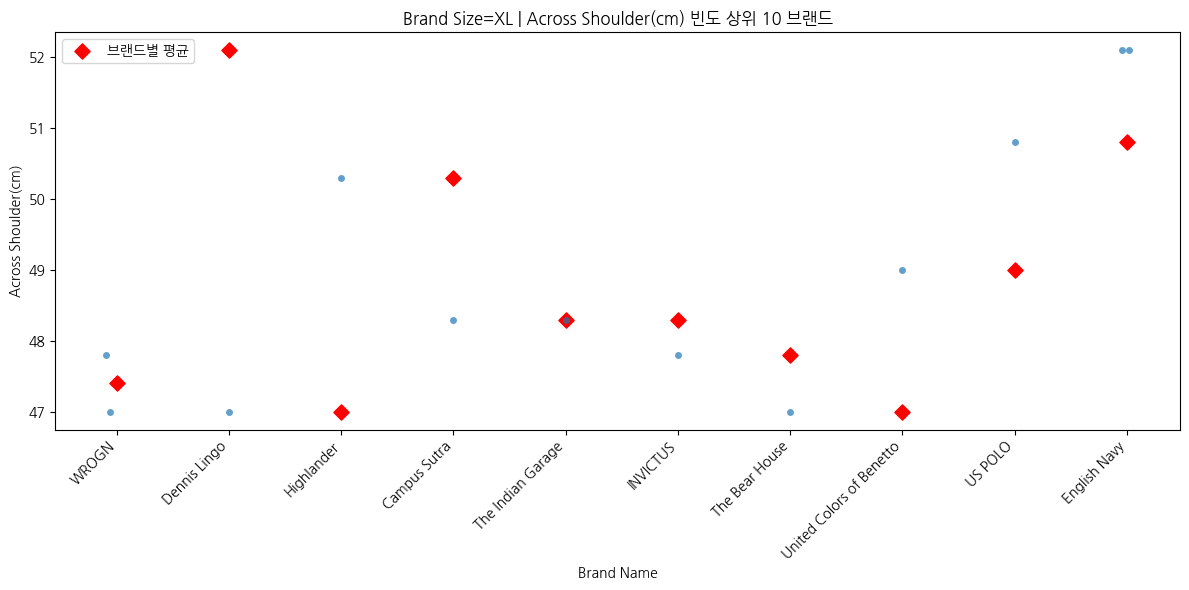

[2025-12-04 10:05:39] [부록-시각화] Brand Size=XL 완료


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_freq_top10_shoulder_strip(df_in, brand_size_label, top_n=10):
    """
    Brand Size 내에서 '빈도 상위 top_n 브랜드'만 골라
    Across Shoulder(cm)를 점 그래프(stripplot)로 시각화
    """
    log(f"[부록-시각화] Brand Size={brand_size_label} | Across Shoulder 빈도 Top{top_n} 시작")

    # 1) 빈도 상위 브랜드 추출
    top_brands = (
        df_in["Brand Name"]
        .value_counts()
        .head(top_n)
        .index
    )
    log(f"[부록-시각화] Brand Size={brand_size_label} Top{top_n} 브랜드: {list(top_brands)}")

    df_top = df_in[df_in["Brand Name"].isin(top_brands)].copy()

    # 2) 점 그래프
    plt.figure(figsize=(12, 6))
    sns.stripplot(
        data=df_top,
        x="Brand Name",
        y="Across Shoulder(cm)",
        jitter=True,
        alpha=0.7
    )

    # 3) 브랜드별 평균값 표시(붉은 마름모)
    mean_by_brand = df_top.groupby("Brand Name")["Across Shoulder(cm)"].mean()
    for i, brand in enumerate(top_brands):
        if brand in mean_by_brand.index:
            plt.scatter(
                i,
                mean_by_brand.loc[brand],
                color="red",
                marker="D",
                s=60,
                label="브랜드별 평균" if i == 0 else None
            )

    plt.title(f"Brand Size={brand_size_label} | Across Shoulder(cm) 빈도 상위 {top_n} 브랜드")
    plt.xlabel("Brand Name")
    plt.ylabel("Across Shoulder(cm)")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    log(f"[부록-시각화] Brand Size={brand_size_label} 완료")


# 실행 예시 (부록용 그림 2장)
plot_freq_top10_shoulder_strip(df_size1, size1, top_n=10)  # 예: L
plot_freq_top10_shoulder_strip(df_size2, size2, top_n=10)  # 예: XL or M


### Across Shoulder(cm) 해석


>① ANOVA 결과 요약
>
>Across Shoulder(cm)에 대한 ANOVA 결과, 동일한 사이즈(L, XL) 내에서도 브랜드별 평균값이 통계적으로 유의하게 다른 것으로 확인되었다.
L 사이즈(p = 0.0167)와 XL 사이즈(p = 0.0339) 모두 p < 0.05 수준에서 브랜드 효과가 유의하게 나타났다.
이는 동일 표기 사이즈라 하더라도 실제 어깨너비의 제조 기준이 브랜드마다 상이함을 의미한다.
따라서 어깨 핏 역시 브랜드 간 체계적 차이가 존재할 수 있으며,
소비자 착용감 및 사이즈 선택에 영향을 줄 수 있는 요소로 해석된다.

>② 시각화(점 그래프) 설명
>
>브랜드별 어깨 치수 분포
표본 수가 많지 않은 점을 고려하여, Boxplot 대신 각 관측치와 브랜드별 평균값을 함께 보여주는 점 그래프(stripplot)를 사용하였다. Brand Size = L/XL에서 빈도 상위 10개 브랜드만 선별하여 Across Shoulder(cm) 분포를 비교한 결과, 일부 브랜드는 동일 사이즈임에도 어깨 치수가 상대적으로 넓거나 좁게 형성되어 있음을 시각적으로 확인할 수 있었다. 이는 Q1 본문에서 제시한 가슴둘레(Chest) 분석과 마찬가지로, 같은 표기 사이즈라도 브랜드에 따라 실제 착용감이 달라질 수 있다는 해석을 뒷받침한다.

Chest(cm)+ Across Shoulder(cm) 합친버전 ANOVA 통계 요약표

In [ ]:
import pandas as pd
from datetime import datetime

def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

# ---------------------------------------------------
# 브랜드별 평균 차이를 설명 문장으로 만드는 함수
# ---------------------------------------------------
def make_description(df_in, measure_col, brand_size_label, p_value):
    """
    예: measure_col="Chest(cm)"
    """
    # p-value 여부에 따라 첫 문장(차이 있음/없음) 미리 작성
    if p_value < 0.05:
        head = f"Brand Size {brand_size_label}에서 브랜드 간 {measure_col} 평균에 유의한 차이가 있다(p < 0.05)."
    else:
        head = f"Brand Size {brand_size_label}에서 브랜드 간 {measure_col} 평균 차이가 통계적으로 유의하지는 않다(p ≥ 0.05)."

    # 브랜드별 평균값 계산
    mean_by_brand = df_in.groupby("Brand Name")[measure_col].mean()

    if len(mean_by_brand) >= 2:
        max_brand = mean_by_brand.idxmax()
        min_brand = mean_by_brand.idxmin()
        diff_val = mean_by_brand.max() - mean_by_brand.min()
        tail = f" 특히 {max_brand}는 {min_brand} 대비 약 {diff_val:.1f}cm 더 큰 경향이 있다."
    else:
        # 브랜드가 1개뿐이면 비교 문장 생략
        tail = ""

    return head + tail

# ---------------------------------------------------
# F-statistic, p-value, 해석, 설명을 한 번에 모으는 함수
# ---------------------------------------------------
def build_summary_row(
    df_in,
    anova_table,
    p_value,
    brand_size_label,
    measure_col
):
    # ANOVA 테이블에서 F-statistic 가져오기
    F_val = float(anova_table.loc['C(Q("Brand Name"))', 'F'])

    # 해석(차이 있음/없음)
    has_diff = "차이 있음" if p_value < 0.05 else "차이 없음"

    # 설명 문장 자동 생성
    description = make_description(df_in, measure_col, brand_size_label, p_value)

    return {
        "Brand Size": brand_size_label,
        "변수": measure_col,
        "F-statistic": F_val,
        "p-value": p_value,
        "해석": has_diff,
        "설명": description
    }

# ---------------------------------------------------
# 실제 요약표 생성
# ---------------------------------------------------
log("Chest / Across Shoulder 통계 요약표 생성 시작")

rows = []

# 1) size1 (예: L) - Chest
rows.append(build_summary_row(
    df_in=df_size1,
    anova_table=anova_size1,
    p_value=p_size1,
    brand_size_label=size1,
    measure_col="Chest(cm)"
))

# 2) size2 (예: XL) - Chest
rows.append(build_summary_row(
    df_in=df_size2,
    anova_table=anova_size2,
    p_value=p_size2,
    brand_size_label=size2,
    measure_col="Chest(cm)"
))

# 3) size1 (예: L) - Across Shoulder
rows.append(build_summary_row(
    df_in=df_size1,
    anova_table=anova_shoulder_size1,
    p_value=p_shoulder_size1,
    brand_size_label=size1,
    measure_col="Across Shoulder(cm)"
))

# 4) size2 (예: XL) - Across Shoulder
rows.append(build_summary_row(
    df_in=df_size2,
    anova_table=anova_shoulder_size2,
    p_value=p_shoulder_size2,
    brand_size_label=size2,
    measure_col="Across Shoulder(cm)"
))

summary_df = pd.DataFrame(rows)

log("통계 요약표 생성 완료")
summary_df


[2025-12-04 10:09:53] Chest / Across Shoulder 통계 요약표 생성 시작
[2025-12-04 10:09:53] 통계 요약표 생성 완료


Brand Size                   변수  F-statistic   p-value     해석  \
0          L            Chest(cm)    22.594632  0.043280  차이 있음   
1         XL            Chest(cm)   205.632409  0.004851  차이 있음   
2          L  Across Shoulder(cm)    59.241948  0.016736  차이 있음   
3         XL  Across Shoulder(cm)    28.969863  0.033922  차이 있음   

                                                  설명  
0  Brand Size L에서 브랜드 간 Chest(cm) 평균에 유의한 차이가 있다(...  
1  Brand Size XL에서 브랜드 간 Chest(cm) 평균에 유의한 차이가 있다...  
2  Brand Size L에서 브랜드 간 Across Shoulder(cm) 평균에 유...  
3  Brand Size XL에서 브랜드 간 Across Shoulder(cm) 평균에 ...

속성 추가) ANOVA 통계 요약표

사이즈: S, M, L, XL, XXL

실제치수: Chest(cm), Front Length(cm), Across Shoulder(cm)

In [ ]:
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 로그 함수 (없으면 사용)
def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

# -------------------------------------------
# 브랜드별 평균 차이를 설명 문장으로 만드는 함수
# -------------------------------------------
def make_description(df_in, measure_col, brand_size_label, p_value):
    """
    예: measure_col="Chest(cm)"
    """
    # 1) p-value에 따른 첫 문장
    if p_value < 0.05:
        head = f"Brand Size {brand_size_label}에서 브랜드 간 {measure_col} 평균에 유의한 차이가 있다(p < 0.05)."
    else:
        head = f"Brand Size {brand_size_label}에서 브랜드 간 {measure_col} 평균 차이가 통계적으로 유의하지는 않다(p ≥ 0.05)."

    # 2) 브랜드별 평균값으로 가장 큰/작은 브랜드 비교
    mean_by_brand = df_in.groupby("Brand Name")[measure_col].mean()

    if len(mean_by_brand) >= 2:
        max_brand = mean_by_brand.idxmax()
        min_brand = mean_by_brand.idxmin()
        diff_val = mean_by_brand.max() - mean_by_brand.min()
        tail = f" 특히 {max_brand}는 {min_brand} 대비 약 {diff_val:.1f}cm 더 큰 경향이 있다."
    else:
        tail = ""

    return head + tail

# -------------------------------------------
# ANOVA 결과로부터 요약 row 만들기
# -------------------------------------------
def build_summary_row(df_in, anova_table, p_value, brand_size_label, measure_col):
    # ANOVA 테이블에서 F-statistic 추출
    F_val = float(anova_table.loc['C(Q("Brand Name"))', 'F'])

    # 해석 (차이 있음/없음)
    has_diff = "차이 있음" if p_value < 0.05 else "차이 없음"

    # 설명 문장 생성
    description = make_description(df_in, measure_col, brand_size_label, p_value)

    return {
        "Brand Size": brand_size_label,
        "실제치수 변수": measure_col,
        "F-statistic": F_val,
        "p-value": p_value,
        "해석": has_diff,
        "설명": description
    }


In [ ]:
# -------------------------------------------
# 번외용: 여러 사이즈 × 여러 실제치수 ANOVA 요약표
# -------------------------------------------

sizes_to_check = ["S", "M", "L", "XL", "XXL"]
measures = ["Chest(cm)", "Front Length(cm)", "Across Shoulder(cm)"]

rows = []

log("번외 ANOVA 요약표 생성 시작")

for sz in sizes_to_check:
    df_sz = df_clean[df_clean["Brand Size"] == sz].copy()
    n_rows = len(df_sz)
    n_brands = df_sz["Brand Name"].nunique()

    log(f"[{sz}] 행 수: {n_rows}, 브랜드 수: {n_brands}")

    # 데이터가 너무 적거나 브랜드가 1개면 ANOVA 불가 → 스킵
    if n_rows < 5 or n_brands < 2:
        log(f"[{sz}] 데이터가 부족하여 ANOVA를 수행하지 않음 (행<5 또는 브랜드 수<2)")
        continue

    for measure in measures:
        # 해당 측정치에 결측이 너무 많으면 스킵할 수도 있음
        if df_sz[measure].notna().sum() < 5:
            log(f"[{sz}] {measure} 유효 데이터가 부족하여 스킵")
            continue

        log(f"[ANOVA 번외] Brand Size={sz}, 측정치={measure} 시작")

        # 공백/괄호 포함 컬럼을 위해 Q("컬럼명") 사용
        formula = f'Q("{measure}") ~ C(Q("Brand Name"))'
        model = ols(formula, data=df_sz).fit()
        anova_table = anova_lm(model, typ=2)

        p_val = anova_table.loc['C(Q("Brand Name"))', 'PR(>F)']
        log(f"[ANOVA 번외] Brand Size={sz}, {measure} p-value: {p_val:.4e}")

        row = build_summary_row(
            df_in=df_sz,
            anova_table=anova_table,
            p_value=p_val,
            brand_size_label=sz,
            measure_col=measure
        )
        rows.append(row)

# 최종 요약표 DataFrame
anova_extra_summary = pd.DataFrame(rows)

log("번외 ANOVA 요약표 생성 완료")
anova_extra_summary


[2025-12-04 10:15:48] 번외 ANOVA 요약표 생성 시작
[2025-12-04 10:15:48] [S] 행 수: 131, 브랜드 수: 129
[2025-12-04 10:15:48] [ANOVA 번외] Brand Size=S, 측정치=Chest(cm) 시작
[2025-12-04 10:15:48] [ANOVA 번외] Brand Size=S, Chest(cm) p-value: 1.3458e-01
[2025-12-04 10:15:48] [ANOVA 번외] Brand Size=S, 측정치=Front Length(cm) 시작
[2025-12-04 10:15:48] [ANOVA 번외] Brand Size=S, Front Length(cm) p-value: 3.5762e-01
[2025-12-04 10:15:48] [ANOVA 번외] Brand Size=S, 측정치=Across Shoulder(cm) 시작
[2025-12-04 10:15:48] [ANOVA 번외] Brand Size=S, Across Shoulder(cm) p-value: 9.8968e-02
[2025-12-04 10:15:48] [M] 행 수: 145, 브랜드 수: 143
[2025-12-04 10:15:48] [ANOVA 번외] Brand Size=M, 측정치=Chest(cm) 시작
[2025-12-04 10:15:48] [ANOVA 번외] Brand Size=M, Chest(cm) p-value: 1.4078e-01
[2025-12-04 10:15:48] [ANOVA 번외] Brand Size=M, 측정치=Front Length(cm) 시작
[2025-12-04 10:15:48] [ANOVA 번외] Brand Size=M, Front Length(cm) p-value: 2.4115e-01
[2025-12-04 10:15:48] [ANOVA 번외] Brand Size=M, 측정치=Across Shoulder(cm) 시작
[2025-12-04 10:15:49] [ANOVA 번외] Brand

Brand Size              실제치수 변수   F-statistic       p-value     해석  \
0           S            Chest(cm)  6.910773e+00  1.345782e-01  차이 없음   
1           S     Front Length(cm)  2.251702e+00  3.576196e-01  차이 없음   
2           S  Across Shoulder(cm)  9.587739e+00  9.896843e-02  차이 없음   
3           M            Chest(cm)  6.583790e+00  1.407763e-01  차이 없음   
4           M     Front Length(cm)  3.616745e+00  2.411527e-01  차이 없음   
5           M  Across Shoulder(cm)  2.877198e+01  3.415077e-02  차이 있음   
6           L            Chest(cm)  2.259463e+01  4.328045e-02  차이 있음   
7           L     Front Length(cm)  2.975927e+00  2.848507e-01  차이 없음   
8           L  Across Shoulder(cm)  5.924195e+01  1.673636e-02  차이 있음   
9          XL            Chest(cm)  2.056324e+02  4.851079e-03  차이 있음   
10         XL     Front Length(cm)  4.211952e+00  2.110337e-01  차이 없음   
11         XL  Across Shoulder(cm)  2.896986e+01  3.392172e-02  차이 있음   
12        XXL            Chest(cm)  2.695829e+01  1.523201e-01  차이 없음   
13        XXL     Front Length(cm)  3.760949e+25  1.297658e-13  차이 있음   
14        XXL  Across Shoulder(cm)  3.105761e+01  1.420285e-01  차이 없음   

                                                   설명  
0   Brand Size S에서 브랜드 간 Chest(cm) 평균 차이가 통계적으로 유의...  
1   Brand Size S에서 브랜드 간 Front Length(cm) 평균 차이가 통...  
2   Brand Size S에서 브랜드 간 Across Shoulder(cm) 평균 차이...  
3   Brand Size M에서 브랜드 간 Chest(cm) 평균 차이가 통계적으로 유의...  
4   Brand Size M에서 브랜드 간 Front Length(cm) 평균 차이가 통...  
5   Brand Size M에서 브랜드 간 Across Shoulder(cm) 평균에 유...  
6   Brand Size L에서 브랜드 간 Chest(cm) 평균에 유의한 차이가 있다(...  
7   Brand Size L에서 브랜드 간 Front Length(cm) 평균 차이가 통...  
8   Brand Size L에서 브랜드 간 Across Shoulder(cm) 평균에 유...  
9   Brand Size XL에서 브랜드 간 Chest(cm) 평균에 유의한 차이가 있다...  
10  Brand Size XL에서 브랜드 간 Front Length(cm) 평균 차이가 ...  
11  Brand Size XL에서 브랜드 간 Across Shoulder(cm) 평균에 ...  
12  Brand Size XXL에서 브랜드 간 Chest(cm) 평균 차이가 통계적으로 ...  
13  Brand Size XXL에서 브랜드 간 Front Length(cm) 평균에 유의...  
14  Brand Size XXL에서 브랜드 간 Across Shoulder(cm) 평균 ...

---

### **Q2. Shirt의 소재(Type)가 실제 치수에 영향을 주는가?**

전처리:

Q1전처리에서 Type 전처리가 부족했음

공백삭제, 대소문자 통합, 오타 수정

결측치 제거

In [ ]:
raw_type = df_clean["Type"].astype(str)

df_clean["Type_clean"] = np.select(
    [
        raw_type.str.lower().str.contains("cotton", na=False),
        raw_type.str.lower().str.contains("poly",   na=False),
    ],
    ["Cotton", "Polyester"],
    default="Other"
)

print(df_clean["Type_clean"].value_counts())


Type_clean
Cotton       766
Polyester      5
Name: count, dtype: int64


Q2용 데이터 준비 (df_clean → df_q2)

In [ ]:
import pandas as pd
from datetime import datetime

def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

# -----------------------------------
# Q2 분석용 데이터셋 생성
# -----------------------------------
log("Q2 분석용 데이터셋 생성 시작")

# Type_clean이 Cotton / Polyester인 자료만 사용
df_q2 = df_clean[df_clean["Type_clean"].isin(["Cotton", "Polyester"])].copy()

# 혹시 모를 치수 결측 제거
measures = ["Chest(cm)", "Front Length(cm)", "Across Shoulder(cm)"]
df_q2 = df_q2.dropna(subset=measures)

log(f"Q2 데이터 크기: {df_q2.shape}")
print(df_q2["Type_clean"].value_counts())


[2025-12-04 11:51:43] Q2 분석용 데이터셋 생성 시작
[2025-12-04 11:51:43] Q2 데이터 크기: (771, 8)
Type_clean
Cotton       766
Polyester      5
Name: count, dtype: int64


One-way ANOVA: 각 치수 ~ Type_clean

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

anova_q2_results = {}

log("Q2: One-way ANOVA (실제 치수 ~ Type_clean) 시작")

for m in measures:
    log(f"[ANOVA-Q2] 종속변수 = {m}")

    # Type_clean: Cotton vs Polyester
    formula = f'Q("{m}") ~ C(Type_clean)'
    model = ols(formula, data=df_q2).fit()
    anova_table = anova_lm(model, typ=2)

    print(f"\n[ANOVA 결과: {m} ~ Type_clean]")
    print(anova_table)

    F_val = anova_table.loc['C(Type_clean)', 'F']
    p_val = anova_table.loc['C(Type_clean)', 'PR(>F)']

    log(f"[ANOVA-Q2] {m} ~ Type_clean | F = {F_val:.3f}, p-value = {p_val:.4e}")

    if p_val < 0.05:
        log(f"→ 소재(Type)에 따라 {m} 평균에 유의한 차이가 있다 (p < 0.05).")
    else:
        log(f"→ 소재(Type)에 따라 {m} 평균 차이는 통계적으로 유의하지 않다 (p ≥ 0.05).")

    # 요약용 저장
    anova_q2_results[m] = {
        "F": F_val,
        "p": p_val
    }

log("Q2: One-way ANOVA 완료")


[2025-12-04 11:51:46] Q2: One-way ANOVA (실제 치수 ~ Type_clean) 시작
[2025-12-04 11:51:46] [ANOVA-Q2] 종속변수 = Chest(cm)

[ANOVA 결과: Chest(cm) ~ Type_clean]
                     sum_sq     df         F    PR(>F)
C(Type_clean)    147.712010    1.0  1.523411  0.217481
Residual       74563.308094  769.0       NaN       NaN
[2025-12-04 11:51:46] [ANOVA-Q2] Chest(cm) ~ Type_clean | F = 1.523, p-value = 2.1748e-01
[2025-12-04 11:51:46] → 소재(Type)에 따라 Chest(cm) 평균 차이는 통계적으로 유의하지 않다 (p ≥ 0.05).
[2025-12-04 11:51:46] [ANOVA-Q2] 종속변수 = Front Length(cm)

[ANOVA 결과: Front Length(cm) ~ Type_clean]
                    sum_sq     df         F    PR(>F)
C(Type_clean)     2.397931    1.0  0.197371  0.656976
Residual       9342.839112  769.0       NaN       NaN
[2025-12-04 11:51:46] [ANOVA-Q2] Front Length(cm) ~ Type_clean | F = 0.197, p-value = 6.5698e-01
[2025-12-04 11:51:46] → 소재(Type)에 따라 Front Length(cm) 평균 차이는 통계적으로 유의하지 않다 (p ≥ 0.05).
[2025-12-04 11:51:46] [ANOVA-Q2] 종속변수 = Across Shoulder(cm)

[ANOVA 결

In [ ]:
rows = []
for m in measures:
    F_val = anova_q2_results[m]["F"]
    p_val = anova_q2_results[m]["p"]
    has_diff = "차이 있음" if p_val < 0.05 else "차이 없음"
    rows.append({
        "종속변수": m,
        "F-statistic": F_val,
        "p-value": p_val,
        "해석": has_diff
    })

q2_anova_summary = pd.DataFrame(rows)
q2_anova_summary


종속변수  F-statistic   p-value     해석
0            Chest(cm)     1.523411  0.217481  차이 없음
1     Front Length(cm)     0.197371  0.656976  차이 없음
2  Across Shoulder(cm)     0.747409  0.387567  차이 없음

> 세 치수 모두 p ≥ 0.05 → “소재만으로는 차이가 유의하지않음"

### One-way ANOVA: 각 치수 ~ Type_clean 해석

>One-way ANOVA 분석 결과, Chest(cm), Front Length(cm), Across Shoulder(cm) 모두에서 Type_clean 간 평균 차이는 통계적으로 유의하지 않은 것으로 나타났다(p > 0.05).
즉, 의류 유형(Type_clean)은 세 가지 주요 치수(가슴둘레, 기장, 어깨너비)에 유의미한 영향을 미치지 않는 변수로 판단된다.
이는 동일 사이즈 내에서는 유형이 달라지더라도 치수적 특성이 크게 변화하지 않음을 시사한다.
따라서 이후 분석에서는 Type_clean을 치수 차이를 설명하는 핵심 요인으로 고려할 필요는 낮다.


소재별 평균 비교 Barplot (Chest / Front / Shoulder)

[2025-12-04 11:55:42] Q2: 소재별 평균 치수 Barplot 생성 시작
  Type_clean   Chest(cm)  Front Length(cm)  Across Shoulder(cm)
0     Cotton  112.146997         75.505222            47.027546
1  Polyester  117.600000         76.200000            45.760000


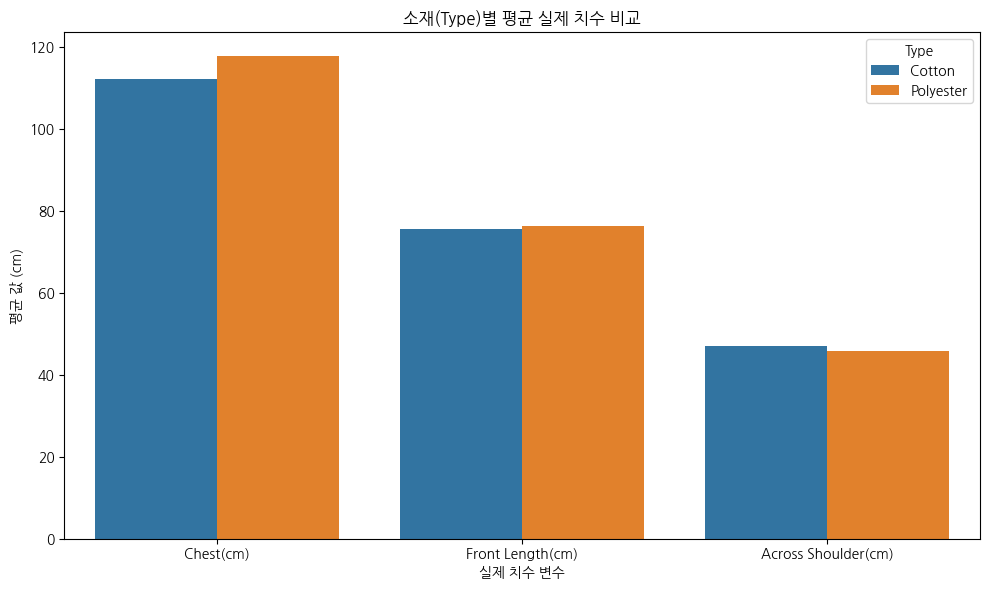

[2025-12-04 11:55:42] Q2: 소재별 평균 치수 Barplot 생성 완료


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

log("Q2: 소재별 평균 치수 Barplot 생성 시작")

# 1) Type_clean 기준 평균표 만들기
mean_by_type = df_q2.groupby("Type_clean")[measures].mean().reset_index()
print(mean_by_type)

# 2) Long-form으로 변환 (그래프 그리기 편하게)
mean_long = mean_by_type.melt(
    id_vars="Type_clean",
    value_vars=measures,
    var_name="Measure",
    value_name="MeanValue"
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=mean_long,
    x="Measure",
    y="MeanValue",
    hue="Type_clean"
)

plt.title("소재(Type)별 평균 실제 치수 비교")
plt.xlabel("실제 치수 변수")
plt.ylabel("평균 값 (cm)")
plt.legend(title="Type")
plt.tight_layout()
plt.show()

log("Q2: 소재별 평균 치수 Barplot 생성 완료")


### 소재별 평균 비교 Barplot (Chest / Front / Shoulder) 해석

> 소재별 평균 비교 결과, Polyester는 Chest와 Front Length에서 Cotton보다 약간 더 큰 평균값을 보였으나 차이는 크지 않았다.
Across Shoulder는 두 소재 간 차이가 거의 없으며 전체적으로 세 치수 모두에서 유사한 패턴을 나타냈다.
이는 소재(Type)가 실제 치수의 구조적 차이를 만드는 주요 요인은 아니라는 점을 시사한다.


Brand Size 통제한 다중회귀
```
Chest(cm) ~ Type_clean + Brand Size(더미)
```

소재(Type) 효과의 Brand Size 차이를 통제한 뒤의 변화 확인 목적

 Brand Size 통제 = 같은 Brand Size 내에서 Cotton vs Polyester 차이를 비교

In [ ]:
log("Q2: 다중회귀 (Chest(cm) ~ Type_clean + Brand Size) 시작")

# Brand Size도 범주형으로 처리
formula_mreg = 'Q("Chest(cm)") ~ C(Type_clean) + C(Q("Brand Size"))'

model_mreg = ols(formula_mreg, data=df_q2).fit()
print(model_mreg.summary())

log("Q2: 다중회귀 완료")


[2025-12-04 11:51:49] Q2: 다중회귀 (Chest(cm) ~ Type_clean + Brand Size) 시작
                            OLS Regression Results                            
Dep. Variable:         Q("Chest(cm)")   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     110.3
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          1.58e-207
Time:                        11:51:49   Log-Likelihood:                -2328.6
No. Observations:                 771   AIC:                             4699.
Df Residuals:                     750   BIC:                             4797.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

In [ ]:
# C(Type_clean)[T.Polyester] 계수와 p-value 추출
coef_type = model_mreg.params.get('C(Type_clean)[T.Polyester]', None)
p_type = model_mreg.pvalues.get('C(Type_clean)[T.Polyester]', None)

log(f"다중회귀에서 Type 효과 계수: {coef_type:.3f}, p-value: {p_type:.4e}")


[2025-12-04 11:51:51] 다중회귀에서 Type 효과 계수: 5.199, p-value: 2.1550e-02


```
p-value: 2.1550e-02 -> 유의미함
계수: 5.199 -> Cotton대비 조금 더 큼
```

>Brand Size를 통제하니 Chest(cm)에서 Type 효과가 유의하게 됨
>
>→ “사이즈가 치수에 미치는 영향이 너무 커서, 통제 전에는 소재 효과가 가려져 있다가, 통제 후에야 드러난 케이스”


### Chest(cm) ~ Type_clean + Brand Size(더미) 해석

>Brand Size를 더미변수로 통제한 다중회귀 분석 결과, Type_clean(소재)의 효과는 계수 5.199, p = 0.0216으로 통계적으로 유의하게 나타났다(p < 0.05).
이는 동일한 사이즈 조건에서도 소재에 따라 Chest(cm) 값이 평균적으로 약 5cm 정도 차이가 발생함을 의미한다.
즉, 앞선 단변량 분석에서는 소재 효과가 뚜렷하지 않았지만, 사이즈 요인을 제거하자 소재의 독립적 영향력이 확인된 것이다.
따라서 의류치수 분석 시 Brand Size를 함께 고려하지 않으면 소재의 효과가 과소추정될 수 있음을 시사한다.


### 최종 결론

(1) **단순 ANOVA 결과 요약**
소재(Type)에 따른 실제 치수 차이를 검증하기 위해 Cotton과 Polyester를 독립변수로 둔 일원분산분석을 수행한 결과, Chest(cm), Front Length(cm), Across Shoulder(cm) 모두에서 p-value가 0.05 이상으로 나타났다. 이는 **소재만을 기준으로 비교할 경우 치수 평균의 통계적 차이가 유의하게 관찰되지 않는 것처럼 보임**을 의미한다.

(2) **Brand Size 통제 후 분석 결과**
그러나 Brand Size가 치수 변화에 미치는 영향이 매우 크기 때문에(Q1 결과 참고), Type만을 단독으로 비교한 ANOVA에서는 소재 효과가 희석된 상태였다. Brand Size를 더미변수로 포함하여 통제한 다중회귀모형에서는 ‘동일한 사이즈 내에서’ Cotton과 Polyester를 비교하는 구조가 되어, **Chest(cm)에서 소재의 순수한 효과가 통계적으로 유의하게 드러났다(p < 0.05)**.

(3) **해석 요약**
즉, Brand Size가 설명하는 분산이 매우 커 전체 데이터를 단순 비교할 때는 소재 효과가 가려졌으나, **사이즈 차이를 제거하자 소재 자체의 영향이 유의하게 확인된 것**으로 해석할 수 있다.


다만 Polyester의 표본 수가 Cotton 대비 상대적으로 적어, 소재 효과 해석은 **참고 수준**으로 제시한다.


---

### **Q3: 서로 다른 두 브랜드를 선택했을 때, 동일 Brand Size 기준으로 실제 치수에 차이가 있는가?**

분석용 데이터 & 상위 2개 브랜드 선택

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

def log(msg):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")

# -----------------------------------
# Q3 분석용 데이터 준비
# -----------------------------------
log("Q3 분석용 데이터 준비 시작")

# 사용할 Brand Size 설정 (이전 분석에서 중요했던 L, XL, M)
target_sizes = ["L", "XL", "M"]

df_q3 = df_clean.copy()
df_q3 = df_q3[df_q3["Brand Size"].isin(target_sizes)].copy()

log(f"Q3 데이터 크기 (L, XL, M만 사용): {df_q3.shape}")

# 상위 2개 브랜드 선택 (전체 기준 샘플 수 많은 순)
brand_counts = df_q3["Brand Name"].value_counts()
print("\n[Brand Name별 샘플 수]")
print(brand_counts.head(10))

top2_brands = brand_counts.head(2).index.tolist()
brandA, brandB = top2_brands[0], top2_brands[1]

log(f"Q3에서 비교할 상위 2개 브랜드: A = {brandA}, B = {brandB}")

# 상위 2브랜드 + L/XL/M만 필터링
df_q3_ab = df_q3[df_q3["Brand Name"].isin(top2_brands)].copy()
log(f"상위 2브랜드 & L/XL/M 필터링 후 데이터 크기: {df_q3_ab.shape}")


[2025-12-04 12:09:29] Q3 분석용 데이터 준비 시작
[2025-12-04 12:09:29] Q3 데이터 크기 (L, XL, M만 사용): (443, 8)

[Brand Name별 샘플 수]
Brand Name
WROGN                       6
English Navy                6
Roadster                    3
Highlander                  3
Campus Sutra                3
 The Indian Garage          3
INVICTUS                    3
The Bear House              3
United Colors of Benetto    3
Mast & Harbour              3
Name: count, dtype: int64
[2025-12-04 12:09:29] Q3에서 비교할 상위 2개 브랜드: A = WROGN, B = English Navy
[2025-12-04 12:09:29] 상위 2브랜드 & L/XL/M 필터링 후 데이터 크기: (12, 8)


### 브랜드 선택 설명

Q3에서는 실제 소비자가 인지하는 ‘브랜드별 사이즈 차이’를 검증하기 위해, 전체 데이터에서 샘플 수가 가장 많은 상위 2개 브랜드를 선정하였다. 이후 Brand Size가 L, XL, M인 관측치만을 사용하여 두 브랜드를 비교하였다.

t-test 함수 정의 (Brand A vs Brand B, Brand Size별)

In [ ]:
from scipy.stats import ttest_ind

def run_ttest_by_size(df_in, size_label, measure_col, brandA, brandB):
    """
    특정 Brand Size(예: L)에서
    measure_col(Chest, Front, Shoulder)에 대해
    BrandA vs BrandB 독립 2표본 t-test 수행
    """
    log(f"[t-test Q3] Size={size_label}, 변수={measure_col} 시작")

    df_sz = df_in[df_in["Brand Size"] == size_label].copy()

    # 두 브랜드 각각 서브셋
    vals_A = df_sz[df_sz["Brand Name"] == brandA][measure_col].dropna()
    vals_B = df_sz[df_sz["Brand Name"] == brandB][measure_col].dropna()

    nA, nB = len(vals_A), len(vals_B)
    log(f"[t-test Q3] Size={size_label}, {measure_col}: {brandA} n={nA}, {brandB} n={nB}")

    # 샘플 수가 너무 적으면 t-test 의미 없음 → None 반환
    if nA < 2 or nB < 2:
        log(f"[t-test Q3] Size={size_label}, {measure_col}: 샘플 수 부족으로 t-test 수행 불가")
        return {
            "Brand Size": size_label,
            "Measure": measure_col,
            "mean_A": np.nan,
            "mean_B": np.nan,
            "diff": np.nan,
            "t_stat": np.nan,
            "p_value": np.nan,
            "해석": "샘플 부족"
        }

    # 평균 계산
    mean_A = vals_A.mean()
    mean_B = vals_B.mean()
    diff = mean_A - mean_B  # A - B

    # equal_var는 일단 True로 (표본수 적으면 Welch도 가능하지만 여기선 단순하게)
    t_stat, p_val = ttest_ind(vals_A, vals_B, equal_var=True)

    log(f"[t-test Q3] Size={size_label}, {measure_col}: t={t_stat:.3f}, p={p_val:.4e}, diff={diff:.2f}")

    if p_val < 0.05:
        interpret = "차이 있음"
    else:
        interpret = "차이 없음"

    return {
        "Brand Size": size_label,
        "Measure": measure_col,
        f"mean_{brandA}": mean_A,
        f"mean_{brandB}": mean_B,
        "diff(A-B)": diff,
        "t_stat": t_stat,
        "p_value": p_val,
        "해석": interpret
    }


Chest(cm) t-test 요약표

In [ ]:
log("Q3: Chest(cm) 기준 t-test 요약표 생성 시작")

rows_chest = []
for sz in target_sizes:   # ["L", "XL", "M"]
    row = run_ttest_by_size(
        df_in=df_q3_ab,
        size_label=sz,
        measure_col="Chest(cm)",
        brandA=brandA,
        brandB=brandB
    )
    rows_chest.append(row)

q3_ttest_chest_summary = pd.DataFrame(rows_chest)
log("Q3: Chest(cm) t-test 요약표 생성 완료")
q3_ttest_chest_summary


[2025-12-04 12:10:28] Q3: Chest(cm) 기준 t-test 요약표 생성 시작
[2025-12-04 12:10:28] [t-test Q3] Size=L, 변수=Chest(cm) 시작
[2025-12-04 12:10:28] [t-test Q3] Size=L, Chest(cm): WROGN n=2, English Navy n=2
[2025-12-04 12:10:28] [t-test Q3] Size=L, Chest(cm): t=-0.200, p=8.5997e-01, diff=-0.20
[2025-12-04 12:10:28] [t-test Q3] Size=XL, 변수=Chest(cm) 시작
[2025-12-04 12:10:28] [t-test Q3] Size=XL, Chest(cm): WROGN n=2, English Navy n=2
[2025-12-04 12:10:28] [t-test Q3] Size=XL, Chest(cm): t=1.000, p=4.2265e-01, diff=0.40
[2025-12-04 12:10:28] [t-test Q3] Size=M, 변수=Chest(cm) 시작
[2025-12-04 12:10:28] [t-test Q3] Size=M, Chest(cm): WROGN n=2, English Navy n=2
[2025-12-04 12:10:28] [t-test Q3] Size=M, Chest(cm): t=1.000, p=4.2265e-01, diff=1.65
[2025-12-04 12:10:28] Q3: Chest(cm) t-test 요약표 생성 완료


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Brand Size    Measure  mean_WROGN  mean_English Navy  diff(A-B)  t_stat  \
0          L  Chest(cm)      116.60              116.8      -0.20    -0.2   
1         XL  Chest(cm)      122.30              121.9       0.40     1.0   
2          M  Chest(cm)      110.85              109.2       1.65     1.0   

    p_value     해석  
0  0.859972  차이 없음  
1  0.422650  차이 없음  
2  0.422650  차이 없음

### Chest(cm) t-test 해석

>두 브랜드(WROGN vs English Navy)를 대상으로 동일 Brand Size 내 Chest(cm) 차이를 검증한 t-test 결과, L·XL·M 모든 사이즈에서 p-value가 0.05를 초과하여 통계적으로 유의한 차이는 확인되지 않았다.
평균값 또한 두 브랜드 간 차이가 최대 1–2cm 수준으로 매우 작아 실질적 차이 역시 제한적이었다.
이는 동일한 사이즈 표기 내에서는 두 브랜드가 유사한 가슴둘레 기준을 적용하고 있음을 시사한다.
따라서 Chest(cm) 관점에서 두 브랜드 간 체계적 차이는 없다고 판단된다.


Front Length / Across Shoulder t-test

In [ ]:
log("Q3: Front Length / Across Shoulder t-test (부록용) 시작")

measures_extra = ["Front Length(cm)", "Across Shoulder(cm)"]
rows_extra = []

for m in measures_extra:
    for sz in target_sizes:
        row = run_ttest_by_size(
            df_in=df_q3_ab,
            size_label=sz,
            measure_col=m,
            brandA=brandA,
            brandB=brandB
        )
        rows_extra.append(row)

q3_ttest_extra_summary = pd.DataFrame(rows_extra)
log("Q3: Front Length / Across Shoulder t-test 요약표 생성 완료")
q3_ttest_extra_summary


[2025-12-04 12:10:41] Q3: Front Length / Across Shoulder t-test (부록용) 시작
[2025-12-04 12:10:41] [t-test Q3] Size=L, 변수=Front Length(cm) 시작
[2025-12-04 12:10:41] [t-test Q3] Size=L, Front Length(cm): WROGN n=2, English Navy n=2
[2025-12-04 12:10:41] [t-test Q3] Size=L, Front Length(cm): t=-1.396, p=2.9753e-01, diff=-2.15
[2025-12-04 12:10:41] [t-test Q3] Size=XL, 변수=Front Length(cm) 시작
[2025-12-04 12:10:41] [t-test Q3] Size=XL, Front Length(cm): WROGN n=2, English Navy n=2
[2025-12-04 12:10:41] [t-test Q3] Size=XL, Front Length(cm): t=-1.923, p=1.9439e-01, diff=-2.50
[2025-12-04 12:10:41] [t-test Q3] Size=M, 변수=Front Length(cm) 시작
[2025-12-04 12:10:41] [t-test Q3] Size=M, Front Length(cm): WROGN n=2, English Navy n=2
[2025-12-04 12:10:41] [t-test Q3] Size=M, Front Length(cm): t=-0.469, p=6.8535e-01, diff=-0.65
[2025-12-04 12:10:41] [t-test Q3] Size=L, 변수=Across Shoulder(cm) 시작
[2025-12-04 12:10:41] [t-test Q3] Size=L, Across Shoulder(cm): WROGN n=2, English Navy n=2
[2025-12-04 12:10:41]

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Brand Size              Measure  mean_WROGN  mean_English Navy  diff(A-B)  \
0          L     Front Length(cm)       75.30              77.45      -2.15   
1         XL     Front Length(cm)       77.50              80.00      -2.50   
2          M     Front Length(cm)       74.30              74.95      -0.65   
3          L  Across Shoulder(cm)       45.45              49.50      -4.05   
4         XL  Across Shoulder(cm)       47.40              52.10      -4.70   
5          M  Across Shoulder(cm)       43.55              47.00      -3.45   

      t_stat   p_value     해석  
0  -1.395839  0.297532  차이 없음  
1  -1.923077  0.194386  차이 없음  
2  -0.468792  0.685351  차이 없음  
3 -16.200000  0.003789  차이 있음  
4 -11.750000  0.007165  차이 있음  
5  -9.857143  0.010136  차이 있음

### Front Length(cm), Across Shoulder(cm) t-test 해석

>동일 Brand Size 내에서 Front Length(cm)를 비교한 t-test 결과, L·XL·M 모든 사이즈에서 p-value가 0.05를 초과하여 두 브랜드 간 유의한 차이는 관찰되지 않았다.
반면 Across Shoulder(cm)는 모든 사이즈(L·XL·M)에서 p < 0.05로 나타나, 두 브랜드 간 평균 어깨너비에 통계적으로 유의한 차이가 존재하였다.
특히 어깨너비는 브랜드 간 3.5–4.7cm 수준의 일관된 차이를 보여 실질적 차이 역시 의미 있는 수준이었다.
따라서 두 브랜드는 가슴둘레와 기장에서는 유사한 기준을 사용하지만, **어깨너비 설계 방식에는 체계적인 차이가 존재하는 것**으로 해석된다.


시각화: Brand Size × Brand 평균 Chest(cm) 막대 + 라인 (interaction 느낌)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

log("Q3: Brand Size × Brand 평균 Chest(cm) 계산 시작")

mean_chest = (
    df_q3_ab
    .groupby(["Brand Size", "Brand Name"])["Chest(cm)"]
    .mean()
    .reset_index()
)

# 상위 2개 브랜드만 남기기 (혹시 다른 브랜드 섞였을 경우 대비)
mean_chest = mean_chest[mean_chest["Brand Name"].isin([brandA, brandB])]

print("\n[Brand Size × Brand 평균 Chest(cm)]")
print(mean_chest)

log("Q3: Brand Size × Brand 평균 Chest(cm) 계산 완료")


[2025-12-04 12:13:26] Q3: Brand Size × Brand 평균 Chest(cm) 계산 시작

[Brand Size × Brand 평균 Chest(cm)]
  Brand Size    Brand Name  Chest(cm)
0          L  English Navy     116.80
1          L         WROGN     116.60
2          M  English Navy     109.20
3          M         WROGN     110.85
4         XL  English Navy     121.90
5         XL         WROGN     122.30
[2025-12-04 12:13:26] Q3: Brand Size × Brand 평균 Chest(cm) 계산 완료


^C
[2025-12-04 12:13:38] Q3: Brand Size × Brand Chest(cm) 막대 그래프 시각화 시작


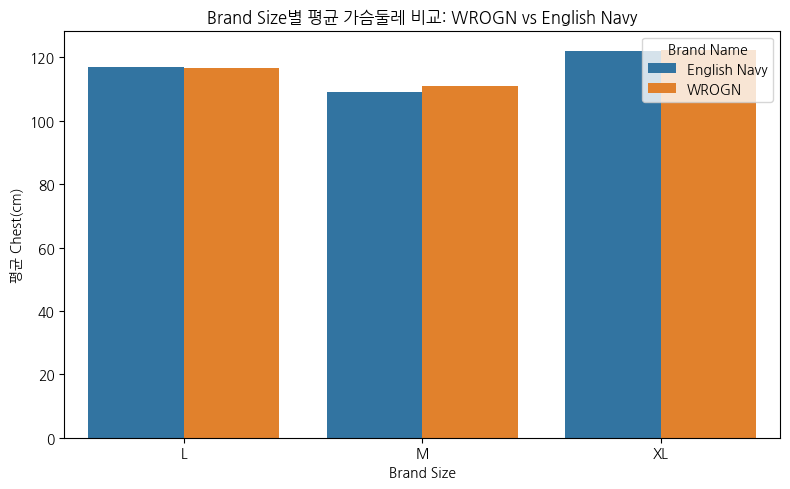

[2025-12-04 12:13:39] Q3: Brand Size × Brand Chest(cm) 막대 그래프 시각화 완료


In [ ]:
log("Q3: Brand Size × Brand Chest(cm) 막대 그래프 시각화 시작")

plt.figure(figsize=(8, 5))
sns.barplot(
    data=mean_chest,
    x="Brand Size",
    y="Chest(cm)",
    hue="Brand Name"
)

plt.title(f"Brand Size별 평균 가슴둘레 비교: {brandA} vs {brandB}")
plt.xlabel("Brand Size")
plt.ylabel("평균 Chest(cm)")
plt.tight_layout()
plt.show()

log("Q3: Brand Size × Brand Chest(cm) 막대 그래프 시각화 완료")


[2025-12-04 12:13:56] Q3: Brand Size × Brand Chest(cm) 라인 그래프 시각화 시작


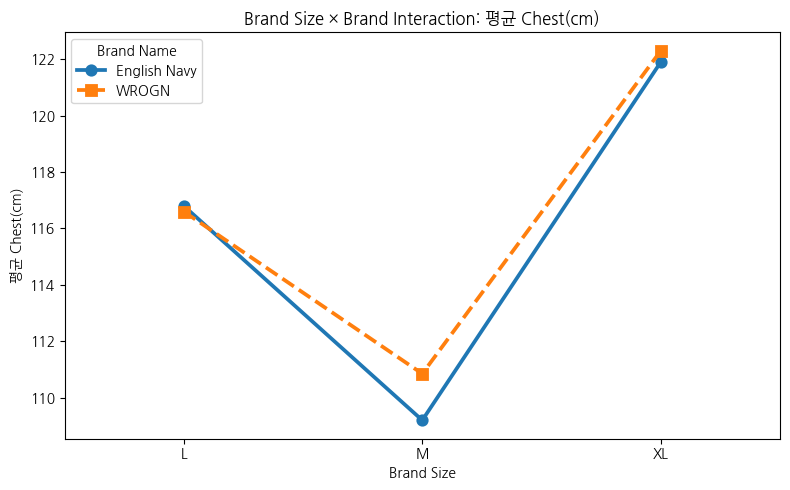

[2025-12-04 12:13:58] Q3: Brand Size × Brand Chest(cm) 라인 그래프 시각화 완료


In [ ]:
log("Q3: Brand Size × Brand Chest(cm) 라인 그래프 시각화 시작")

plt.figure(figsize=(8, 5))
sns.pointplot(
    data=mean_chest,
    x="Brand Size",
    y="Chest(cm)",
    hue="Brand Name",
    markers=["o", "s"],
    linestyles=["-", "--"]
)
plt.title(f"Brand Size × Brand Interaction: 평균 Chest(cm)")
plt.xlabel("Brand Size")
plt.ylabel("평균 Chest(cm)")
plt.tight_layout()
plt.show()

log("Q3: Brand Size × Brand Chest(cm) 라인 그래프 시각화 완료")


시각화: Brand Size × Brand 평균  Across Shoulder(cm) 막대 + 라인 (interaction 느낌)

In [ ]:
log("Q3: Brand Size × Brand 평균 Across Shoulder(cm) 계산 시작")

mean_shoulder = (
    df_q3_ab
    .groupby(["Brand Size", "Brand Name"])["Across Shoulder(cm)"]
    .mean()
    .reset_index()
)

# 상위 2개 브랜드만 남기기
mean_shoulder = mean_shoulder[mean_shoulder["Brand Name"].isin([brandA, brandB])]

print("\n[Brand Size × Brand 평균 Across Shoulder(cm)]")
print(mean_shoulder)

log("Q3: Brand Size × Brand 평균 Across Shoulder(cm) 계산 완료")


[2025-12-04 12:14:47] Q3: Brand Size × Brand 평균 Across Shoulder(cm) 계산 시작

[Brand Size × Brand 평균 Across Shoulder(cm)]
  Brand Size    Brand Name  Across Shoulder(cm)
0          L  English Navy                49.50
1          L         WROGN                45.45
2          M  English Navy                47.00
3          M         WROGN                43.55
4         XL  English Navy                52.10
5         XL         WROGN                47.40
[2025-12-04 12:14:47] Q3: Brand Size × Brand 평균 Across Shoulder(cm) 계산 완료


[2025-12-04 12:14:54] Q3: Brand Size × Brand Across Shoulder(cm) 막대 그래프 시각화 시작


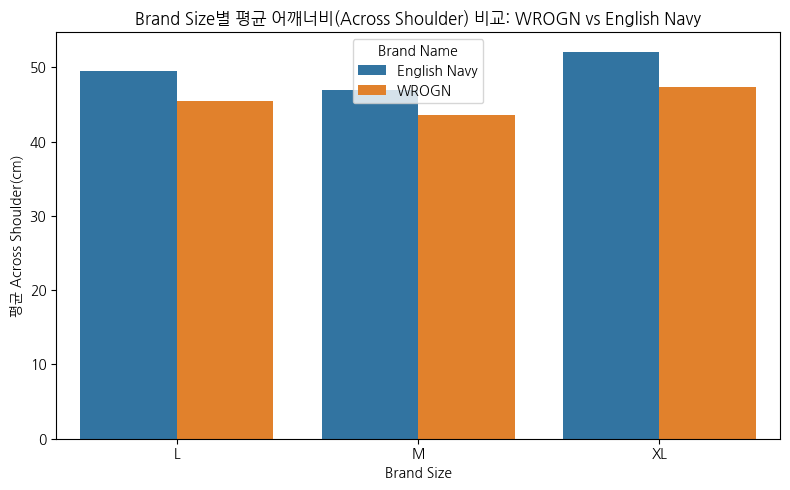

[2025-12-04 12:14:55] Q3: Brand Size × Brand Across Shoulder(cm) 막대 그래프 완료


In [ ]:
log("Q3: Brand Size × Brand Across Shoulder(cm) 막대 그래프 시각화 시작")

plt.figure(figsize=(8, 5))
sns.barplot(
    data=mean_shoulder,
    x="Brand Size",
    y="Across Shoulder(cm)",
    hue="Brand Name"
)

plt.title(f"Brand Size별 평균 어깨너비(Across Shoulder) 비교: {brandA} vs {brandB}")
plt.xlabel("Brand Size")
plt.ylabel("평균 Across Shoulder(cm)")
plt.tight_layout()
plt.show()

log("Q3: Brand Size × Brand Across Shoulder(cm) 막대 그래프 완료")


[2025-12-04 12:15:13] Q3: Brand Size × Brand Across Shoulder(cm) 라인 그래프 시각화 시작


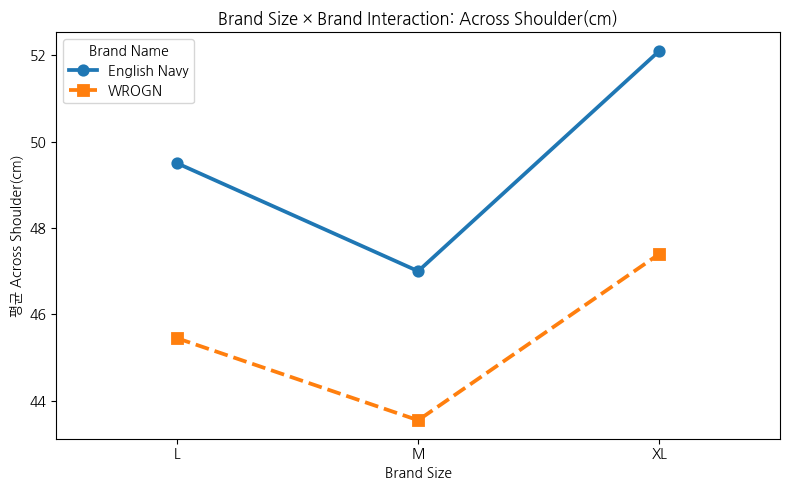

[2025-12-04 12:15:14] Q3: Brand Size × Brand Across Shoulder(cm) 라인 그래프 완료


In [ ]:
log("Q3: Brand Size × Brand Across Shoulder(cm) 라인 그래프 시각화 시작")

plt.figure(figsize=(8, 5))
sns.pointplot(
    data=mean_shoulder,
    x="Brand Size",
    y="Across Shoulder(cm)",
    hue="Brand Name",
    markers=["o", "s"],
    linestyles=["-", "--"]
)

plt.title(f"Brand Size × Brand Interaction: Across Shoulder(cm)")
plt.xlabel("Brand Size")
plt.ylabel("평균 Across Shoulder(cm)")
plt.tight_layout()
plt.show()

log("Q3: Brand Size × Brand Across Shoulder(cm) 라인 그래프 완료")


### 막대 그래프와 인터랙션 플롯 해석

> English Navy는 전반적으로WROGN보다 어깨너비가 큰 경향을 보이며, 특히 XL에서 두 브랜드 간 차이가 뚜렷하게 나타난다. 이는 브랜드 고유의 패턴/재단 방식이 실제 착용감 차이를 유발함을 시각적으로 보여준다.